In [1]:
options(warn=-1)
suppressMessages({library("dplyr")
library("tidyr")
library("ggplot2")         
library("GenomicRanges")
library("eulerr")
library("gridExtra")
library("reshape2")})

# Additional comparison of MChIP-C, PLAC-seq and Micro-C in terms of resolution and sensitivity

In [8]:
CTCF_peaks <- read.csv("Auxiliary_data/ENCFF002CEL.bed.gz", header = F, sep = "\t")
CTCF_peaks <- filter(CTCF_peaks, V5 > 250)[,1:3]
CTCF_ranges <- GRanges(seqnames = CTCF_peaks$V1,ranges=IRanges(start=CTCF_peaks$V2, end=CTCF_peaks$V3))
colnames(CTCF_peaks)<-c("CTCF_chr","CTCF_start","CTCF_end")
DHSs <- read.csv("Auxiliary_data/ENCFF621ZJY.bed.gz", header = F, sep = "\t")
DHSs <- filter(DHSs, V7 > 200)[,1:3]
DHS_ranges <- GRanges(seqnames = DHSs$V1, ranges=IRanges(start=DHSs$V2, end=DHSs$V3))
DHSs <- DHSs[-(as.data.frame(findOverlaps(DHS_ranges,CTCF_ranges))[,1]),]
DHS_ranges <- GRanges(seqnames = DHSs$V1, ranges=IRanges(start=DHSs$V2, end=DHSs$V3))          
colnames(DHSs)<-c("DHS_chr","DHS_start","DHS_end")
vp <- read.csv("MChIPC_output/MChIPC_viewpoints.bed", header = F, sep = "\t")[,1:4]
vp_ranges <- GRanges(seqnames = vp$V1, ranges=IRanges(start=vp$V2, end=vp$V3))
colnames(vp)<-c("vp_chr","vp_start","vp_end","vp_name")

In [9]:
# prepairing MChIP-C data
MChIPC_int <- read.csv("MChIPC_output/MChIPC_interactions.bedpe", header = F, sep = "\t")
MChIPC_OE_ranges <- GRanges(seqnames = MChIPC_int$V4, ranges=IRanges(start=MChIPC_int$V5, end=MChIPC_int$V6))
MChIPC_int <- MChIPC_int[-(as.data.frame(findOverlaps(MChIPC_OE_ranges,vp_ranges))[,1]),]
MChIPC_OE_ranges <- GRanges(seqnames = MChIPC_int$V4, ranges=IRanges(start=MChIPC_int$V5, end=MChIPC_int$V6))
MChIPC_CTCF <- distinct(cbind(MChIPC_int[as.data.frame(findOverlaps(MChIPC_OE_ranges,CTCF_ranges))[,1],],
                     CTCF_peaks[as.data.frame(findOverlaps(MChIPC_OE_ranges,CTCF_ranges))[,2],]))
MChIPC_DHS <- distinct(cbind(MChIPC_int[as.data.frame(findOverlaps(MChIPC_OE_ranges,DHS_ranges))[,1],],
                     DHSs[as.data.frame(findOverlaps(MChIPC_OE_ranges,DHS_ranges))[,2],]))
colnames(MChIPC_CTCF)[1:6] <- c("vp_chr","vp_start","vp_end","OE_chr","OE_start","OE_end")
colnames(MChIPC_DHS)[1:6] <- c("vp_chr","vp_start","vp_end","OE_chr","OE_start","OE_end")
MChIPC_CTCF$V4 <- rownames(MChIPC_CTCF)
MChIPC_DHS$V4 <- rownames(MChIPC_DHS)
MChIPC_CTCF <- separate(MChIPC_CTCF, V4, sep = "\\.", into=c("int_index"))
MChIPC_DHS <- separate(MChIPC_DHS, V4, sep = "\\.", into=c("int_index"))
MChIPC_CTCF_dist <- distinct(MChIPC_CTCF[,c(1:3,7:10)])
MChIPC_DHS_dist <- distinct(MChIPC_DHS[,c(1:3,7:10)])
MChIPC_CTCF_dist <- left_join(MChIPC_CTCF_dist, 
                     mutate(distinct(MChIPC_CTCF_dist[,1:6]), pair=1:nrow(distinct(MChIPC_CTCF_dist[,1:6]))))
MChIPC_DHS_dist <- left_join(MChIPC_DHS_dist, 
                     mutate(distinct(MChIPC_DHS_dist[,1:6]), pair=1:nrow(distinct(MChIPC_DHS_dist[,1:6]))))
MChIPC_CTCF_dist$unique <- !(MChIPC_CTCF_dist$int_index %in% 
                              unique(c(MChIPC_CTCF_dist$int_index[duplicated(MChIPC_CTCF_dist$int_index)],
                                       MChIPC_CTCF_dist$int_index[duplicated(MChIPC_CTCF_dist$int_index, 
                                                                              fromLast=T)])))
MChIPC_DHS_dist$unique <- !(MChIPC_DHS_dist$int_index %in% 
                              unique(c(MChIPC_DHS_dist$int_index[duplicated(MChIPC_DHS_dist$int_index)],
                                       MChIPC_DHS_dist$int_index[duplicated(MChIPC_DHS_dist$int_index, 
                                                                              fromLast=T)])))
MChIPC_CTCF <- left_join(MChIPC_CTCF, vp)
MChIPC_DHS <- left_join(MChIPC_DHS, vp)

N1 <- length(unique(MChIPC_CTCF_dist$pair))
N3 <- round(100*length(unique(MChIPC_CTCF_dist$pair[!(MChIPC_CTCF_dist$unique)]))/length(unique(MChIPC_CTCF_dist$pair)),2)
N2 <- length(unique(MChIPC_DHS_dist$pair))
N4 <- round(100*length(unique(MChIPC_DHS_dist$pair[!(MChIPC_DHS_dist$unique)]))/length(unique(MChIPC_DHS_dist$pair)),2)
cat(paste0("We identified ",N1," unique P-CTCF interactions in MChIP-C data and ",N2,
           " unique P-DHS interactions.\n",N3,"% and ",N4,
           "% of them correspondingly fell in the same genomic bin as at least one another interaction of the same type."))
rm(list=c("MChIPC_CTCF_dist","MChIPC_DHS_dist","MChIPC_int","N1","N2","N3","N4"))

Joining with `by = join_by(vp_chr, vp_start, vp_end, CTCF_chr, CTCF_start, CTCF_end)`
Joining with `by = join_by(vp_chr, vp_start, vp_end, DHS_chr, DHS_start, DHS_end)`
Joining with `by = join_by(vp_chr, vp_start, vp_end)`
Joining with `by = join_by(vp_chr, vp_start, vp_end)`


We identified 29321 unique P-CTCF interactions in MChIP-C data and 13913 unique P-DHS interactions.
2.66% and 4.97% of them correspondingly fell in the same genomic bin as at least one another interaction of the same type.

In [10]:
# prepairing PLAC-seq data
PLACseq_int <- read.csv("PLACseq_output//PLACseq_interactions.bedpe", header = F, sep = "\t")
PLACseq_vp_ranges <- GRanges(seqnames = PLACseq_int$V1, ranges=IRanges(start=PLACseq_int$V2, end=PLACseq_int$V3))
PLACseq_int <- cbind(PLACseq_int[as.data.frame(findOverlaps(PLACseq_vp_ranges,vp_ranges))[,1],],
                     vp[as.data.frame(findOverlaps(PLACseq_vp_ranges,vp_ranges))[,2],])
PLACseq_OE_ranges <- GRanges(seqnames = PLACseq_int$V4, ranges=IRanges(start=PLACseq_int$V5, end=PLACseq_int$V6))
PLACseq_int <- PLACseq_int[-(as.data.frame(findOverlaps(PLACseq_OE_ranges,vp_ranges))[,1]),]
rownames(PLACseq_int) <- 1:nrow(PLACseq_int)
PLACseq_OE_ranges <- GRanges(seqnames = PLACseq_int$V4, ranges=IRanges(start=PLACseq_int$V5, end=PLACseq_int$V6))
PLACseq_CTCF <- distinct(cbind(PLACseq_int[as.data.frame(findOverlaps(PLACseq_OE_ranges,CTCF_ranges))[,1],],
                     CTCF_peaks[as.data.frame(findOverlaps(PLACseq_OE_ranges,CTCF_ranges))[,2],]))[,c(7:9,4:6,11:13,10)]
PLACseq_DHS <- distinct(cbind(PLACseq_int[as.data.frame(findOverlaps(PLACseq_OE_ranges,DHS_ranges))[,1],],
                     DHSs[as.data.frame(findOverlaps(PLACseq_OE_ranges,DHS_ranges))[,2],]))[,c(7:9,4:6,11:13,10)]
colnames(PLACseq_CTCF)[4:6] <- c("OE_chr","OE_start","OE_end")
colnames(PLACseq_DHS)[4:6] <- c("OE_chr","OE_start","OE_end")
PLACseq_CTCF$V4 <- rownames(PLACseq_CTCF)
PLACseq_DHS$V4 <- rownames(PLACseq_DHS)
PLACseq_CTCF <- separate(PLACseq_CTCF, V4, sep = "\\.", into=c("int_index"))
PLACseq_DHS <- separate(PLACseq_DHS, V4, sep = "\\.", into=c("int_index"))
PLACseq_CTCF_dist <- distinct(PLACseq_CTCF[,c(1:3,7:9,11)])
PLACseq_DHS_dist <- distinct(PLACseq_DHS[,c(1:3,7:9,11)])
PLACseq_CTCF_dist <- left_join(PLACseq_CTCF_dist, 
                     mutate(distinct(PLACseq_CTCF_dist[,1:6]), pair=1:nrow(distinct(PLACseq_CTCF_dist[,1:6]))))
PLACseq_DHS_dist <- left_join(PLACseq_DHS_dist, 
                     mutate(distinct(PLACseq_DHS_dist[,1:6]), pair=1:nrow(distinct(PLACseq_DHS_dist[,1:6]))))
PLACseq_CTCF_dist$unique <- !(PLACseq_CTCF_dist$int_index %in% 
                    unique(c(PLACseq_CTCF_dist$int_index[duplicated(PLACseq_CTCF_dist$int_index)],
                             PLACseq_CTCF_dist$int_index[duplicated(PLACseq_CTCF_dist$int_index, fromLast=T)])))
PLACseq_DHS_dist$unique <- !(PLACseq_DHS_dist$int_index %in% 
                    unique(c(PLACseq_DHS_dist$int_index[duplicated(PLACseq_DHS_dist$int_index)],
                             PLACseq_DHS_dist$int_index[duplicated(PLACseq_DHS_dist$int_index, fromLast=T)])))

N1 <- length(unique(PLACseq_CTCF_dist$pair))
N3 <- round(100*length(unique(PLACseq_CTCF_dist$pair[!(PLACseq_CTCF_dist$unique)]))/length(unique(PLACseq_CTCF_dist$pair)),2)
N2 <- length(unique(PLACseq_DHS_dist$pair))
N4 <- round(100*length(unique(PLACseq_DHS_dist$pair[!(PLACseq_DHS_dist$unique)]))/length(unique(PLACseq_DHS_dist$pair)),2)
cat(paste0("We identified ",N1," unique P-CTCF interactions in PLAC-seq data and ",N2,
           " unique P-DHS interactions.\n",N3,"% and ",N4,
           "% of them correspondingly fell in the same genomic bin as at least one another interaction of the same type."))
rm(list=c("PLACseq_CTCF_dist","PLACseq_DHS_dist","PLACseq_int","N1","N2","N3","N4"))

Joining with `by = join_by(vp_chr, vp_start, vp_end, CTCF_chr, CTCF_start, CTCF_end)`
Joining with `by = join_by(vp_chr, vp_start, vp_end, DHS_chr, DHS_start, DHS_end)`


We identified 3376 unique P-CTCF interactions in PLAC-seq data and 3487 unique P-DHS interactions.
34.45% and 61.92% of them correspondingly fell in the same genomic bin as at least one another interaction of the same type.

In [11]:
# prepairing Micro-C data
MicroC_int <- read.csv("MicroC_output//MicroC_interactions_min.bedpe", header = F, sep = "\t")[,1:6]
MicroC_E1_ranges <- GRanges(seqnames = MicroC_int$V1, ranges=IRanges(start=MicroC_int$V2, end=MicroC_int$V3))
MicroC_E2_ranges <- GRanges(seqnames = MicroC_int$V4, ranges=IRanges(start=MicroC_int$V5, end=MicroC_int$V6))
MicroC_int_1 <- cbind(MicroC_int[filter(as.data.frame(findOverlaps(MicroC_E1_ranges,vp_ranges)), 
           !(queryHits %in% as.data.frame(findOverlaps(MicroC_E2_ranges,vp_ranges))[,1]))[,1],4:6],
    vp[filter(as.data.frame(findOverlaps(MicroC_E1_ranges,vp_ranges)), 
           !(queryHits %in% as.data.frame(findOverlaps(MicroC_E2_ranges,vp_ranges))[,1]))[,2],])
MicroC_int_2 <- cbind(MicroC_int[filter(as.data.frame(findOverlaps(MicroC_E2_ranges,vp_ranges)), 
           !(queryHits %in% as.data.frame(findOverlaps(MicroC_E1_ranges,vp_ranges))[,1]))[,1],1:3],
    vp[filter(as.data.frame(findOverlaps(MicroC_E2_ranges,vp_ranges)), 
           !(queryHits %in% as.data.frame(findOverlaps(MicroC_E1_ranges,vp_ranges))[,1]))[,2],])
colnames(MicroC_int_1)[1:3] <- c("OE_chr","OE_start","OE_end")
colnames(MicroC_int_2)[1:3] <- c("OE_chr","OE_start","OE_end")
MicroC_int <- distinct(rbind(MicroC_int_1, MicroC_int_2)[,c(4:6,1:3,7)])
rownames(MicroC_int) <- 1:nrow(MicroC_int)
MicroC_OE_ranges <- GRanges(seqnames = MicroC_int$OE_chr, ranges=IRanges(start=MicroC_int$OE_start, end=MicroC_int$OE_end))
MicroC_CTCF <- distinct(cbind(MicroC_int[as.data.frame(findOverlaps(MicroC_OE_ranges,CTCF_ranges))[,1],],
                     CTCF_peaks[as.data.frame(findOverlaps(MicroC_OE_ranges,CTCF_ranges))[,2],]))[,c(1:6,8:10,7)]
MicroC_DHS <- distinct(cbind(MicroC_int[as.data.frame(findOverlaps(MicroC_OE_ranges,DHS_ranges))[,1],],
                     DHSs[as.data.frame(findOverlaps(MicroC_OE_ranges,DHS_ranges))[,2],]))[,c(1:6,8:10,7)]
MicroC_CTCF$V4 <- rownames(MicroC_CTCF)
MicroC_DHS$V4 <- rownames(MicroC_DHS)
MicroC_CTCF <- separate(MicroC_CTCF, V4, sep = "\\.", into=c("int_index"))
MicroC_DHS <- separate(MicroC_DHS, V4, sep = "\\.", into=c("int_index"))
MicroC_CTCF_dist <- distinct(MicroC_CTCF[,c(1:3,7:9,11)])
MicroC_DHS_dist <- distinct(MicroC_DHS[,c(1:3,7:9,11)])
MicroC_CTCF_dist <- left_join(MicroC_CTCF_dist, 
                     mutate(distinct(MicroC_CTCF_dist[,1:6]), pair=1:nrow(distinct(MicroC_CTCF_dist[,1:6]))))
MicroC_DHS_dist <- left_join(MicroC_DHS_dist, 
                     mutate(distinct(MicroC_DHS_dist[,1:6]), pair=1:nrow(distinct(MicroC_DHS_dist[,1:6]))))
MicroC_CTCF_dist$unique <- !(MicroC_CTCF_dist$int_index %in% 
                       unique(c(MicroC_CTCF_dist$int_index[duplicated(MicroC_CTCF_dist$int_index)],
                                MicroC_CTCF_dist$int_index[duplicated(MicroC_CTCF_dist$int_index,fromLast=T)])))
MicroC_DHS_dist$unique <- !(MicroC_DHS_dist$int_index %in% 
                        unique(c(MicroC_DHS_dist$int_index[duplicated(MicroC_DHS_dist$int_index)],
                                 MicroC_DHS_dist$int_index[duplicated(MicroC_DHS_dist$int_index,fromLast=T)])))
N1 <- length(unique(MicroC_CTCF_dist$pair))
N3 <- round(100*length(unique(MicroC_CTCF_dist$pair[!(MicroC_CTCF_dist$unique)]))/length(unique(MicroC_CTCF_dist$pair)),2)
N2 <- length(unique(MicroC_DHS_dist$pair))
N4 <- round(100*length(unique(MicroC_DHS_dist$pair[!(MicroC_DHS_dist$unique)]))/length(unique(MicroC_DHS_dist$pair)),2)
cat(paste0("We identified ",N1," unique P-CTCF interactions in Micro-C data and ",N2,
           " unique P-DHS interactions.\n",N3,"% and ",N4,
           "% of them correspondingly fell in the same genomic bin as at least one another interaction of the same type."))
rm(list=c("MicroC_CTCF_dist","MicroC_DHS_dist","MicroC_int","N1","N2","N3","N4"))

Joining with `by = join_by(vp_chr, vp_start, vp_end, CTCF_chr, CTCF_start, CTCF_end)`
Joining with `by = join_by(vp_chr, vp_start, vp_end, DHS_chr, DHS_start, DHS_end)`


We identified 3894 unique P-CTCF interactions in Micro-C data and 1591 unique P-DHS interactions.
19.67% and 42.68% of them correspondingly fell in the same genomic bin as at least one another interaction of the same type.

# Plotting Venn diagrams for common and method-specific P-CTCF / P-DHS interactions

In [12]:
# summarizing data
summary_CTCF <- full_join(full_join(mutate(distinct(MChIPC_CTCF[,c(1:3,7:9)]), MChIPC=TRUE), 
          mutate(distinct(PLACseq_CTCF[,c(1:3,7:9)]), PLACseq=TRUE)),
          mutate(distinct(MicroC_CTCF[,c(1:3,7:9)]), MicroC=TRUE))
summary_CTCF[is.na(summary_CTCF)]<-FALSE
summary_DHS <- full_join(full_join(mutate(distinct(MChIPC_DHS[,c(1:3,7:9)]), MChIPC=TRUE), 
          mutate(distinct(PLACseq_DHS[,c(1:3,7:9)]), PLACseq=TRUE)),
          mutate(distinct(MicroC_DHS[,c(1:3,7:9)]), MicroC=TRUE))
summary_DHS[is.na(summary_DHS)]<-FALSE
CTCF_venn <- plot(euler(summary_CTCF[,7:9], shape="ellipse"), 
     main=list(label="Identified promoter-CTCF interactions", fontsize=15, font=2), 
     quantities=list(fontsize=c(20,12,12,12,12,10,12)), fills=list(fill=c("royalblue2","darkgrey","darkgrey")),
     labels=list(labels=c("MChIP-C", "PLAC-seq", "Micro-C "),fontsize=c(20,10,11)), adjust_labels=TRUE)
DHS_venn <- plot(euler(summary_DHS[,7:9], shape="ellipse"), 
     main=list(label="Identified promoter-DHS interactions", fontsize=15, font=2), 
     quantities=list(fontsize=c(20,14,14,12,12,10,12)), fills=list(fill=c("darkorange3","darkgrey","darkgrey")),
     labels=list(labels=c("MChIP-C", "PLAC-seq", "Micro-C "),fontsize=c(20,14,14)), adjust_labels=TRUE)

MChIPC_CTCF_dist <- left_join(MChIPC_CTCF, summary_CTCF) %>% filter(MChIPC&PLACseq&MicroC) %>% group_by(vp_name, CTCF_start, CTCF_end) %>% summarize(OE_start=min(OE_start), OE_end=max(OE_end))
MChIPC_CTCF_dist <- abs(MChIPC_CTCF_dist$CTCF_start+MChIPC_CTCF_dist$CTCF_end-MChIPC_CTCF_dist$OE_start-MChIPC_CTCF_dist$OE_end)/2
PLACseq_CTCF_dist <- left_join(PLACseq_CTCF, summary_CTCF) %>% filter(MChIPC&PLACseq&MicroC) %>% group_by(vp_name, CTCF_start, CTCF_end) %>% summarize(OE_start=min(OE_start), OE_end=max(OE_end))
PLACseq_CTCF_dist <- abs(PLACseq_CTCF_dist$CTCF_start+PLACseq_CTCF_dist$CTCF_end-PLACseq_CTCF_dist$OE_start-PLACseq_CTCF_dist$OE_end)/2
MicroC_CTCF_dist <- left_join(MicroC_CTCF, summary_CTCF) %>% filter(MChIPC&PLACseq&MicroC) %>% group_by(vp_name, CTCF_start, CTCF_end) %>% summarize(OE_start=min(OE_start), OE_end=max(OE_end))
MicroC_CTCF_dist <- abs(MicroC_CTCF_dist$CTCF_start+MicroC_CTCF_dist$CTCF_end-MicroC_CTCF_dist$OE_start-MicroC_CTCF_dist$OE_end)/2
summary_CTCF_dist <- melt(data.frame(MChIPC_CTCF_dist=MChIPC_CTCF_dist,PLACseq_CTCF_dist=PLACseq_CTCF_dist, MicroC_CTCF_dist=MicroC_CTCF_dist))
dist_CTCF_violins <- ggplot(summary_CTCF_dist) + 
geom_violin(aes(variable, log10(value), fill=variable), draw_quantiles=0.5)+
scale_x_discrete(labels=c("MChIP-C PIRs","PLAC-seq PIRs","Micro-C PIRs")) +
scale_y_continuous(breaks=c(0,1,2,3),labels=c("1 b","10 b","100 b","1 kb")) +
theme(axis.text.x = element_text(size = 15), axis.text.y = element_text(size = 15),text=element_text(size=20),
     plot.title=element_text(size=20)) +
labs(y="Distance between the PIR centers \nand the overlapping CTCF-bound sites",x="")+
scale_fill_manual(values=c("royalblue2","darkgrey","darkgrey"))+
ggtitle(paste0("Common P-CTCF interactions, N=",length(MChIPC_CTCF_dist))) + guides(fill=FALSE)

MChIPC_DHS_dist <- left_join(MChIPC_DHS, summary_DHS) %>% filter(MChIPC&PLACseq&MicroC) %>% group_by(vp_name, DHS_start, DHS_end) %>% summarize(OE_start=min(OE_start), OE_end=max(OE_end))
MChIPC_DHS_dist <- abs(MChIPC_DHS_dist$DHS_start+MChIPC_DHS_dist$DHS_end-MChIPC_DHS_dist$OE_start-MChIPC_DHS_dist$OE_end)/2
PLACseq_DHS_dist <- left_join(PLACseq_DHS, summary_DHS) %>% filter(MChIPC&PLACseq&MicroC) %>% group_by(vp_name, DHS_start, DHS_end) %>% summarize(OE_start=min(OE_start), OE_end=max(OE_end))
PLACseq_DHS_dist <- abs(PLACseq_DHS_dist$DHS_start+PLACseq_DHS_dist$DHS_end-PLACseq_DHS_dist$OE_start-PLACseq_DHS_dist$OE_end)/2
MicroC_DHS_dist <- left_join(MicroC_DHS, summary_DHS) %>% filter(MChIPC&PLACseq&MicroC) %>% group_by(vp_name, DHS_start, DHS_end) %>% summarize(OE_start=min(OE_start), OE_end=max(OE_end))
MicroC_DHS_dist <- abs(MicroC_DHS_dist$DHS_start+MicroC_DHS_dist$DHS_end-MicroC_DHS_dist$OE_start-MicroC_DHS_dist$OE_end)/2
summary_DHS_dist <- melt(data.frame(MChIPC_DHS_dist=MChIPC_DHS_dist,PLACseq_DHS_dist=PLACseq_DHS_dist, MicroC_DHS_dist=MicroC_DHS_dist))
dist_DHS_violins <- ggplot(summary_DHS_dist) + 
geom_violin(aes(variable, log10(value), fill=variable), draw_quantiles=0.5)+ ylim(0,5) +
scale_x_discrete(labels=c("MChIP-C PIRs","PLAC-seq PIRs","Micro-C PIRs")) +
scale_y_continuous(breaks=c(0,1,2,3),labels=c("1 b","10 b","100 b","1 kb"),limits=c(0, log10(max(summary_DHS_dist$value)))) + 
theme(axis.text.x = element_text(size = 15), axis.text.y = element_text(size = 15),text=element_text(size=20),
     plot.title=element_text(size=20)) +
labs(y="Distance between the PIR centers \nand the overlapping DHSs",x="") + 
scale_fill_manual(values=c("darkorange3","darkgrey","darkgrey"))+
ggtitle(paste0("Common P-DHS interactions, N=",length(MChIPC_DHS_dist)))+ guides(fill=FALSE)

Joining with `by = join_by(vp_chr, vp_start, vp_end, CTCF_chr, CTCF_start, CTCF_end)`
Joining with `by = join_by(vp_chr, vp_start, vp_end, CTCF_chr, CTCF_start, CTCF_end)`
Joining with `by = join_by(vp_chr, vp_start, vp_end, DHS_chr, DHS_start, DHS_end)`
Joining with `by = join_by(vp_chr, vp_start, vp_end, DHS_chr, DHS_start, DHS_end)`
Joining with `by = join_by(vp_chr, vp_start, vp_end, CTCF_chr, CTCF_start, CTCF_end)`
`summarise()` has grouped output by 'vp_name', 'CTCF_start'. You can override using the
`.groups` argument.
Joining with `by = join_by(vp_chr, vp_start, vp_end, CTCF_chr, CTCF_start, CTCF_end)`
`summarise()` has grouped output by 'vp_name', 'CTCF_start'. You can override using the
`.groups` argument.
Joining with `by = join_by(vp_chr, vp_start, vp_end, CTCF_chr, CTCF_start, CTCF_end)`
`summarise()` has grouped output by 'vp_name', 'CTCF_start'. You can override using the
`.groups` argument.
No id variables; using all as measure variables

Joining with `by = join_by(vp_c

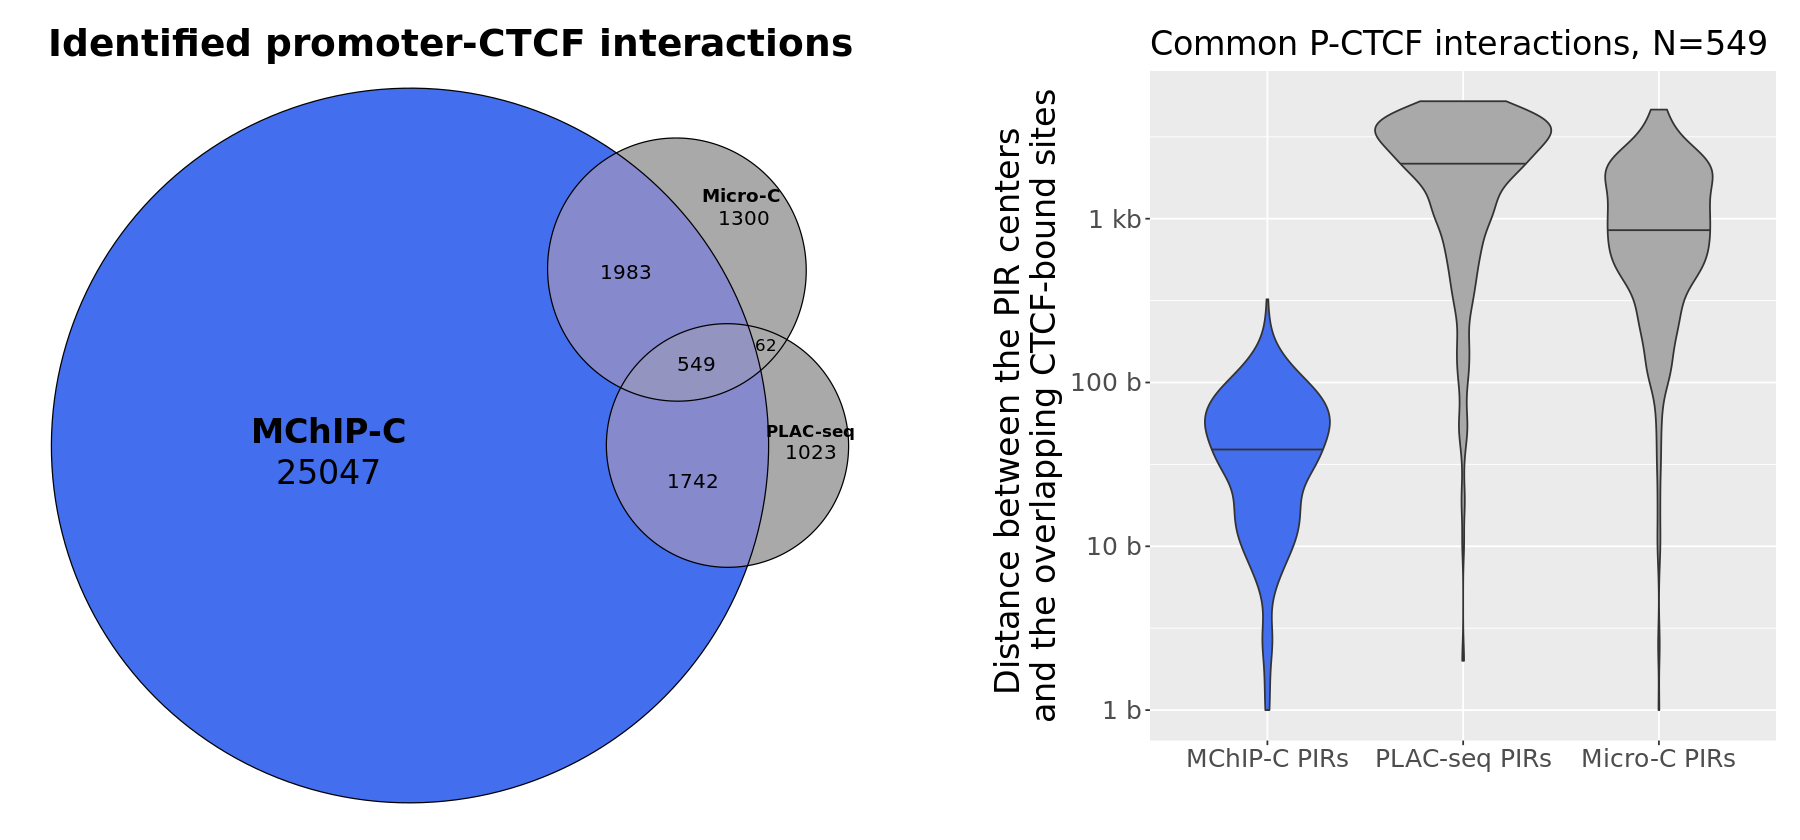

In [8]:
options(repr.plot.width=15, repr.plot.height=7)
grid.arrange(CTCF_venn, 
             dist_CTCF_violins+theme(plot.margin=unit(c(0,0.5,0,2),"cm")),
             widths=c(0.5,0.5),heights=unit(6.5,"in"), ncol=2)

In [9]:
pdf("Figures/Fig.S3/S3a_PCTCF_interactions.pdf", width=15, height=7)
grid.arrange(CTCF_venn, 
             dist_CTCF_violins+theme(plot.margin=unit(c(0,0.5,0,2),"cm")),
             widths=c(0.5,0.5),heights=unit(6.5,"in"), ncol=2)
dev.off()

png 
  2

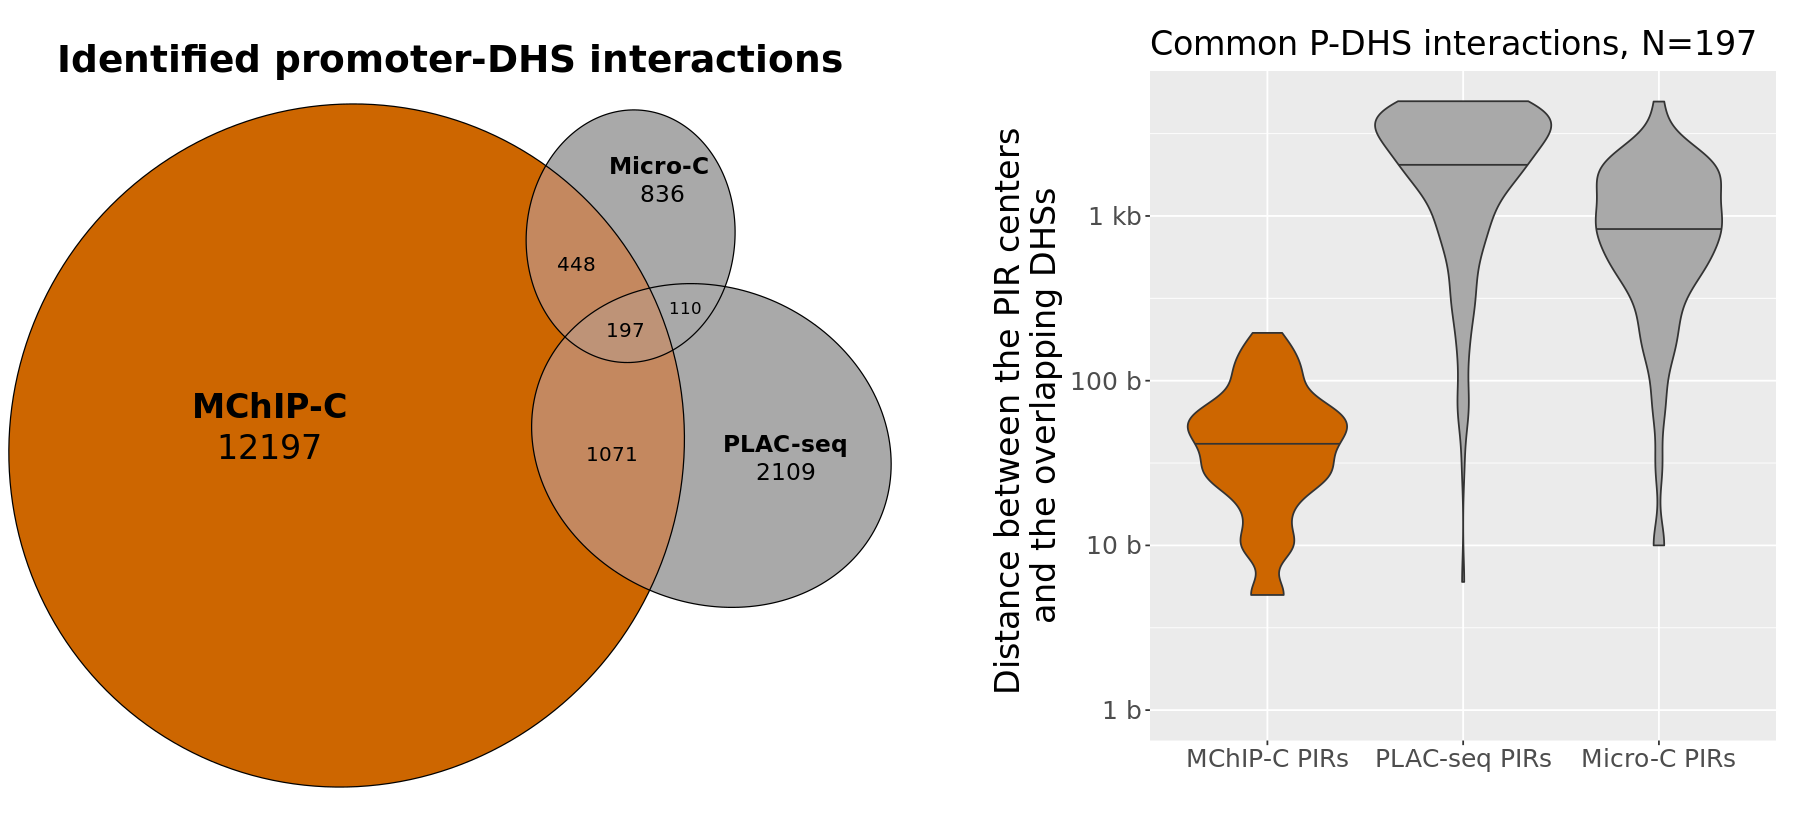

In [10]:
options(repr.plot.width=15, repr.plot.height=7)
grid.arrange(DHS_venn, 
             dist_DHS_violins+theme(plot.margin=unit(c(0,0.5,0,2),"cm")), 
             widths=c(0.5,0.5), heights=unit(6.5,"in"), ncol=2)

In [11]:
pdf("Figures/Fig.S3/S3a_PDHS_interactions.pdf", width=15, height=7)
grid.arrange(DHS_venn, 
             dist_DHS_violins+theme(plot.margin=unit(c(0,0.5,0,2),"cm")), 
             widths=c(0.5,0.5), heights=unit(6.5,"in"), ncol=2)
dev.off()

png 
  2

# Analysis and plotting of common P-CTCF / P-DHS interactions

# P-CTCF

In [12]:
rm(list=ls()[!((ls()%in%c("summary_CTCF","summary_DHS")) | grepl("_dist",ls()))])

CTCF_common <- filter(summary_CTCF, MChIPC&PLACseq&MicroC)
CTCF_vp_ranges <- GRanges(seqnames = CTCF_common$vp_chr, 
                         ranges=IRanges(start=CTCF_common$vp_start, end=CTCF_common$vp_end))

# P-CTCF in MChIP-C data
MChIPC_signal <- read.csv("MChIPC_output/MChIPC_interaction_data.txt", header = T, sep = "\t")
MChIPC_signal <- filter(MChIPC_signal, dist_rank!=0)
signal_ranges <- GRanges(seqnames = MChIPC_signal$vp_chr, 
                         ranges=IRanges(start=MChIPC_signal$vp_start, end=MChIPC_signal$vp_end))
MChIPC_signal <- MChIPC_signal[unique(as.data.frame(findOverlaps(signal_ranges, CTCF_vp_ranges))$queryHits),]
MChIPC_signal <- filter(MChIPC_signal, dist_rank>19)
signal_ranges <- GRanges(seqnames = MChIPC_signal$vp_chr, 
                         ranges=IRanges(start=MChIPC_signal$vp_start, end=MChIPC_signal$vp_end))

CTCF_heatmap <- tibble(dist_rank=seq(-19,19))
for (i in seq(nrow(CTCF_common))){
  loop <- CTCF_common[i,]
  loop_signal <- filter(MChIPC_signal, vp_chr==loop$vp_chr & vp_start==loop$vp_start & vp_end==loop$vp_end)
  loop_signal[loop_signal$vp_start > loop_signal$OE_start,]$dist_rank <- -1 * loop_signal[loop_signal$vp_start > 
                                                                                loop_signal$OE_start,]$dist_rank
  if (loop$vp_start > loop$CTCF_start) {loop_signal <- filter(loop_signal, dist_rank >
                            floor(((loop$CTCF_start+loop$CTCF_end)/2 - vp_start)/250)-20 &
                            dist_rank<floor(((loop$CTCF_start+loop$CTCF_end)/2 - vp_start)/250)+20)}
      else {loop_signal <- filter(loop_signal, dist_rank>ceiling(((loop$CTCF_start+
            loop$CTCF_end)/2 - vp_end)/250)-20 & dist_rank<ceiling(((loop$CTCF_start+
            loop$CTCF_end)/2 - vp_end)/250)+20)}
  if (loop$vp_start > loop$CTCF_start) {loop_signal$dist_rank <- loop_signal$dist_rank -
     floor(((loop$CTCF_start+loop$CTCF_end)/2 - loop_signal$vp_start)/250)} 
    else {loop_signal$dist_rank <- loop_signal$dist_rank - ceiling(((loop$CTCF_start+
          loop$CTCF_end)/2 - loop_signal$vp_end)/250)}
  loop_signal <- loop_signal[,c(21,28)]
  colnames(loop_signal)[2] <- paste0("loop_",i)
  suppressMessages({CTCF_heatmap <- left_join(CTCF_heatmap, loop_signal)})}
CTCF_heatmap[is.na(CTCF_heatmap)] <- 0
CTCF_heatmap <- as.data.frame(t(CTCF_heatmap)[2:ncol(CTCF_heatmap),])
CTCF_heatmap_MChIP <- arrange(CTCF_heatmap, rowMeans(CTCF_heatmap))
CTCF_heatmap_MChIPC <- arrange(CTCF_heatmap, rowMeans(CTCF_heatmap))
CTCF_heatmap_MChIPC[CTCF_heatmap_MChIPC>20] <- 20

CTCF_MChIPC_profile <- ggplot()+geom_line(aes(x=seq(-19,19,1),y=colMeans(CTCF_heatmap_MChIP)),size=2)+
theme_classic(base_size = 20)+xlim(-19,19) + ylim(0,32) + 
xlab("Distance from CTCF site (250 bp bins)")+ylab("MChIP-C signal")

violin_data_CTCF <- data.frame(MChIPC_CTCF_5kb=c(unlist(CTCF_heatmap[,c(1,39)])),
                          MChIPC_CTCF_1kb=c(unlist(CTCF_heatmap[,c(16,24)])),
                          MChIPC_CTCF=c(unlist(CTCF_heatmap[,c(20,20)])))
CTCF_MChIPC_violin <- ggplot(melt(violin_data_CTCF)) + 
geom_violin(aes(variable, log2(value+0.25), fill=variable), draw_quantiles=0.5)+ ylim(-2,8) +
scale_x_discrete(labels=c("Backgr. (5kb)","Backgr. (1kb)","CTCF")) + 
theme(axis.text.x = element_text(size = 18), axis.text.y = element_text(size = 20),text=element_text(size=20),
     plot.title=element_text(size=20)) +
labs(y="Signal in 250bp bin (log2)",x="") + 
scale_fill_manual(values=c("darkgrey","lightsteelblue1","royalblue2"))+
ggtitle(paste0("MChIP-C signal around common\npromoter-interacting CTCF-sites, N=",length(MChIPC_CTCF_dist)))+ guides(fill=FALSE)
rm(MChIPC_signal)

# P-CTCF in PLAC-seq data
PLACseq_signal <- read.csv("PLACseq_output/PLACseq.signal.df.txt", header = F, sep = "\t")
PLACseq_signal$V7 <- as.numeric(gsub(",",".",PLACseq_signal$V7))
colnames(PLACseq_signal) <- c("vp_chr","vp_start","vp_end","OE_chr","OE_start","OE_end","N_sum")
signal_ranges <- GRanges(seqnames = PLACseq_signal$vp_chr, 
                         ranges=IRanges(start=PLACseq_signal$vp_start, end=PLACseq_signal$vp_end))
PLACseq_signal <- PLACseq_signal[unique(as.data.frame(findOverlaps(signal_ranges, CTCF_vp_ranges))$queryHits),]
PLACseq_signal$dist_rank <- 0
PLACseq_signal$dist_rank[PLACseq_signal$vp_start>PLACseq_signal$OE_start]<-(PLACseq_signal$vp_start[PLACseq_signal$vp_start>PLACseq_signal$OE_start]- 
                                                            PLACseq_signal$OE_start[PLACseq_signal$vp_start>PLACseq_signal$OE_start])/250
PLACseq_signal$dist_rank[PLACseq_signal$vp_end<PLACseq_signal$OE_start]<-(PLACseq_signal$OE_end[PLACseq_signal$vp_end<PLACseq_signal$OE_start]- 
                                                            PLACseq_signal$vp_end[PLACseq_signal$vp_end<PLACseq_signal$OE_start])/250
PLACseq_signal <- filter(PLACseq_signal, dist_rank>19)
signal_ranges <- GRanges(seqnames = PLACseq_signal$vp_chr, 
                         ranges=IRanges(start=PLACseq_signal$vp_start, end=PLACseq_signal$vp_end))

CTCF_heatmap <- tibble(dist_rank=seq(-19,19))
for (i in seq(nrow(CTCF_common))){
  loop <- CTCF_common[i,]
  loop_signal <- filter(PLACseq_signal, vp_chr==loop$vp_chr & vp_start==loop$vp_start & vp_end==loop$vp_end)
  loop_signal[loop_signal$vp_start > loop_signal$OE_start,]$dist_rank <- -1 * loop_signal[loop_signal$vp_start > 
                                                                                loop_signal$OE_start,]$dist_rank
  if (loop$vp_start > loop$CTCF_start) {loop_signal <- filter(loop_signal, dist_rank >
                            floor(((loop$CTCF_start+loop$CTCF_end)/2 - vp_start)/250)-20 &
                            dist_rank<floor(((loop$CTCF_start+loop$CTCF_end)/2 - vp_start)/250)+20)}
      else {loop_signal <- filter(loop_signal, dist_rank>ceiling(((loop$CTCF_start+
            loop$CTCF_end)/2 - vp_end)/250)-20 & dist_rank<ceiling(((loop$CTCF_start+
            loop$CTCF_end)/2 - vp_end)/250)+20)}
  if (loop$vp_start > loop$CTCF_start) {loop_signal$dist_rank <- loop_signal$dist_rank -
     floor(((loop$CTCF_start+loop$CTCF_end)/2 - loop_signal$vp_start)/250)} 
    else {loop_signal$dist_rank <- loop_signal$dist_rank - ceiling(((loop$CTCF_start+
          loop$CTCF_end)/2 - loop_signal$vp_end)/250)}
  loop_signal <- loop_signal[,c(8,7)]
  colnames(loop_signal)[2] <- paste0("loop_",i)
  suppressMessages({CTCF_heatmap <- left_join(CTCF_heatmap, loop_signal)})}
CTCF_heatmap[is.na(CTCF_heatmap)] <- 0
CTCF_heatmap <- as.data.frame(t(CTCF_heatmap)[2:ncol(CTCF_heatmap),])
CTCF_heatmap_PLAC <- arrange(CTCF_heatmap, rowMeans(CTCF_heatmap))
CTCF_heatmap_PLACseq <- arrange(CTCF_heatmap, rowMeans(CTCF_heatmap))
CTCF_heatmap_PLACseq[CTCF_heatmap_PLACseq>20] <- 20

CTCF_PLACseq_profile <- ggplot()+geom_line(aes(x=seq(-19,19,1),y=colMeans(CTCF_heatmap_PLAC)),size=2)+
theme_classic(base_size = 20)+xlim(-19,19) + ylim(0,32)+
xlab("Distance from CTCF site (250bp bins)")+ylab("PLAC-seq signal")

violin_data_CTCF <- violin_data_CTCF %>% mutate(PLACseq_CTCF_5kb=c(unlist(CTCF_heatmap[,c(1,39)])),
                          PLACseq_CTCF_1kb=c(unlist(CTCF_heatmap[,c(16,24)])),
                          PLACseq_CTCF=c(unlist(CTCF_heatmap[,c(20,20)])))
CTCF_PLACseq_violin <- ggplot(melt(violin_data_CTCF[,4:6])) + 
geom_violin(aes(variable, log2(value+0.25), fill=variable), draw_quantiles=0.5)+ ylim(-2,8) +
scale_x_discrete(labels=c("Backgr. (5kb)","Backgr. (1kb)","CTCF")) + 
theme(axis.text.x = element_text(size = 18), axis.text.y = element_text(size = 20),text=element_text(size=20),
     plot.title=element_text(size=20)) +
labs(y="Signal in 250bp bin (log2)",x="") + 
scale_fill_manual(values=c("darkgrey","lightsteelblue1","royalblue2"))+
ggtitle(paste0("PLAC-seq signal around common\npromoter-interacting CTCF-sites, N=",length(MChIPC_CTCF_dist)))+ guides(fill=FALSE)
rm(PLACseq_signal)

# P-CTCF in Micro-C data
MicroC_signal <- read.csv("MicroC_output/MicroC.signal.df.txt", header = F, sep = "\t") %>% filter(V1!="")
colnames(MicroC_signal) <- c("vp_chr","vp_start","vp_end","OE_chr","OE_start","OE_end","N_sum", "N_sum_ICE")
signal_ranges <- GRanges(seqnames = MicroC_signal$vp_chr, 
                         ranges=IRanges(start=MicroC_signal$vp_start, end=MicroC_signal$vp_end))
MicroC_signal <- MicroC_signal[unique(as.data.frame(findOverlaps(signal_ranges, CTCF_vp_ranges))$queryHits),]
MicroC_signal$dist_rank <- 0
MicroC_signal$dist_rank[MicroC_signal$vp_start>MicroC_signal$OE_start]<-(MicroC_signal$vp_start[MicroC_signal$vp_start>MicroC_signal$OE_start]- 
                                                            MicroC_signal$OE_start[MicroC_signal$vp_start>MicroC_signal$OE_start])/250
MicroC_signal$dist_rank[MicroC_signal$vp_end<MicroC_signal$OE_start]<-(MicroC_signal$OE_end[MicroC_signal$vp_end<MicroC_signal$OE_start]- 
                                                            MicroC_signal$vp_end[MicroC_signal$vp_end<MicroC_signal$OE_start])/250
MicroC_signal <- filter(MicroC_signal, dist_rank>19)
signal_ranges <- GRanges(seqnames = MicroC_signal$vp_chr, 
                         ranges=IRanges(start=MicroC_signal$vp_start, end=MicroC_signal$vp_end))

CTCF_heatmap <- tibble(dist_rank=seq(-19,19))
CTCF_heatmap_ICE <- tibble(dist_rank=seq(-19,19))
for (i in seq(nrow(CTCF_common))){
  loop <- CTCF_common[i,]
  loop_signal <- filter(MicroC_signal, vp_chr==loop$vp_chr & vp_start==loop$vp_start & vp_end==loop$vp_end)
  loop_signal[loop_signal$vp_start > loop_signal$OE_start,]$dist_rank <- -1 * loop_signal[loop_signal$vp_start > 
                                                                                loop_signal$OE_start,]$dist_rank
  if (loop$vp_start > loop$CTCF_start) {loop_signal <- filter(loop_signal, dist_rank >
                            floor(((loop$CTCF_start+loop$CTCF_end)/2 - vp_start)/250)-20 &
                            dist_rank<floor(((loop$CTCF_start+loop$CTCF_end)/2 - vp_start)/250)+20)}
      else {loop_signal <- filter(loop_signal, dist_rank>ceiling(((loop$CTCF_start+
            loop$CTCF_end)/2 - vp_end)/250)-20 & dist_rank<ceiling(((loop$CTCF_start+
            loop$CTCF_end)/2 - vp_end)/250)+20)}
  if (loop$vp_start > loop$CTCF_start) {loop_signal$dist_rank <- loop_signal$dist_rank -
     floor(((loop$CTCF_start+loop$CTCF_end)/2 - loop_signal$vp_start)/250)} 
    else {loop_signal$dist_rank <- loop_signal$dist_rank - ceiling(((loop$CTCF_start+
          loop$CTCF_end)/2 - loop_signal$vp_end)/250)}
  loop_signal_n <- loop_signal[,c(9,7)]
  loop_signal_ICE <- loop_signal[,c(9,8)]
  colnames(loop_signal_n)[2] <- paste0("loop_",i)
  colnames(loop_signal_ICE)[2] <- paste0("loop_",i)
  suppressMessages({CTCF_heatmap <- left_join(CTCF_heatmap, loop_signal_n)})
  suppressMessages({CTCF_heatmap_ICE <- left_join(CTCF_heatmap_ICE, loop_signal_ICE)})}
CTCF_heatmap[is.na(CTCF_heatmap)] <- 0
CTCF_heatmap_ICE[is.na(CTCF_heatmap_ICE)] <- 0
CTCF_heatmap <- as.data.frame(t(CTCF_heatmap)[2:ncol(CTCF_heatmap),])
CTCF_heatmap_ICE <- 1000*as.data.frame(t(CTCF_heatmap_ICE)[2:ncol(CTCF_heatmap_ICE),])
CTCF_heatmap_ICEM <- arrange(CTCF_heatmap_ICE, rowMeans(CTCF_heatmap_ICE))
CTCF_heatmap_MicroC <- arrange(CTCF_heatmap, rowMeans(CTCF_heatmap))
CTCF_heatmap_ICEM[CTCF_heatmap_ICEM>20] <- 20
CTCF_heatmap_MicroC[CTCF_heatmap_MicroC>20] <- 20

CTCF_MicroC_profile <- ggplot()+geom_line(aes(x=seq(-19,19,1),y=colMeans(CTCF_heatmap)),size=2)+
geom_line(aes(x=seq(-19,19,1),y=colMeans(CTCF_heatmap_ICE)),size=4, color="grey")+
theme_classic(base_size = 20)+xlim(-19,19) + ylim(0,32) +
xlab("Distance from CTCF site (250 bp bins)")+ylab("Micro-C signal")

violin_data_CTCF <- violin_data_CTCF %>% mutate(MicroC_CTCF_5kb=c(unlist(CTCF_heatmap[,c(1,39)])),
                          MicroC_CTCF_1kb=c(unlist(CTCF_heatmap[,c(16,24)])),
                          MicroC_CTCF=c(unlist(CTCF_heatmap[,c(20,20)])))
CTCF_MicroC_violin <- ggplot(melt(violin_data_CTCF[,7:9])) + 
geom_violin(aes(variable, log2(value+0.25), fill=variable), draw_quantiles=0.5)+ ylim(-2,8) +
scale_x_discrete(labels=c("Backgr. (5kb)","Backgr. (1kb)","CTCF")) + 
theme(axis.text.x = element_text(size = 18), axis.text.y = element_text(size = 20),text=element_text(size=20),
     plot.title=element_text(size=20)) +
labs(y="Signal in 250bp bin (log2)",x="") + 
scale_fill_manual(values=c("darkgrey","lightsteelblue1","royalblue2"))+
ggtitle(paste0("Micro-C signal around common\npromoter-interacting CTCF-sites, N=",length(MChIPC_CTCF_dist)))+ guides(fill=FALSE)

violin_data_CTCF <- violin_data_CTCF %>% mutate(MicroC_CTCF_ICE_5kb=c(unlist(CTCF_heatmap_ICE[,c(1,39)])),
                          MicroC_CTCF_ICE_1kb=c(unlist(CTCF_heatmap_ICE[,c(16,24)])),
                          MicroC_CTCF_ICE=c(unlist(CTCF_heatmap_ICE[,c(20,20)])))
CTCF_MicroC_ICE_violin <- ggplot(melt(violin_data_CTCF[,10:12])) + 
geom_violin(aes(variable, log2(value+0.25), fill=variable), draw_quantiles=0.5)+ ylim(-2,8) +
scale_x_discrete(labels=c("Backgr. (5kb)","Backgr. (1kb)","CTCF")) + 
theme(axis.text.x = element_text(size = 18), axis.text.y = element_text(size = 20),text=element_text(size=20),
     plot.title=element_text(size=20)) +
labs(y="Signal in 250bp bin (log2)",x="") + 
scale_fill_manual(values=c("darkgrey","lightsteelblue1","royalblue2"))+
ggtitle(paste0("Micro-C (ICE) signal around common\npromoter-interacting CTCF-sites, N=",length(MChIPC_CTCF_dist)))+ guides(fill=FALSE)
rm(MicroC_signal)

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables



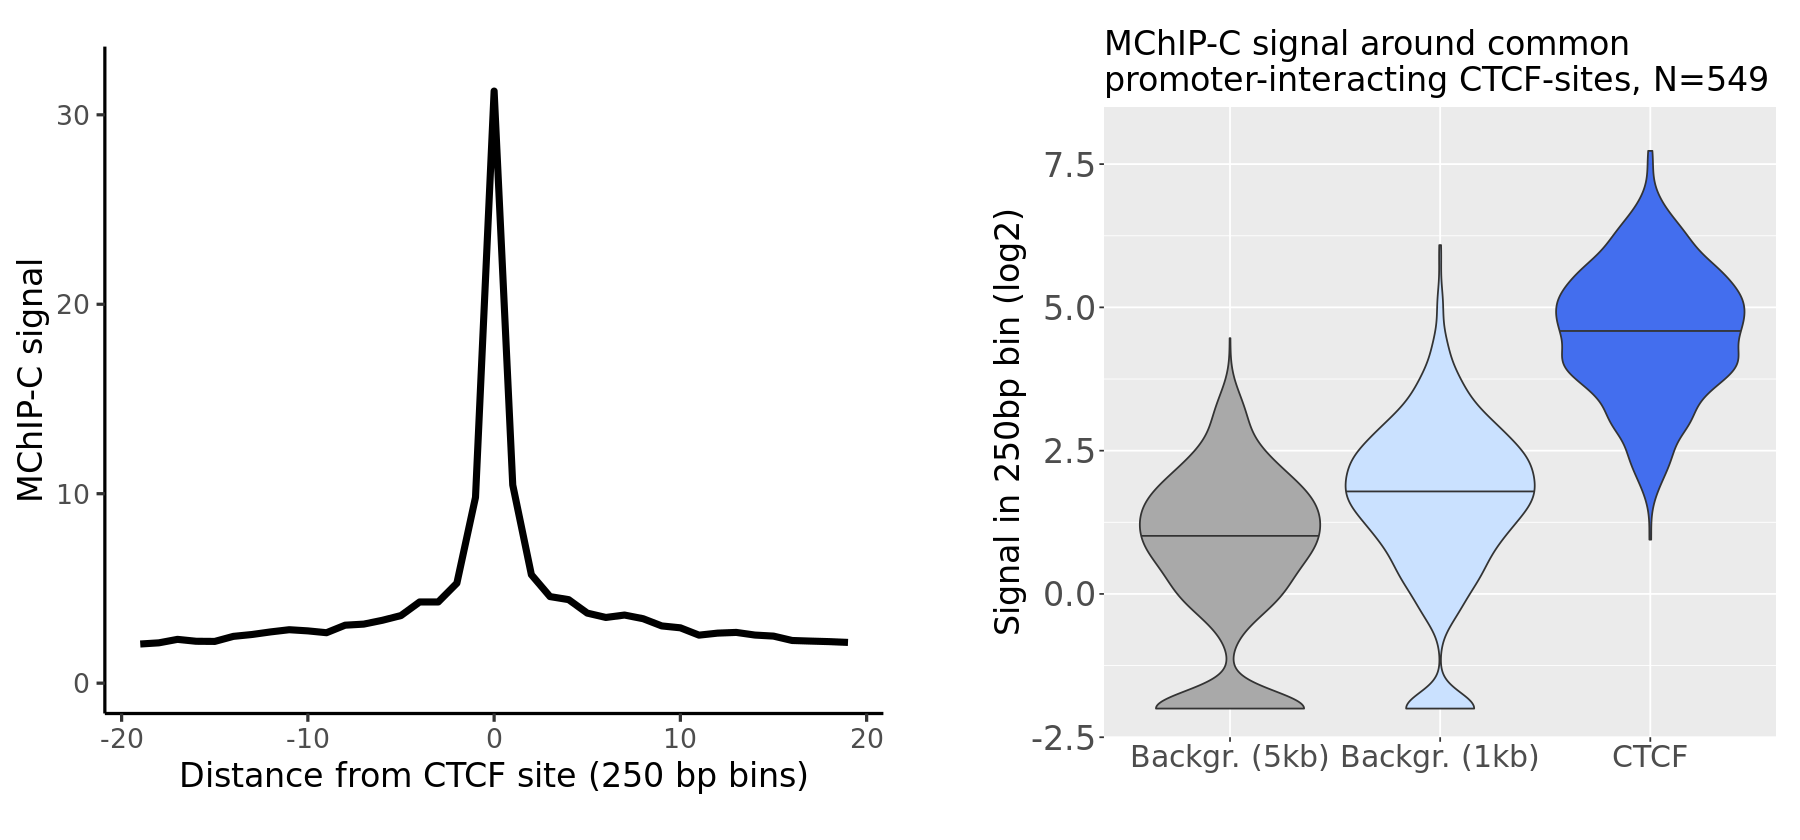

In [13]:
options(repr.plot.width=15, repr.plot.height=7)
grid.arrange(CTCF_MChIPC_profile, 
             CTCF_MChIPC_violin+theme(plot.margin=unit(c(0,0.5,0,2),"cm")),
             widths=c(0.5,0.5), heights=unit(6.5,"in"), ncol=2)

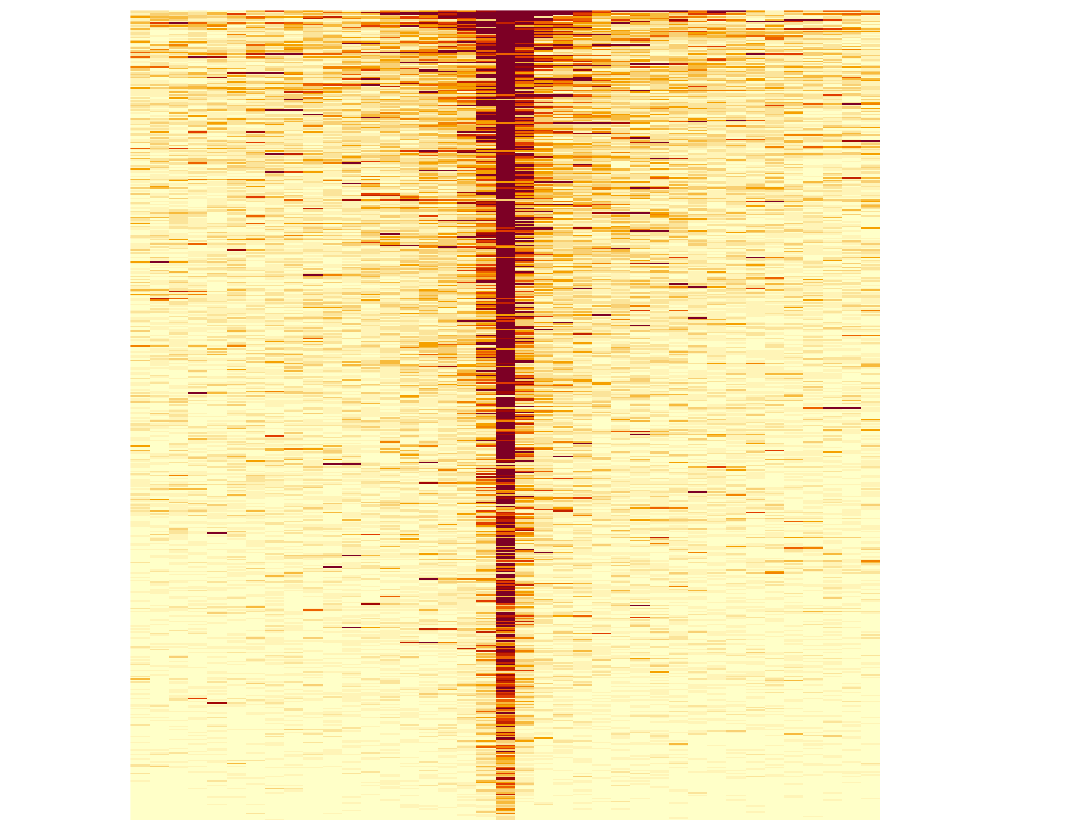

In [14]:
options(repr.plot.width=9, repr.plot.height=7)
heatmap(as.matrix(CTCF_heatmap_MChIPC), Colv=NA, Rowv=NA, scale="none", labRow=FALSE, labCol=FALSE, margins = c(1, 4))

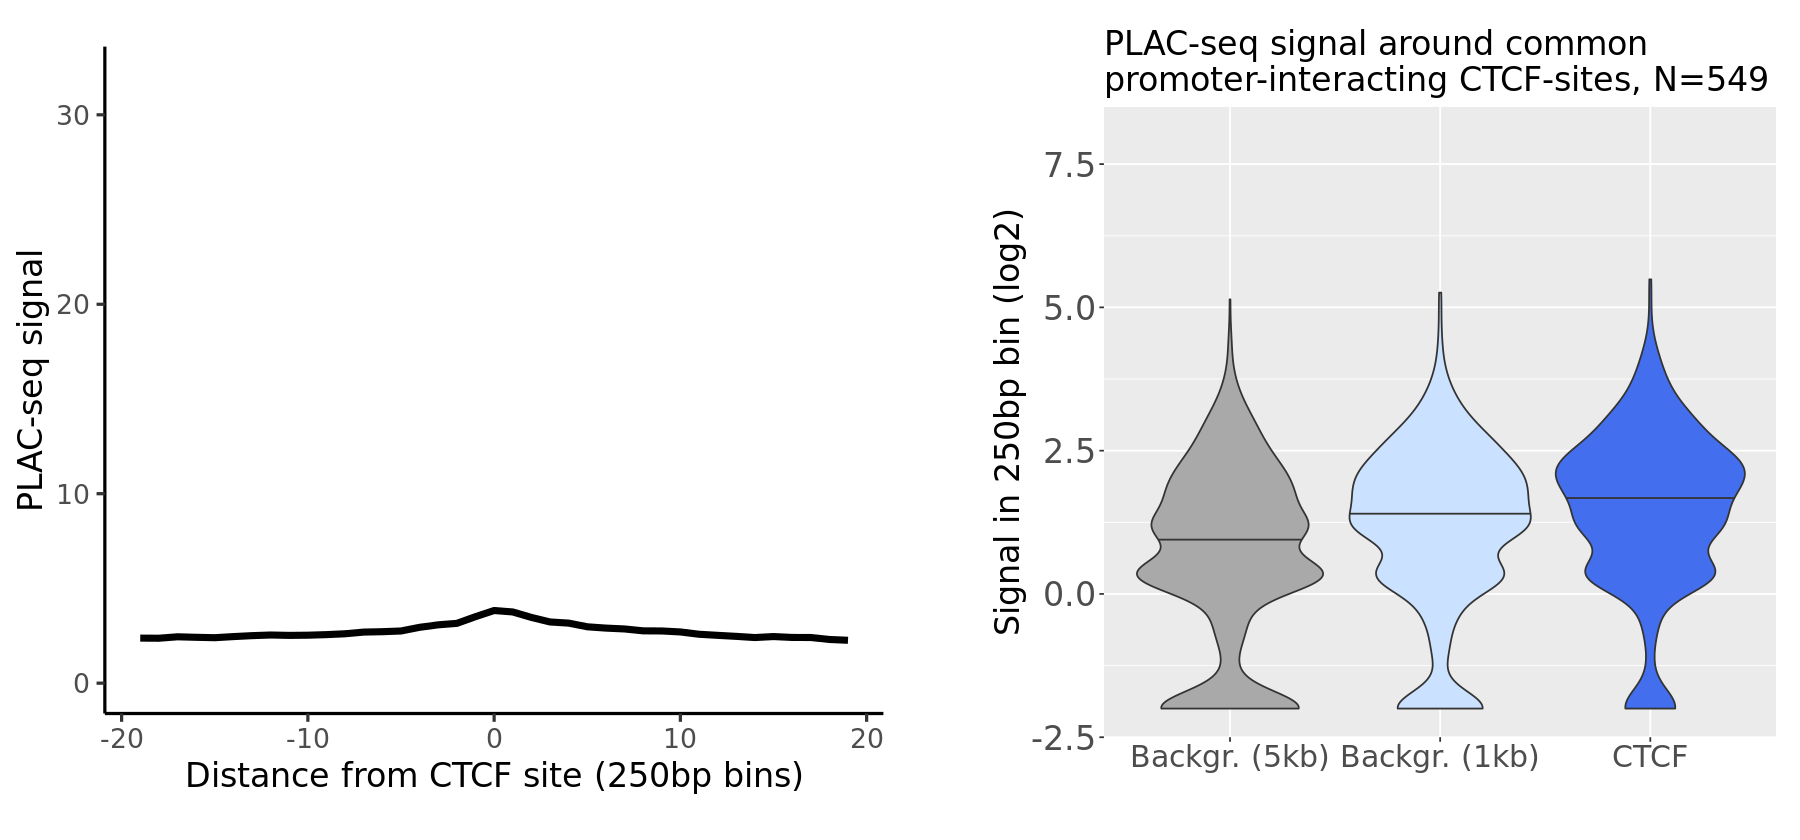

In [15]:
options(repr.plot.width=15, repr.plot.height=7)
grid.arrange(CTCF_PLACseq_profile, 
             CTCF_PLACseq_violin+theme(plot.margin=unit(c(0,0.5,0,2),"cm")),
             widths=c(0.5,0.5), heights=unit(6.5,"in"), ncol=2)

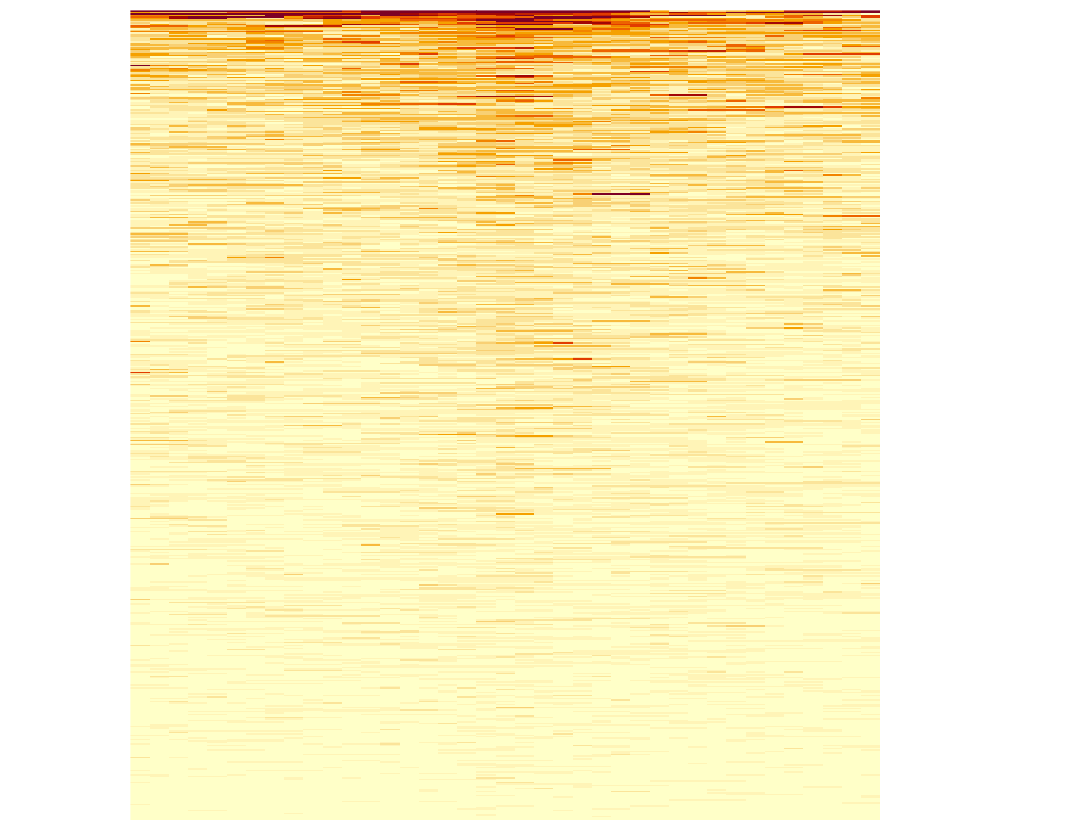

In [16]:
options(repr.plot.width=9, repr.plot.height=7)
heatmap(as.matrix(CTCF_heatmap_PLACseq), Colv=NA, Rowv=NA, scale="none", labRow=FALSE, labCol=FALSE, margins = c(1, 4))

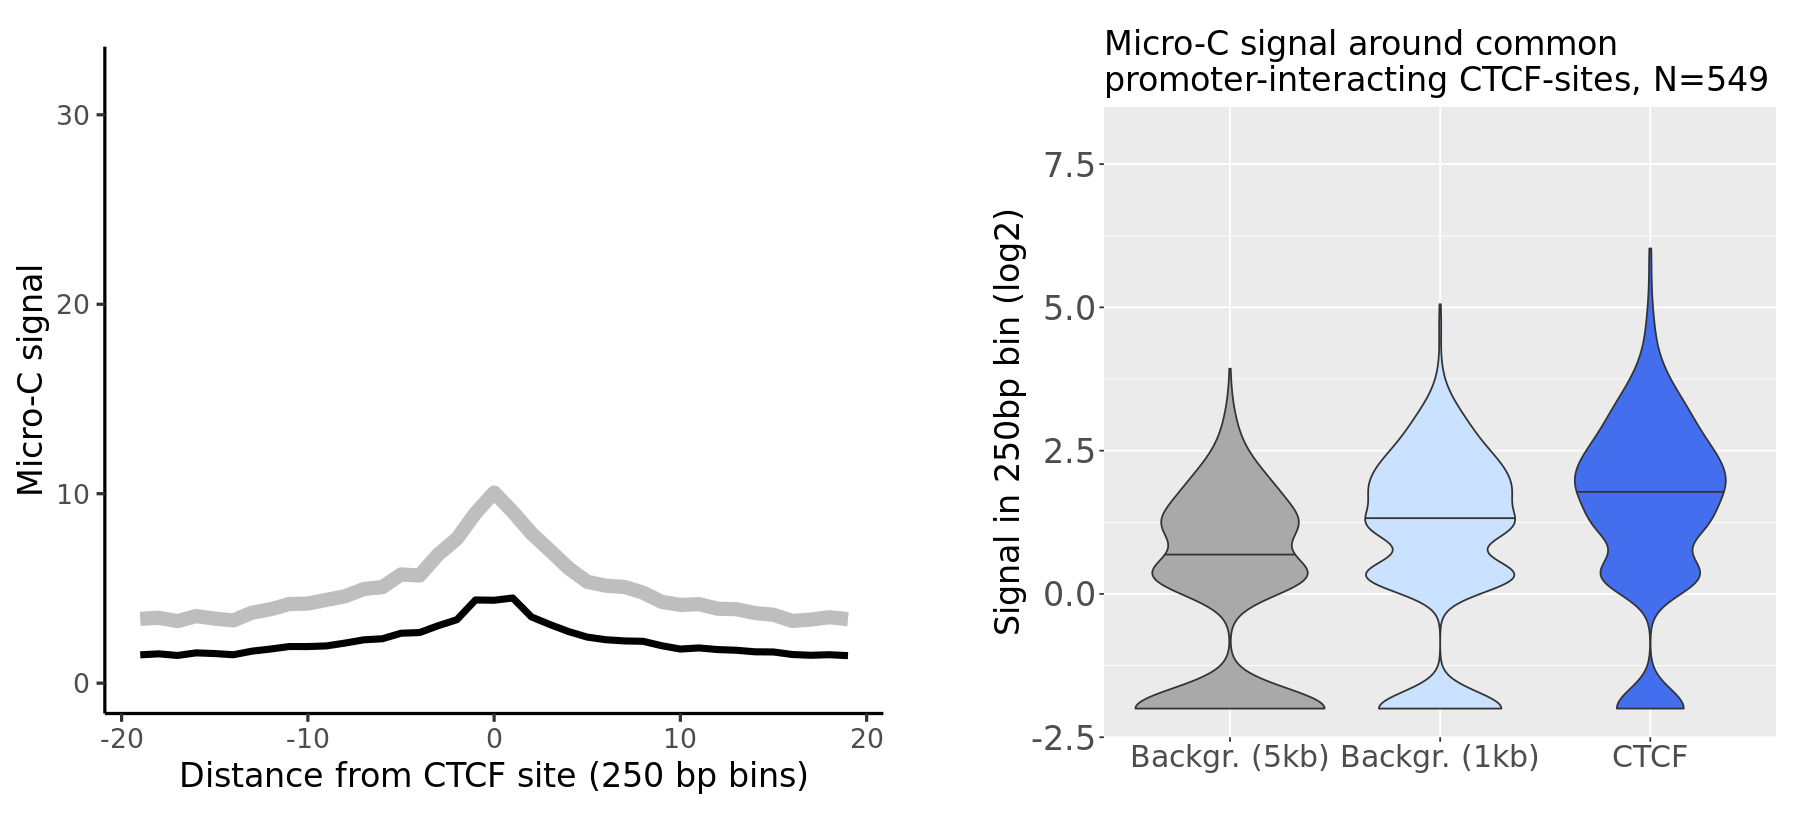

In [17]:
options(repr.plot.width=15, repr.plot.height=7)
grid.arrange(CTCF_MicroC_profile, 
             CTCF_MicroC_violin+theme(plot.margin=unit(c(0,0.5,0,2),"cm")),
             widths=c(0.5,0.5), heights=unit(6.5,"in"), ncol=2)

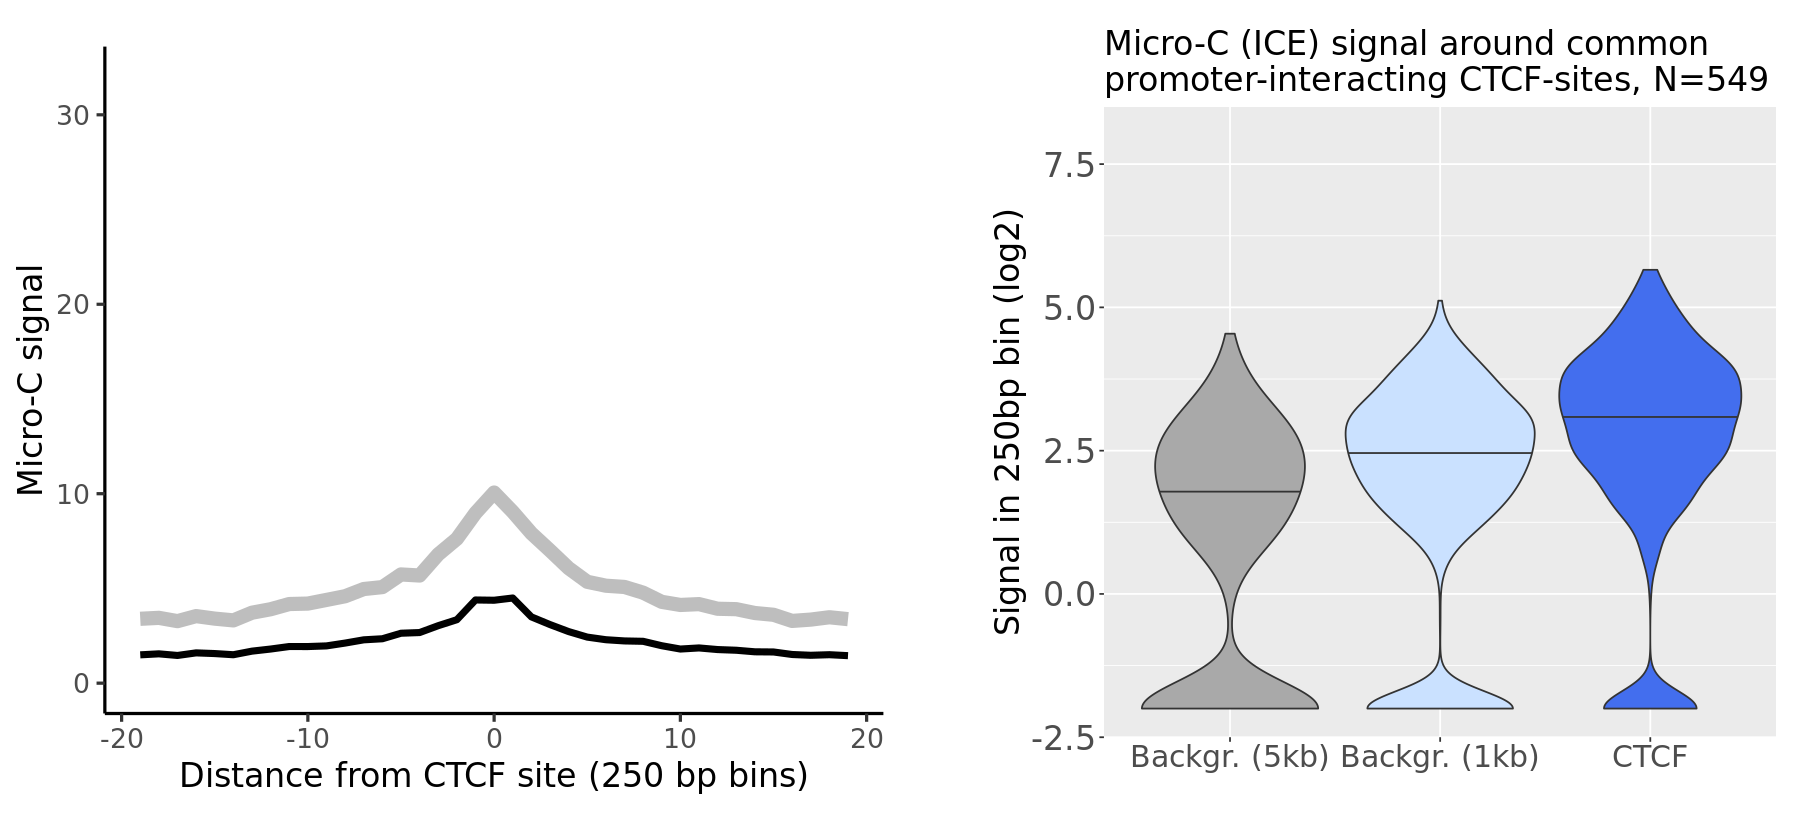

In [18]:
grid.arrange(CTCF_MicroC_profile, 
             CTCF_MicroC_ICE_violin+theme(plot.margin=unit(c(0,0.5,0,2),"cm")),
             widths=c(0.5,0.5), heights=unit(6.5,"in"), ncol=2)

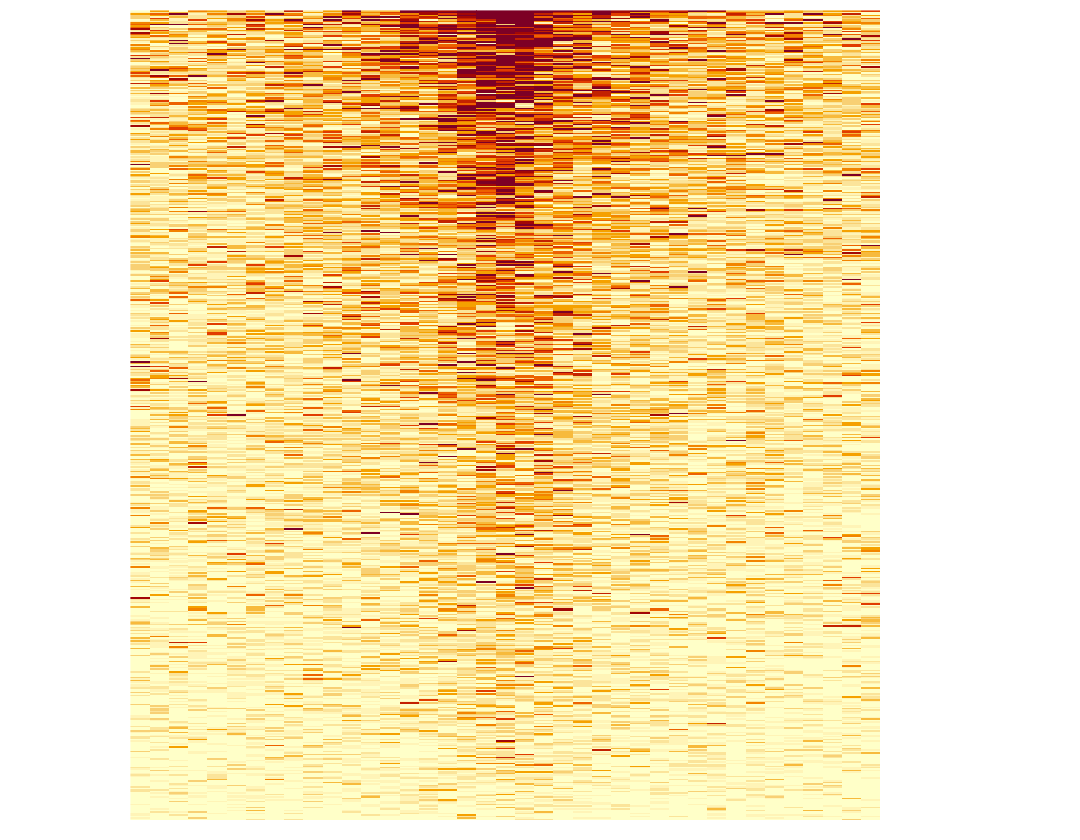

In [19]:
options(repr.plot.width=9, repr.plot.height=7)
heatmap(as.matrix(CTCF_heatmap_ICEM), Colv=NA, Rowv=NA, scale="none", labRow=FALSE, labCol=FALSE, margins = c(1, 4))

In [20]:
# saving plots
pdf("Figures/Fig.S3/S3b_common_CTCF_MChIPC.pdf", width=15, height=7)
grid.arrange(CTCF_MChIPC_profile, 
             CTCF_MChIPC_violin+theme(plot.margin=unit(c(0,0.5,0,2),"cm")),
             widths=c(0.5,0.5), heights=unit(6.5,"in"), ncol=2)
dev.off()

pdf("Figures/Fig.S3/S3b_common_CTCF_PLACseq.pdf", width=15, height=7)
grid.arrange(CTCF_PLACseq_profile, 
             CTCF_PLACseq_violin+theme(plot.margin=unit(c(0,0.5,0,2),"cm")),
             widths=c(0.5,0.5), heights=unit(6.5,"in"), ncol=2)
dev.off()

pdf("Figures/Fig.S3/S3b_common_CTCF_MicroC.pdf", width=15, height=7)
grid.arrange(CTCF_MicroC_profile, 
             CTCF_MicroC_violin+theme(plot.margin=unit(c(0,0.5,0,2),"cm")),
             widths=c(0.5,0.5), heights=unit(6.5,"in"), ncol=2)
dev.off()

pdf("Figures/Fig.S3/S3b_common_CTCF_MicroC_ICE.pdf", width=15, height=7)
grid.arrange(CTCF_MicroC_profile, 
             CTCF_MicroC_ICE_violin+theme(plot.margin=unit(c(0,0.5,0,2),"cm")),
             widths=c(0.5,0.5), heights=unit(6.5,"in"), ncol=2)
dev.off()

pdf("Figures/Fig.S3/S3b_common_CTCF_MChIPC_heatmap.pdf", width=9, height=7)
heatmap(as.matrix(CTCF_heatmap_MChIPC), Colv=NA, Rowv=NA, scale="none", labRow=FALSE, labCol=FALSE, margins = c(1, 4))
dev.off()

pdf("Figures/Fig.S3/S3b_common_CTCF_PLACseq_heatmap.pdf", width=9, height=7)
heatmap(as.matrix(CTCF_heatmap_PLACseq), Colv=NA, Rowv=NA, scale="none", labRow=FALSE, labCol=FALSE, margins = c(1, 4))
dev.off()

pdf("Figures/Fig.S3/S3b_common_CTCF_MicroC_heatmap.pdf", width=9, height=7)
heatmap(as.matrix(CTCF_heatmap_ICEM), Colv=NA, Rowv=NA, scale="none", labRow=FALSE, labCol=FALSE, margins = c(1, 4))
dev.off()

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

# P-DHS

In [21]:
rm(list=ls()[!((ls()%in%c("summary_CTCF","summary_DHS")) | grepl("_dist",ls()))])
DHS_common <- filter(summary_DHS, MChIPC&PLACseq&MicroC)
DHS_vp_ranges <- GRanges(seqnames = DHS_common$vp_chr, 
                         ranges=IRanges(start=DHS_common$vp_start, end=DHS_common$vp_end))

# P-DHS in MChIP-C data
MChIPC_signal <- read.csv("MChIPC_output/MChIPC_interaction_data.txt", header = T, sep = "\t")
MChIPC_signal <- filter(MChIPC_signal, dist_rank!=0)
signal_ranges <- GRanges(seqnames = MChIPC_signal$vp_chr, 
                         ranges=IRanges(start=MChIPC_signal$vp_start, end=MChIPC_signal$vp_end))
MChIPC_signal <- MChIPC_signal[unique(as.data.frame(findOverlaps(signal_ranges, DHS_vp_ranges))$queryHits),]
MChIPC_signal <- filter(MChIPC_signal, dist_rank>19)
signal_ranges <- GRanges(seqnames = MChIPC_signal$vp_chr, 
                         ranges=IRanges(start=MChIPC_signal$vp_start, end=MChIPC_signal$vp_end))

DHS_heatmap <- tibble(dist_rank=seq(-19,19))
for (i in seq(nrow(DHS_common))){
  loop <- DHS_common[i,]
  loop_signal <- filter(MChIPC_signal, vp_chr==loop$vp_chr & vp_start==loop$vp_start & vp_end==loop$vp_end)
  loop_signal[loop_signal$vp_start > loop_signal$OE_start,]$dist_rank <- -1 * loop_signal[loop_signal$vp_start > 
                                                                                loop_signal$OE_start,]$dist_rank
  if (loop$vp_start > loop$DHS_start) {loop_signal <- filter(loop_signal, dist_rank >
                            floor(((loop$DHS_start+loop$DHS_end)/2 - vp_start)/250)-20 &
                            dist_rank<floor(((loop$DHS_start+loop$DHS_end)/2 - vp_start)/250)+20)}
      else {loop_signal <- filter(loop_signal, dist_rank>ceiling(((loop$DHS_start+
            loop$DHS_end)/2 - vp_end)/250)-20 & dist_rank<ceiling(((loop$DHS_start+
            loop$DHS_end)/2 - vp_end)/250)+20)}
  if (loop$vp_start > loop$DHS_start) {loop_signal$dist_rank <- loop_signal$dist_rank -
     floor(((loop$DHS_start+loop$DHS_end)/2 - loop_signal$vp_start)/250)} 
    else {loop_signal$dist_rank <- loop_signal$dist_rank - ceiling(((loop$DHS_start+
          loop$DHS_end)/2 - loop_signal$vp_end)/250)}
  loop_signal <- loop_signal[,c(21,28)]
  colnames(loop_signal)[2] <- paste0("loop_",i)
  suppressMessages({DHS_heatmap <- left_join(DHS_heatmap, loop_signal)})}
DHS_heatmap[is.na(DHS_heatmap)] <- 0
DHS_heatmap <- as.data.frame(t(DHS_heatmap)[2:ncol(DHS_heatmap),])
DHS_heatmap_MChIP <- arrange(DHS_heatmap, rowMeans(DHS_heatmap))
DHS_heatmap_MChIPC <- arrange(DHS_heatmap, rowMeans(DHS_heatmap))
DHS_heatmap_MChIPC[DHS_heatmap_MChIPC>20] <- 20

DHS_MChIPC_profile <- ggplot()+geom_line(aes(x=seq(-19,19,1),y=colMeans(DHS_heatmap_MChIP)),size=2)+
theme_classic(base_size = 20)+xlim(-19,19) + ylim(0,15) + 
xlab("Distance from DHS (250 bp bins)")+ylab("MChIP-C signal")

violin_data_DHS <- data.frame(MChIPC_DHS_5kb=c(unlist(DHS_heatmap[,c(1,39)])),
                          MChIPC_DHS_1kb=c(unlist(DHS_heatmap[,c(16,24)])),
                          MChIPC_DHS=c(unlist(DHS_heatmap[,c(20,20)])))
DHS_MChIPC_violin <- ggplot(melt(violin_data_DHS)) + 
geom_violin(aes(variable, log2(value), fill=variable), draw_quantiles=0.5)+ ylim(-2,6) +
scale_x_discrete(labels=c("Backgr. (5kb)","Backgr. (1kb)","DHS")) + 
theme(axis.text.x = element_text(size = 18), axis.text.y = element_text(size = 20),text=element_text(size=20),
     plot.title=element_text(size=20)) +
labs(y="Signal in 250bp bin (log2)",x="") + 
scale_fill_manual(values=c("darkgrey","tan","darkorange3"))+
ggtitle(paste0("MChIP-C signal around common\npromoter-interacting DHSs, N=",length(MChIPC_DHS_dist)))+ guides(fill=FALSE)

# P-DHS in PLAC-seq data
PLACseq_signal <- read.csv("PLACseq_output/PLACseq.signal.df.txt", header = F, sep = "\t")
PLACseq_signal$V7 <- as.numeric(gsub(",",".",PLACseq_signal$V7))
colnames(PLACseq_signal) <- c("vp_chr","vp_start","vp_end","OE_chr","OE_start","OE_end","N_sum")
signal_ranges <- GRanges(seqnames = PLACseq_signal$vp_chr, 
                         ranges=IRanges(start=PLACseq_signal$vp_start, end=PLACseq_signal$vp_end))
PLACseq_signal <- PLACseq_signal[unique(as.data.frame(findOverlaps(signal_ranges, DHS_vp_ranges))$queryHits),]
PLACseq_signal$dist_rank <- 0
PLACseq_signal$dist_rank[PLACseq_signal$vp_start>PLACseq_signal$OE_start]<-(PLACseq_signal$vp_start[PLACseq_signal$vp_start>PLACseq_signal$OE_start]- 
                                                            PLACseq_signal$OE_start[PLACseq_signal$vp_start>PLACseq_signal$OE_start])/250
PLACseq_signal$dist_rank[PLACseq_signal$vp_end<PLACseq_signal$OE_start]<-(PLACseq_signal$OE_end[PLACseq_signal$vp_end<PLACseq_signal$OE_start]- 
                                                            PLACseq_signal$vp_end[PLACseq_signal$vp_end<PLACseq_signal$OE_start])/250
PLACseq_signal <- filter(PLACseq_signal, dist_rank>19)
signal_ranges <- GRanges(seqnames = PLACseq_signal$vp_chr, 
                         ranges=IRanges(start=PLACseq_signal$vp_start, end=PLACseq_signal$vp_end))

DHS_heatmap <- tibble(dist_rank=seq(-19,19))
for (i in seq(nrow(DHS_common))){
  loop <- DHS_common[i,]
  loop_signal <- filter(PLACseq_signal, vp_chr==loop$vp_chr & vp_start==loop$vp_start & vp_end==loop$vp_end)
  loop_signal[loop_signal$vp_start > loop_signal$OE_start,]$dist_rank <- -1 * loop_signal[loop_signal$vp_start > 
                                                                                loop_signal$OE_start,]$dist_rank
  if (loop$vp_start > loop$DHS_start) {loop_signal <- filter(loop_signal, dist_rank >
                            floor(((loop$DHS_start+loop$DHS_end)/2 - vp_start)/250)-20 &
                            dist_rank<floor(((loop$DHS_start+loop$DHS_end)/2 - vp_start)/250)+20)}
      else {loop_signal <- filter(loop_signal, dist_rank>ceiling(((loop$DHS_start+
            loop$DHS_end)/2 - vp_end)/250)-20 & dist_rank<ceiling(((loop$DHS_start+
            loop$DHS_end)/2 - vp_end)/250)+20)}
  if (loop$vp_start > loop$DHS_start) {loop_signal$dist_rank <- loop_signal$dist_rank -
     floor(((loop$DHS_start+loop$DHS_end)/2 - loop_signal$vp_start)/250)} 
    else {loop_signal$dist_rank <- loop_signal$dist_rank - ceiling(((loop$DHS_start+
          loop$DHS_end)/2 - loop_signal$vp_end)/250)}
  loop_signal <- loop_signal[,c(8,7)]
  colnames(loop_signal)[2] <- paste0("loop_",i)
  suppressMessages({DHS_heatmap <- left_join(DHS_heatmap, loop_signal)})}
DHS_heatmap[is.na(DHS_heatmap)] <- 0
DHS_heatmap <- as.data.frame(t(DHS_heatmap)[2:ncol(DHS_heatmap),])
DHS_heatmap_PLAC <- arrange(DHS_heatmap, rowMeans(DHS_heatmap))
DHS_heatmap_PLACseq <- arrange(DHS_heatmap, rowMeans(DHS_heatmap))
DHS_heatmap_PLACseq[DHS_heatmap_PLACseq>20] <- 20

DHS_PLACseq_profile <- ggplot()+geom_line(aes(x=seq(-19,19,1),y=colMeans(DHS_heatmap_PLAC)),size=2)+
theme_classic(base_size = 20)+xlim(-19,19) + ylim(0,15) +
xlab("Distance from DHS (250bp bins)")+ylab("PLAC-seq signal")

violin_data_DHS <- violin_data_DHS %>% mutate(PLACseq_DHS_5kb=c(unlist(DHS_heatmap[,c(1,39)])),
                          PLACseq_DHS_1kb=c(unlist(DHS_heatmap[,c(16,24)])),
                          PLACseq_DHS=c(unlist(DHS_heatmap[,c(20,20)])))
DHS_PLACseq_violin <- ggplot(melt(violin_data_DHS[,4:6])) + 
geom_violin(aes(variable, log2(value+0.25), fill=variable), draw_quantiles=0.5)+ ylim(-2,6) +
scale_x_discrete(labels=c("Backgr. (5kb)","Backgr. (1kb)","DHS")) + 
theme(axis.text.x = element_text(size = 18), axis.text.y = element_text(size = 20),text=element_text(size=20),
     plot.title=element_text(size=20)) +
labs(y="Signal in 250bp bin (log2)",x="") + 
scale_fill_manual(values=c("darkgrey","tan","darkorange3"))+
ggtitle(paste0("PLAC-seq signal around common\npromoter-interacting DHS, N=",length(MChIPC_DHS_dist)))+ guides(fill=FALSE)

# P-DHS in Micro-C data
MicroC_signal <- read.csv("MicroC_output/MicroC.signal.df.txt", header = F, sep = "\t") %>% filter(V1!="")
colnames(MicroC_signal) <- c("vp_chr","vp_start","vp_end","OE_chr","OE_start","OE_end","N_sum", "N_sum_ICE")
signal_ranges <- GRanges(seqnames = MicroC_signal$vp_chr, 
                         ranges=IRanges(start=MicroC_signal$vp_start, end=MicroC_signal$vp_end))
MicroC_signal <- MicroC_signal[unique(as.data.frame(findOverlaps(signal_ranges, DHS_vp_ranges))$queryHits),]
MicroC_signal$dist_rank <- 0
MicroC_signal$dist_rank[MicroC_signal$vp_start>MicroC_signal$OE_start]<-(MicroC_signal$vp_start[MicroC_signal$vp_start>MicroC_signal$OE_start]- 
                                                            MicroC_signal$OE_start[MicroC_signal$vp_start>MicroC_signal$OE_start])/250
MicroC_signal$dist_rank[MicroC_signal$vp_end<MicroC_signal$OE_start]<-(MicroC_signal$OE_end[MicroC_signal$vp_end<MicroC_signal$OE_start]- 
                                                            MicroC_signal$vp_end[MicroC_signal$vp_end<MicroC_signal$OE_start])/250
MicroC_signal <- filter(MicroC_signal, dist_rank>19)
signal_ranges <- GRanges(seqnames = MicroC_signal$vp_chr, 
                         ranges=IRanges(start=MicroC_signal$vp_start, end=MicroC_signal$vp_end))

DHS_heatmap <- tibble(dist_rank=seq(-19,19))
DHS_heatmap_ICE <- tibble(dist_rank=seq(-19,19))
for (i in seq(nrow(DHS_common))){
  loop <- DHS_common[i,]
  loop_signal <- filter(MicroC_signal, vp_chr==loop$vp_chr & vp_start==loop$vp_start & vp_end==loop$vp_end)
  loop_signal[loop_signal$vp_start > loop_signal$OE_start,]$dist_rank <- -1 * loop_signal[loop_signal$vp_start > 
                                                                                loop_signal$OE_start,]$dist_rank
  if (loop$vp_start > loop$DHS_start) {loop_signal <- filter(loop_signal, dist_rank >
                            floor(((loop$DHS_start+loop$DHS_end)/2 - vp_start)/250)-20 &
                            dist_rank<floor(((loop$DHS_start+loop$DHS_end)/2 - vp_start)/250)+20)}
      else {loop_signal <- filter(loop_signal, dist_rank>ceiling(((loop$DHS_start+
            loop$DHS_end)/2 - vp_end)/250)-20 & dist_rank<ceiling(((loop$DHS_start+
            loop$DHS_end)/2 - vp_end)/250)+20)}
  if (loop$vp_start > loop$DHS_start) {loop_signal$dist_rank <- loop_signal$dist_rank -
     floor(((loop$DHS_start+loop$DHS_end)/2 - loop_signal$vp_start)/250)} 
    else {loop_signal$dist_rank <- loop_signal$dist_rank - ceiling(((loop$DHS_start+
          loop$DHS_end)/2 - loop_signal$vp_end)/250)}
  loop_signal_n <- loop_signal[,c(9,7)]
  loop_signal_ICE <- loop_signal[,c(9,8)]
  colnames(loop_signal_n)[2] <- paste0("loop_",i)
  colnames(loop_signal_ICE)[2] <- paste0("loop_",i)
  suppressMessages({DHS_heatmap <- left_join(DHS_heatmap, loop_signal_n)})
  suppressMessages({DHS_heatmap_ICE <- left_join(DHS_heatmap_ICE, loop_signal_ICE)})}
DHS_heatmap[is.na(DHS_heatmap)] <- 0
DHS_heatmap_ICE[is.na(DHS_heatmap_ICE)] <- 0
DHS_heatmap <- as.data.frame(t(DHS_heatmap)[2:ncol(DHS_heatmap),])
DHS_heatmap_ICE <- 1000*as.data.frame(t(DHS_heatmap_ICE)[2:ncol(DHS_heatmap_ICE),])
DHS_heatmap_ICEM <- arrange(DHS_heatmap_ICE, rowMeans(DHS_heatmap_ICE))
DHS_heatmap_ICEM[DHS_heatmap_ICEM>20] <- 20
DHS_heatmap_MicroC <- arrange(DHS_heatmap, rowMeans(DHS_heatmap))
DHS_heatmap_MicroC[DHS_heatmap_MicroC>20] <- 20

DHS_MicroC_profile <- ggplot()+geom_line(aes(x=seq(-19,19,1),y=colMeans(DHS_heatmap)),size=2)+
geom_line(aes(x=seq(-19,19,1),y=colMeans(DHS_heatmap_ICE)),size=4, color="grey")+
theme_classic(base_size = 20)+
xlim(-19,19) + ylim(0,15) + xlab("Distance from DHS (250 bp bins)")+ylab("Micro-C signal")

violin_data_DHS <- violin_data_DHS %>% mutate(MicroC_DHS_5kb=c(unlist(DHS_heatmap[,c(1,39)])),
                          MicroC_DHS_1kb=c(unlist(DHS_heatmap[,c(16,24)])),
                          MicroC_DHS=c(unlist(DHS_heatmap[,c(20,20)])))
DHS_MicroC_violin <- ggplot(melt(violin_data_DHS[,7:9])) + 
geom_violin(aes(variable, log2(value+0.25), fill=variable), draw_quantiles=0.5)+ ylim(-2,6) +
scale_x_discrete(labels=c("Backgr. (5kb)","Backgr. (1kb)","DHS")) + 
theme(axis.text.x = element_text(size = 18), axis.text.y = element_text(size = 20),text=element_text(size=20),
     plot.title=element_text(size=20)) +
labs(y="Signal in 250bp bin (log2)",x="") + 
scale_fill_manual(values=c("darkgrey","tan","darkorange3"))+
ggtitle(paste0("Micro-C signal around common\npromoter-interacting DHS-sites, N=",length(MChIPC_DHS_dist)))+ guides(fill=FALSE)

violin_data_DHS <- violin_data_DHS %>% mutate(MicroC_DHS_ICE_5kb=c(unlist(DHS_heatmap_ICE[,c(1,39)])),
                          MicroC_DHS_ICE_1kb=c(unlist(DHS_heatmap_ICE[,c(16,24)])),
                          MicroC_DHS_ICE=c(unlist(DHS_heatmap_ICE[,c(20,20)])))
DHS_MicroC_ICE_violin <- ggplot(melt(violin_data_DHS[,10:12])) + 
geom_violin(aes(variable, log2(value+0.25), fill=variable), draw_quantiles=0.5)+ ylim(-2,6) +
scale_x_discrete(labels=c("Backgr. (5kb)","Backgr. (1kb)","DHS")) + 
theme(axis.text.x = element_text(size = 18), axis.text.y = element_text(size = 20),text=element_text(size=20),
     plot.title=element_text(size=20)) +
labs(y="Signal in 250bp bin (log2)",x="") + 
scale_fill_manual(values=c("darkgrey","tan","darkorange3"))+
ggtitle(paste0("Micro-C (ICE) signal around common\npromoter-interacting DHS-sites, N=",length(MChIPC_DHS_dist)))+ guides(fill=FALSE)

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables



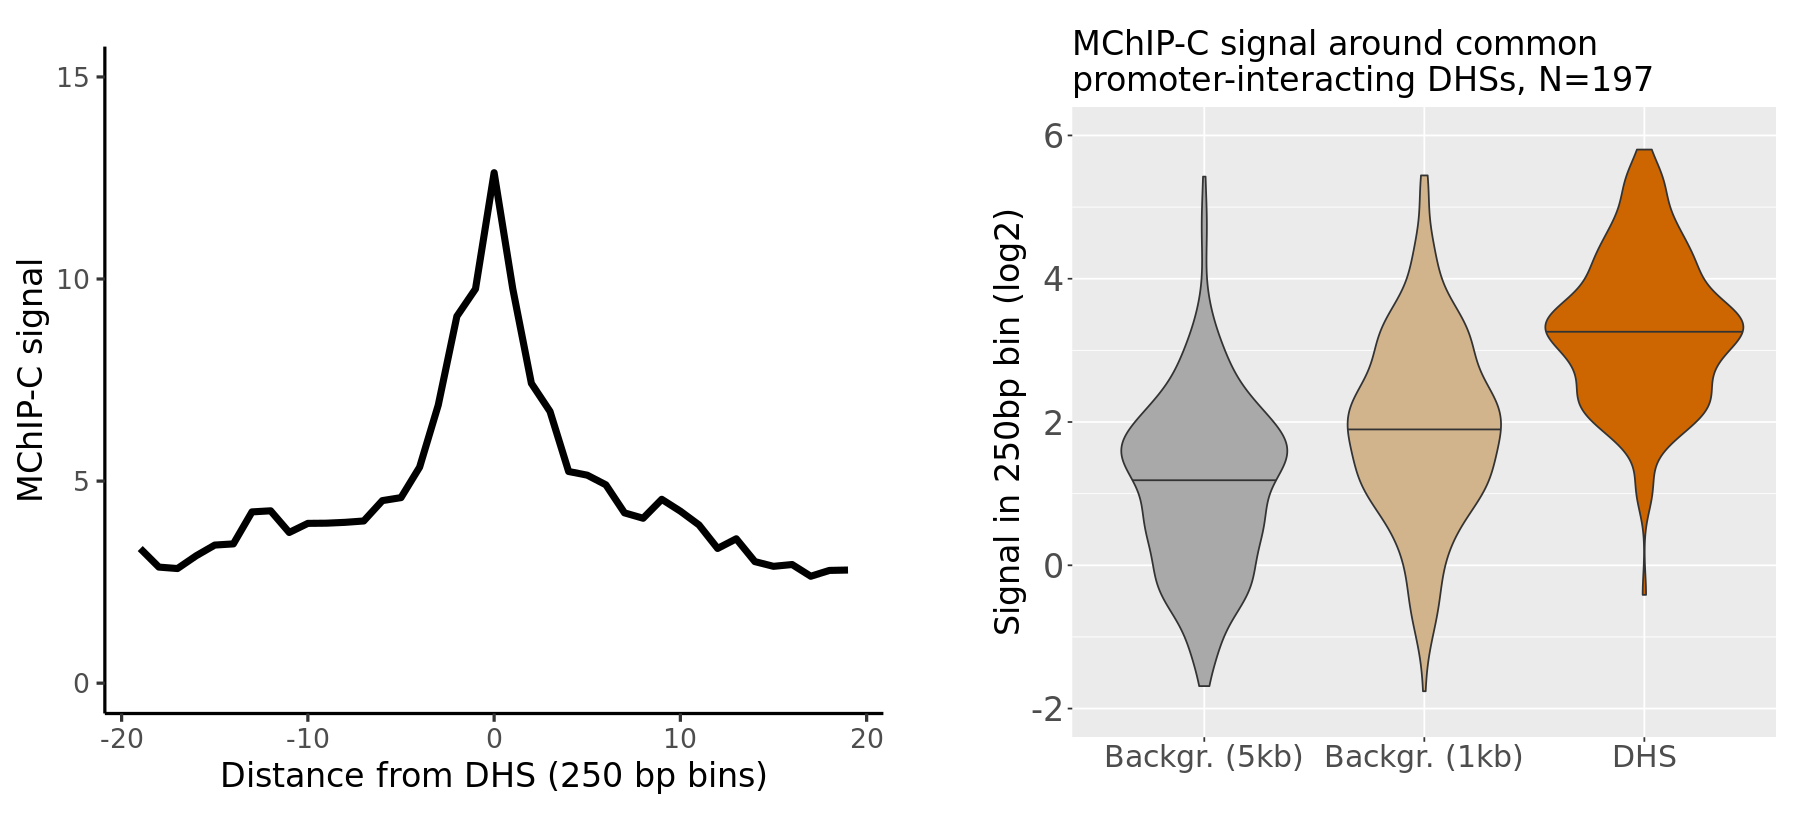

In [22]:
options(repr.plot.width=15, repr.plot.height=7)
grid.arrange(DHS_MChIPC_profile, 
             DHS_MChIPC_violin+theme(plot.margin=unit(c(0,0.5,0,2),"cm")),
             widths=c(0.5,0.5), heights=unit(6.5,"in"), ncol=2)

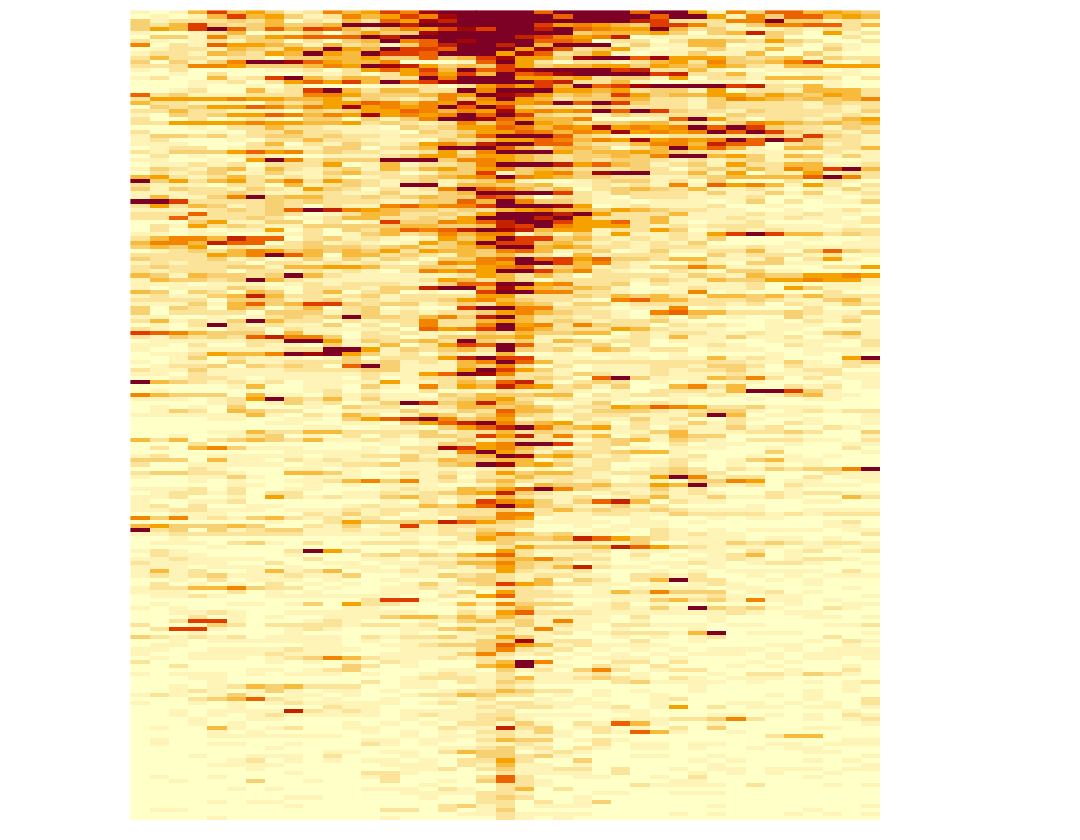

In [23]:
options(repr.plot.width=9, repr.plot.height=7)
heatmap(as.matrix(DHS_heatmap_MChIPC), Colv=NA, Rowv=NA, scale="none", labRow=FALSE, labCol=FALSE, margins = c(1, 4))

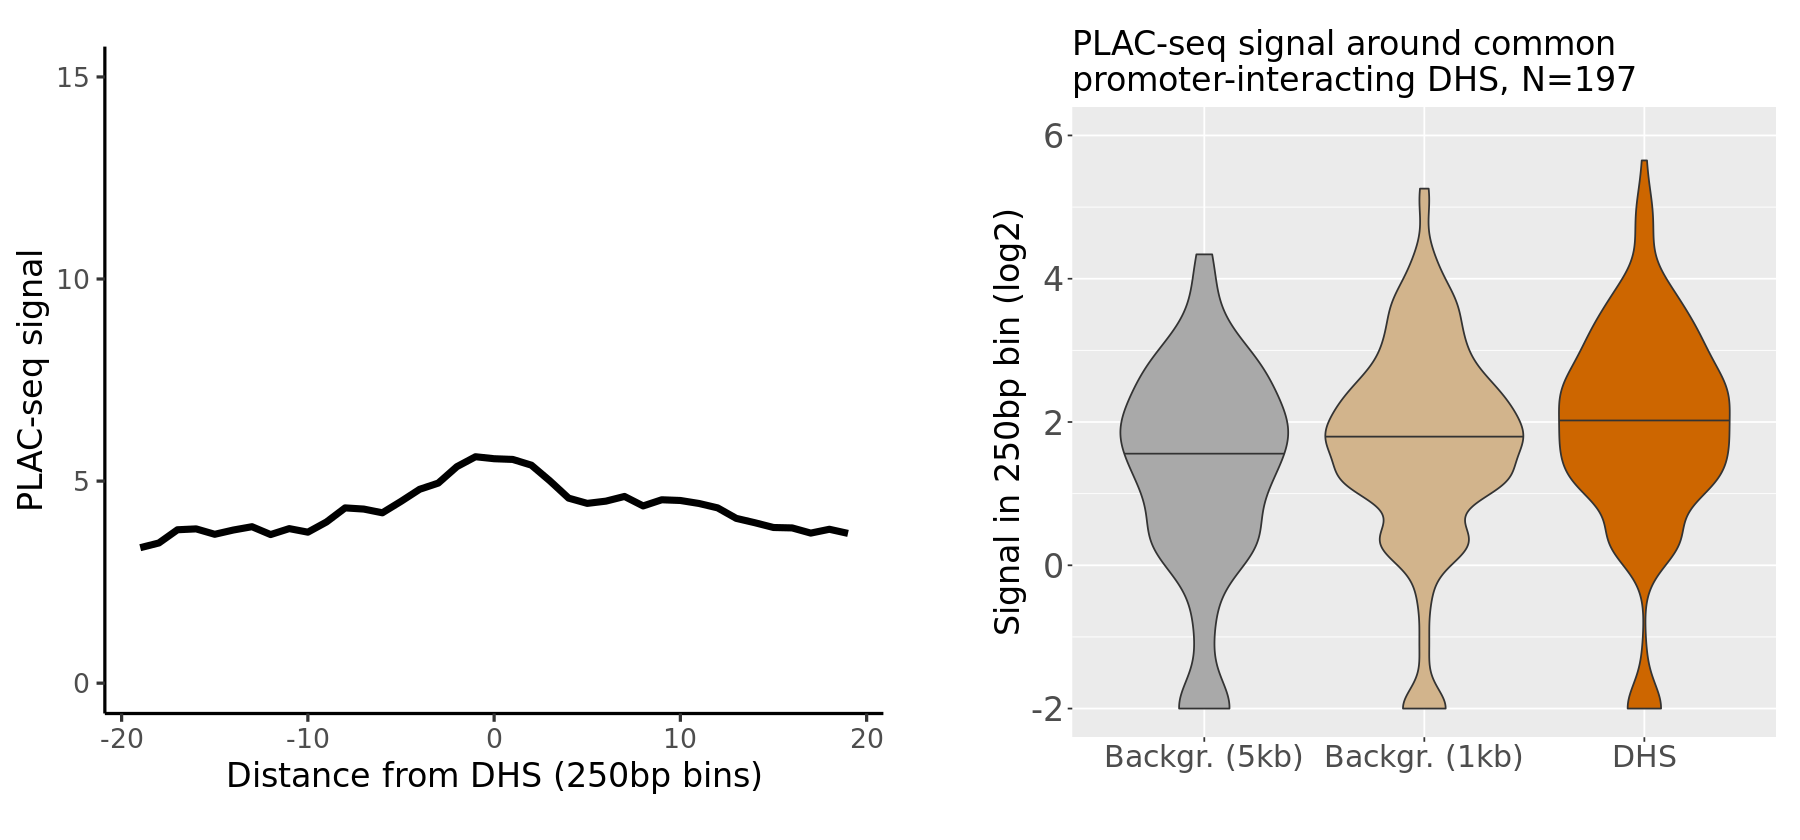

In [24]:
options(repr.plot.width=15, repr.plot.height=7)
grid.arrange(DHS_PLACseq_profile, 
             DHS_PLACseq_violin+theme(plot.margin=unit(c(0,0.5,0,2),"cm")),
             widths=c(0.5,0.5), heights=unit(6.5,"in"), ncol=2)

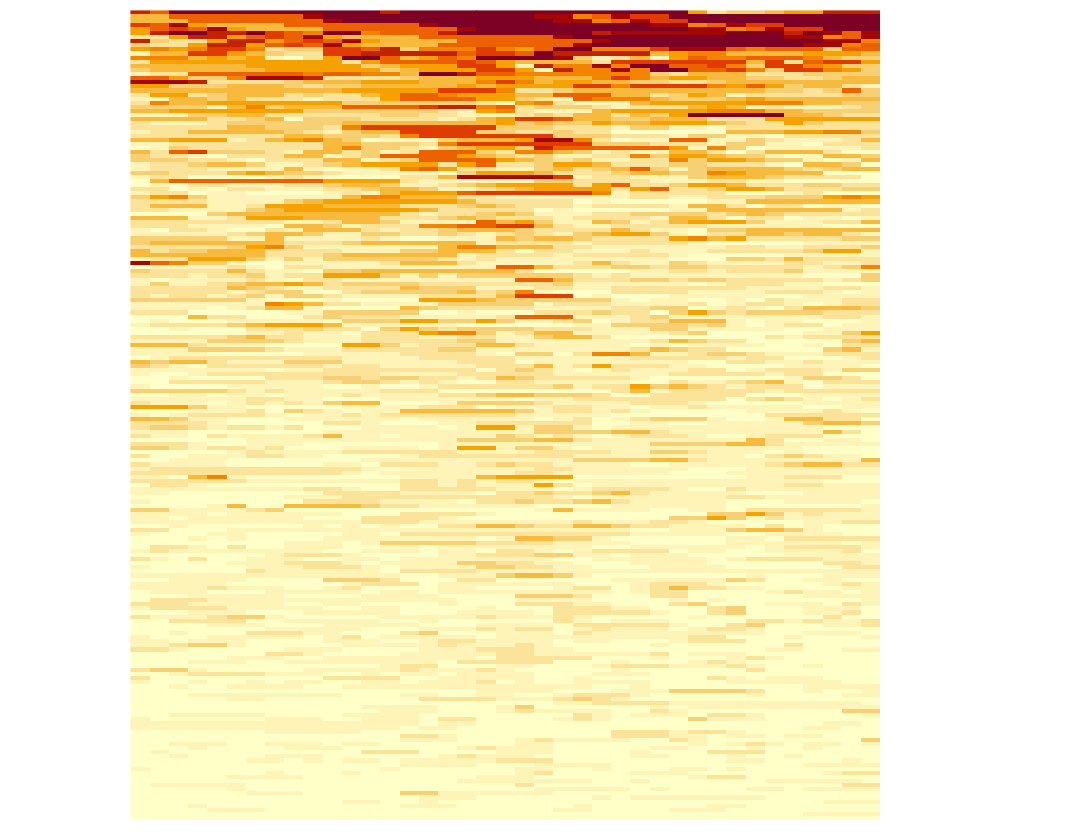

In [25]:
options(repr.plot.width=9, repr.plot.height=7)
heatmap(as.matrix(DHS_heatmap_PLACseq), Colv=NA, Rowv=NA, 
        scale="none", labRow=FALSE, labCol=FALSE, margins = c(1, 4))

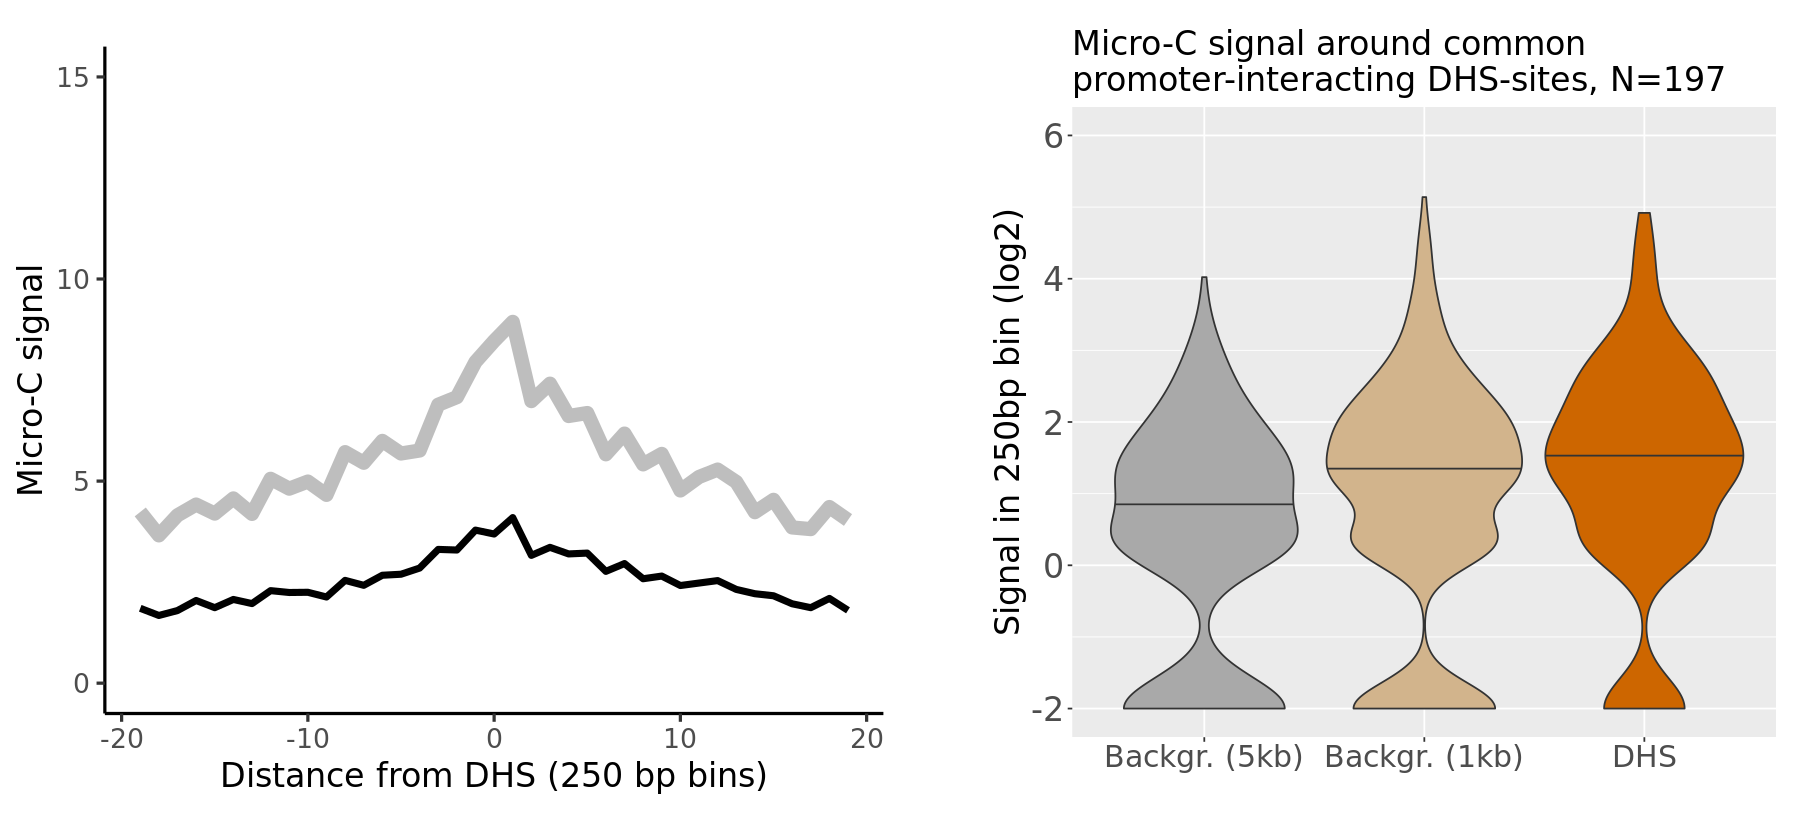

In [26]:
options(repr.plot.width=15, repr.plot.height=7)
grid.arrange(DHS_MicroC_profile, 
             DHS_MicroC_violin+theme(plot.margin=unit(c(0,0.5,0,2),"cm")),
             widths=c(0.5,0.5), heights=unit(6.5,"in"), ncol=2)

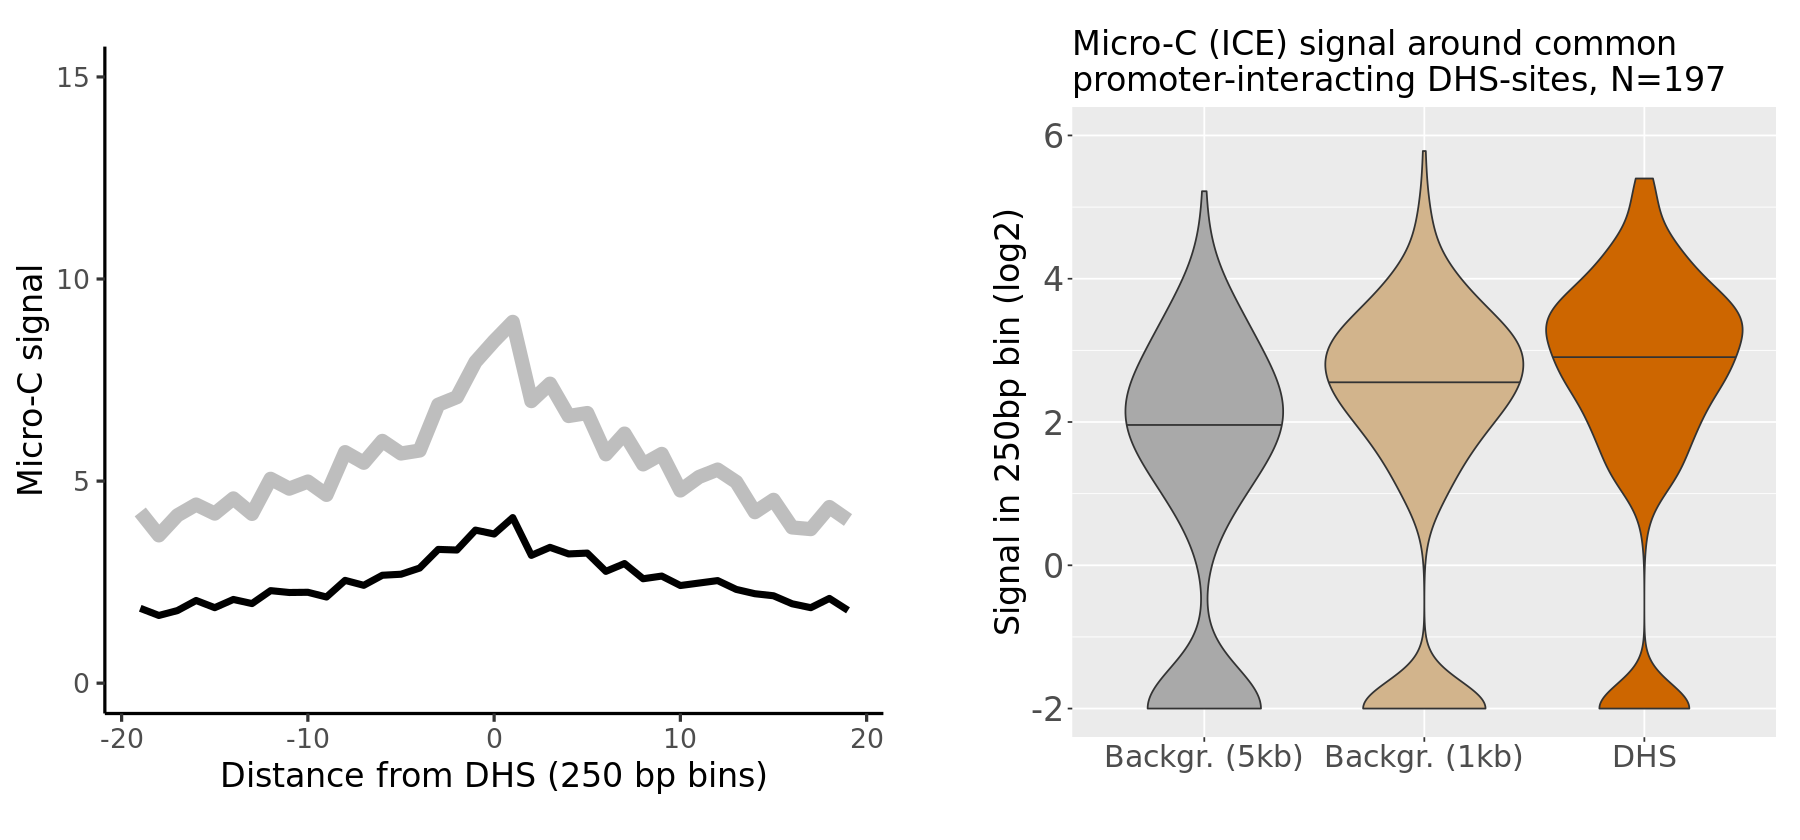

In [27]:
grid.arrange(DHS_MicroC_profile, 
             DHS_MicroC_ICE_violin+theme(plot.margin=unit(c(0,0.5,0,2),"cm")),
             widths=c(0.5,0.5), heights=unit(6.5,"in"), ncol=2)

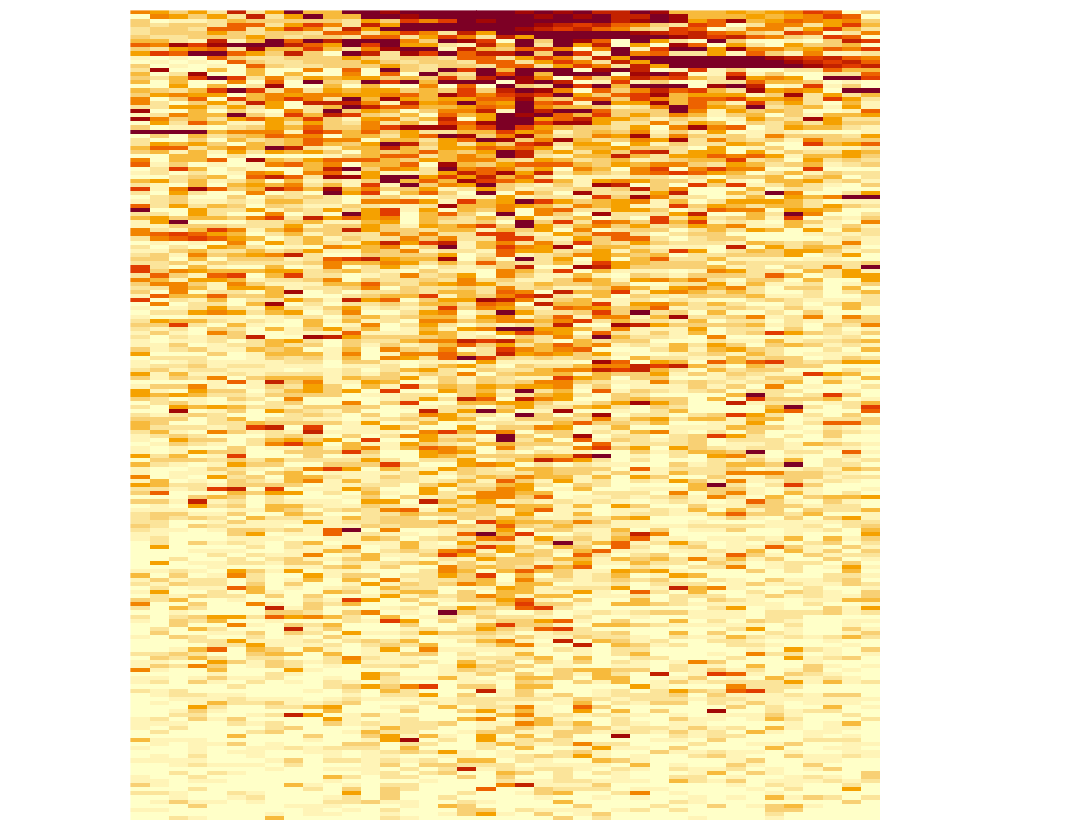

In [28]:
options(repr.plot.width=9, repr.plot.height=7)
heatmap(as.matrix(DHS_heatmap_ICEM), Colv=NA, Rowv=NA, 
        scale="none", labRow=FALSE, labCol=FALSE, margins = c(1, 4))

In [29]:
# saving plots
pdf("Figures/Fig.S3/S3b_common_DHS_MChIPC.pdf", width=15, height=7)
grid.arrange(DHS_MChIPC_profile, 
             DHS_MChIPC_violin+theme(plot.margin=unit(c(0,0.5,0,2),"cm")),
             widths=c(0.5,0.5), heights=unit(6.5,"in"), ncol=2)
dev.off()

pdf("Figures/Fig.S3/S3b_common_DHS_PLACseq.pdf", width=15, height=7)
grid.arrange(DHS_PLACseq_profile, 
             DHS_PLACseq_violin+theme(plot.margin=unit(c(0,0.5,0,2),"cm")),
             widths=c(0.5,0.5), heights=unit(6.5,"in"), ncol=2)
dev.off()

pdf("Figures/Fig.S3/S3b_common_DHS_MicroC.pdf", width=15, height=7)
grid.arrange(DHS_MicroC_profile, 
             DHS_MicroC_violin+theme(plot.margin=unit(c(0,0.5,0,2),"cm")),
             widths=c(0.5,0.5), heights=unit(6.5,"in"), ncol=2)
dev.off()

pdf("Figures/Fig.S3/S3b_common_DHS_MicroC_ICE.pdf", width=15, height=7)
grid.arrange(DHS_MicroC_profile, 
             DHS_MicroC_ICE_violin+theme(plot.margin=unit(c(0,0.5,0,2),"cm")),
             widths=c(0.5,0.5), heights=unit(6.5,"in"), ncol=2)
dev.off()

pdf("Figures/Fig.S3/S3b_common_DHS_MChIPC_heatmap.pdf", width=9, height=7)
heatmap(as.matrix(DHS_heatmap_MChIPC), Colv=NA, Rowv=NA, scale="none", labRow=FALSE, labCol=FALSE, margins = c(1, 4))
dev.off()

pdf("Figures/Fig.S3/S3b_common_DHS_PLACseq_heatmap.pdf", width=9, height=7)
heatmap(as.matrix(DHS_heatmap_PLACseq), Colv=NA, Rowv=NA, scale="none", labRow=FALSE, labCol=FALSE, margins = c(1, 4))
dev.off()

pdf("Figures/Fig.S3/S3b_common_DHS_MicroC_heatmap.pdf", width=9, height=7)
heatmap(as.matrix(DHS_heatmap_ICEM), Colv=NA, Rowv=NA, scale="none", labRow=FALSE, labCol=FALSE, margins = c(1, 4))
dev.off()

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

# Analysis and plotting of PLAC-seq-specific P-CTCF / P-DHS interactions

# P-CTCF

In [30]:
rm(list=ls()[!((ls()%in%c("summary_CTCF","summary_DHS")) | grepl("_dist",ls()))])
CTCF_PLACseq <- filter(summary_CTCF,!(MChIPC)&PLACseq&!(MicroC))
CTCF_vp_ranges <- GRanges(seqnames = CTCF_PLACseq$vp_chr, 
                         ranges=IRanges(start=CTCF_PLACseq$vp_start, end=CTCF_PLACseq$vp_end))

# P-CTCF in MChIP-C data
MChIPC_signal <- read.csv("MChIPC_output/MChIPC_interaction_data.txt", header = T, sep = "\t")
MChIPC_signal <- filter(MChIPC_signal, dist_rank!=0)
signal_ranges <- GRanges(seqnames = MChIPC_signal$vp_chr, 
                         ranges=IRanges(start=MChIPC_signal$vp_start, end=MChIPC_signal$vp_end))
MChIPC_signal <- MChIPC_signal[unique(as.data.frame(findOverlaps(signal_ranges, CTCF_vp_ranges))$queryHits),]
MChIPC_signal <- filter(MChIPC_signal, dist_rank>19)
signal_ranges <- GRanges(seqnames = MChIPC_signal$vp_chr, 
                         ranges=IRanges(start=MChIPC_signal$vp_start, end=MChIPC_signal$vp_end))
CTCF_heatmap <- tibble(dist_rank=seq(-19,19))
for (i in seq(nrow(CTCF_PLACseq))){
  loop <- CTCF_PLACseq[i,]
  loop_signal <- filter(MChIPC_signal, vp_chr==loop$vp_chr & vp_start==loop$vp_start & vp_end==loop$vp_end)
  loop_signal[loop_signal$vp_start > loop_signal$OE_start,]$dist_rank <- -1 * loop_signal[loop_signal$vp_start > 
                                                                                loop_signal$OE_start,]$dist_rank
  if (loop$vp_start > loop$CTCF_start) {loop_signal <- filter(loop_signal, dist_rank >
                            floor(((loop$CTCF_start+loop$CTCF_end)/2 - vp_start)/250)-20 &
                            dist_rank<floor(((loop$CTCF_start+loop$CTCF_end)/2 - vp_start)/250)+20)}
      else {loop_signal <- filter(loop_signal, dist_rank>ceiling(((loop$CTCF_start+
            loop$CTCF_end)/2 - vp_end)/250)-20 & dist_rank<ceiling(((loop$CTCF_start+
            loop$CTCF_end)/2 - vp_end)/250)+20)}
  if (loop$vp_start > loop$CTCF_start) {loop_signal$dist_rank <- loop_signal$dist_rank -
     floor(((loop$CTCF_start+loop$CTCF_end)/2 - loop_signal$vp_start)/250)} 
    else {loop_signal$dist_rank <- loop_signal$dist_rank - ceiling(((loop$CTCF_start+
          loop$CTCF_end)/2 - loop_signal$vp_end)/250)}
  loop_signal <- loop_signal[,c(21,28)]
  colnames(loop_signal)[2] <- paste0("loop_",i)
  suppressMessages({CTCF_heatmap <- left_join(CTCF_heatmap, loop_signal)})}
CTCF_heatmap[is.na(CTCF_heatmap)] <- 0
CTCF_heatmap <- as.data.frame(t(CTCF_heatmap)[2:ncol(CTCF_heatmap),])
CTCF_heatmap_MChIP <- arrange(CTCF_heatmap, rowMeans(CTCF_heatmap))
CTCF_heatmap_MChIPC_PLACseq <- arrange(CTCF_heatmap, rowMeans(CTCF_heatmap))
CTCF_heatmap_MChIPC_PLACseq[CTCF_heatmap_MChIPC_PLACseq>20] <- 20

CTCF_MChIPC_PLACseq_profile <- ggplot()+geom_line(aes(x=seq(-19,19,1),y=colMeans(CTCF_heatmap_MChIP)),size=2)+
theme_classic(base_size = 20)+xlim(-19,19) + ylim(0,10) + 
xlab("Distance from CTCF site (250 bp bins)")+ylab("MChIP-C signal")

violin_data_CTCF <- data.frame(MChIPC_CTCF_5kb=c(unlist(CTCF_heatmap[,c(1,39)])),
                          MChIPC_CTCF_1kb=c(unlist(CTCF_heatmap[,c(16,24)])),
                          MChIPC_CTCF=c(unlist(CTCF_heatmap[,c(20,20)])))
CTCF_MChIPC_PLACseq_violin <- ggplot(melt(violin_data_CTCF)) + 
geom_violin(aes(variable, log2(value+0.25), fill=variable), draw_quantiles=0.5)+ ylim(-2,5) +
scale_x_discrete(labels=c("Backgr. (5kb)","Backgr. (1kb)","CTCF")) + 
theme(axis.text.x = element_text(size = 18), axis.text.y = element_text(size = 20),text=element_text(size=20),
     plot.title=element_text(size=20)) +
labs(y="Signal in 250bp bin (log2)",x="") + 
scale_fill_manual(values=c("darkgrey","lightsteelblue1","royalblue2"))+
ggtitle(paste0("MChIP-C signal around PLAC-seq-specific\npromoter-interacting CTCF-sites, N=",nrow(CTCF_PLACseq)))+
guides(fill=FALSE)

# P-CTCF in PLAC-seq data
rm(MChIPC_signal)
PLACseq_signal <- read.csv("PLACseq_output/PLACseq.signal.df.txt", header = F, sep = "\t")
PLACseq_signal$V7 <- as.numeric(gsub(",",".",PLACseq_signal$V7))
colnames(PLACseq_signal) <- c("vp_chr","vp_start","vp_end","OE_chr","OE_start","OE_end","N_sum")
signal_ranges <- GRanges(seqnames = PLACseq_signal$vp_chr, 
                         ranges=IRanges(start=PLACseq_signal$vp_start, end=PLACseq_signal$vp_end))
PLACseq_signal <- PLACseq_signal[unique(as.data.frame(findOverlaps(signal_ranges, CTCF_vp_ranges))$queryHits),]
PLACseq_signal$dist_rank <- 0
PLACseq_signal$dist_rank[PLACseq_signal$vp_start>PLACseq_signal$OE_start]<-(PLACseq_signal$vp_start[PLACseq_signal$vp_start>PLACseq_signal$OE_start]- 
                                                            PLACseq_signal$OE_start[PLACseq_signal$vp_start>PLACseq_signal$OE_start])/250
PLACseq_signal$dist_rank[PLACseq_signal$vp_end<PLACseq_signal$OE_start]<-(PLACseq_signal$OE_end[PLACseq_signal$vp_end<PLACseq_signal$OE_start]- 
                                                            PLACseq_signal$vp_end[PLACseq_signal$vp_end<PLACseq_signal$OE_start])/250
PLACseq_signal <- filter(PLACseq_signal, dist_rank>19)
signal_ranges <- GRanges(seqnames = PLACseq_signal$vp_chr, 
                         ranges=IRanges(start=PLACseq_signal$vp_start, end=PLACseq_signal$vp_end))
CTCF_heatmap <- tibble(dist_rank=seq(-19,19))
for (i in seq(nrow(CTCF_PLACseq))){
  loop <- CTCF_PLACseq[i,]
  loop_signal <- filter(PLACseq_signal, vp_chr==loop$vp_chr & vp_start==loop$vp_start & vp_end==loop$vp_end)
  loop_signal[loop_signal$vp_start > loop_signal$OE_start,]$dist_rank <- -1 * loop_signal[loop_signal$vp_start > 
                                                                                loop_signal$OE_start,]$dist_rank
  if (loop$vp_start > loop$CTCF_start) {loop_signal <- filter(loop_signal, dist_rank >
                            floor(((loop$CTCF_start+loop$CTCF_end)/2 - vp_start)/250)-20 &
                            dist_rank<floor(((loop$CTCF_start+loop$CTCF_end)/2 - vp_start)/250)+20)}
      else {loop_signal <- filter(loop_signal, dist_rank>ceiling(((loop$CTCF_start+
            loop$CTCF_end)/2 - vp_end)/250)-20 & dist_rank<ceiling(((loop$CTCF_start+
            loop$CTCF_end)/2 - vp_end)/250)+20)}
  if (loop$vp_start > loop$CTCF_start) {loop_signal$dist_rank <- loop_signal$dist_rank -
     floor(((loop$CTCF_start+loop$CTCF_end)/2 - loop_signal$vp_start)/250)} 
    else {loop_signal$dist_rank <- loop_signal$dist_rank - ceiling(((loop$CTCF_start+
          loop$CTCF_end)/2 - loop_signal$vp_end)/250)}
  loop_signal <- loop_signal[,c(8,7)]
  colnames(loop_signal)[2] <- paste0("loop_",i)
  suppressMessages({CTCF_heatmap <- left_join(CTCF_heatmap, loop_signal)})}
CTCF_heatmap[is.na(CTCF_heatmap)] <- 0
CTCF_heatmap <- as.data.frame(t(CTCF_heatmap)[2:ncol(CTCF_heatmap),])
CTCF_heatmap_PLAC <- arrange(CTCF_heatmap, rowMeans(CTCF_heatmap))
CTCF_heatmap_PLACseq <- arrange(CTCF_heatmap, rowMeans(CTCF_heatmap))
CTCF_heatmap_PLACseq[CTCF_heatmap_PLACseq>20] <- 20

CTCF_PLACseq_profile <- ggplot()+geom_line(aes(x=seq(-19,19,1),y=colMeans(CTCF_heatmap_PLAC)),size=2)+
theme_classic(base_size = 20)+xlim(-19,19) + ylim(0,10)+
xlab("Distance from CTCF site (250bp bins)")+ylab("PLAC-seq signal")

violin_data_CTCF <- violin_data_CTCF %>% mutate(PLACseq_CTCF_5kb=c(unlist(CTCF_heatmap[,c(1,39)])),
                          PLACseq_CTCF_1kb=c(unlist(CTCF_heatmap[,c(16,24)])),
                          PLACseq_CTCF=c(unlist(CTCF_heatmap[,c(20,20)])))
CTCF_PLACseq_violin <- ggplot(melt(violin_data_CTCF[,4:6])) + 
geom_violin(aes(variable, log2(value+0.25), fill=variable), draw_quantiles=0.5)+ ylim(-2,5) +
scale_x_discrete(labels=c("Backgr. (5kb)","Backgr. (1kb)","CTCF")) + 
theme(axis.text.x = element_text(size = 18), axis.text.y = element_text(size = 20),text=element_text(size=20),
     plot.title=element_text(size=20)) +
labs(y="Signal in 250bp bin (log2)",x="") + 
scale_fill_manual(values=c("darkgrey","lightsteelblue1","royalblue2"))+
ggtitle(paste0("PLAC-seq signal around PLAC-seq-specific\npromoter-interacting CTCF-sites, N=",nrow(CTCF_PLACseq)))+ guides(fill=FALSE)

rm(PLACseq_signal)

No id variables; using all as measure variables

No id variables; using all as measure variables



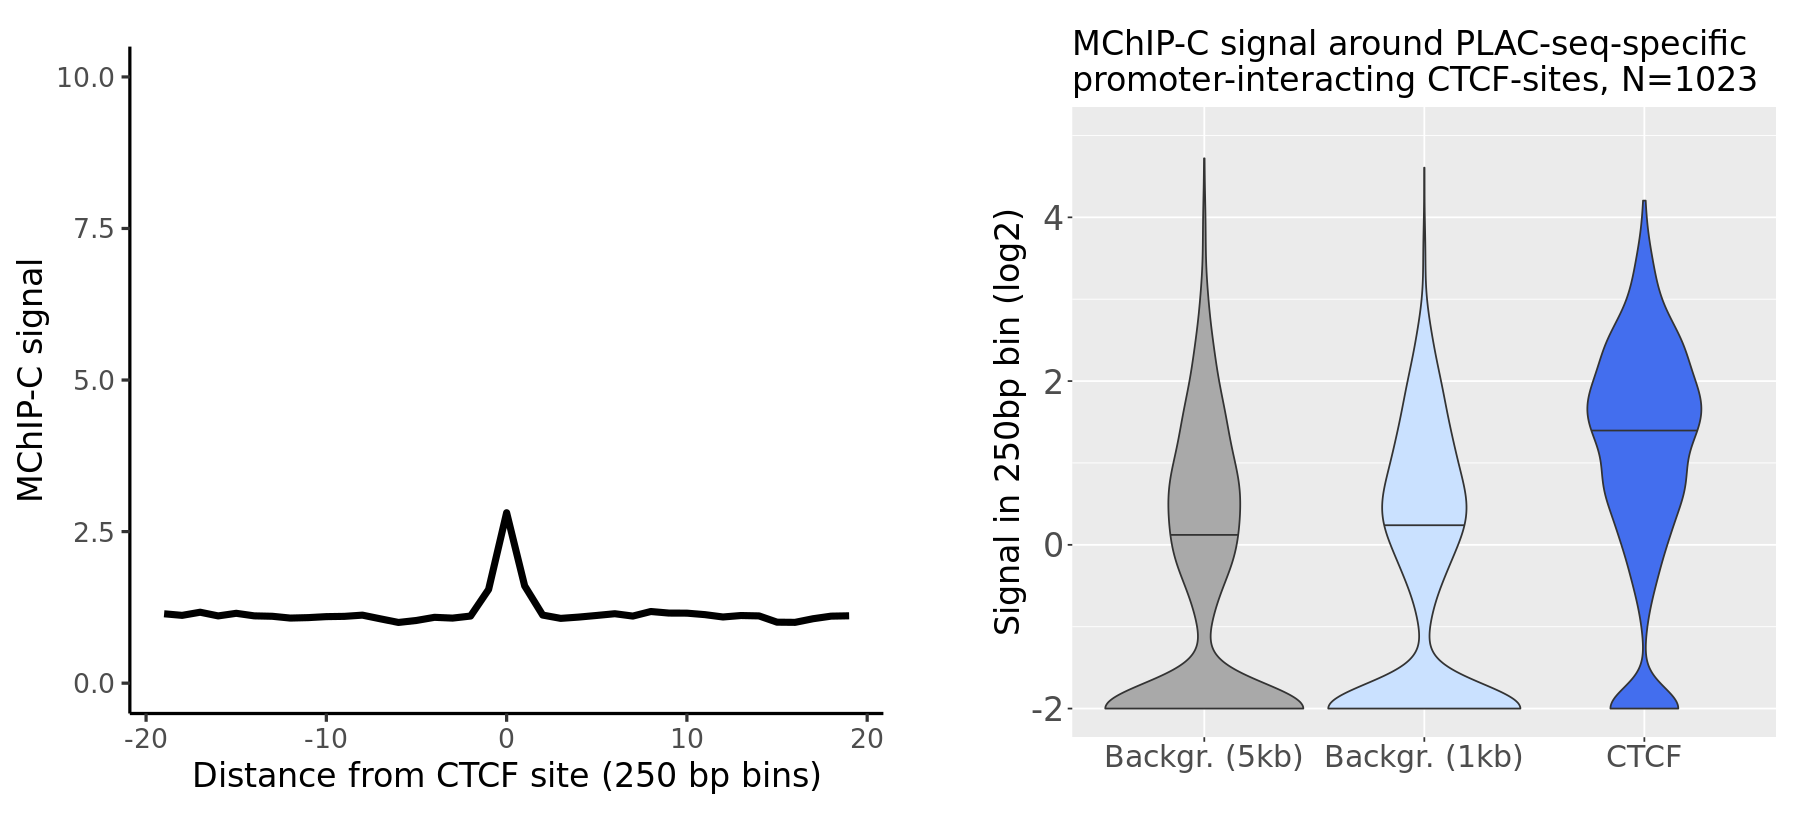

In [31]:
options(repr.plot.width=15, repr.plot.height=7)
grid.arrange(CTCF_MChIPC_PLACseq_profile, 
             CTCF_MChIPC_PLACseq_violin+theme(plot.margin=unit(c(0,0.5,0,2),"cm")),
             widths=c(0.5,0.5), heights=unit(6.5,"in"), ncol=2)

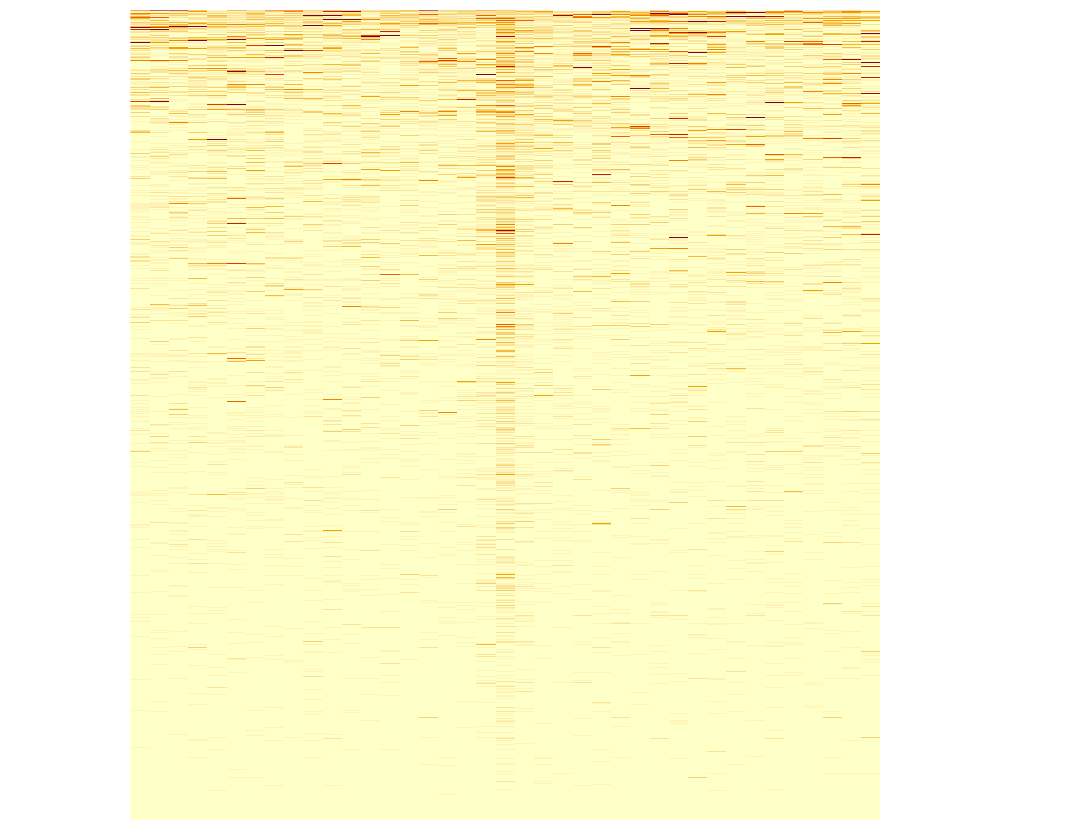

In [32]:
options(repr.plot.width=9, repr.plot.height=7)
heatmap(as.matrix(CTCF_heatmap_MChIPC_PLACseq), Colv=NA, Rowv=NA, scale="none", labRow=FALSE, labCol=FALSE, margins = c(1, 4))

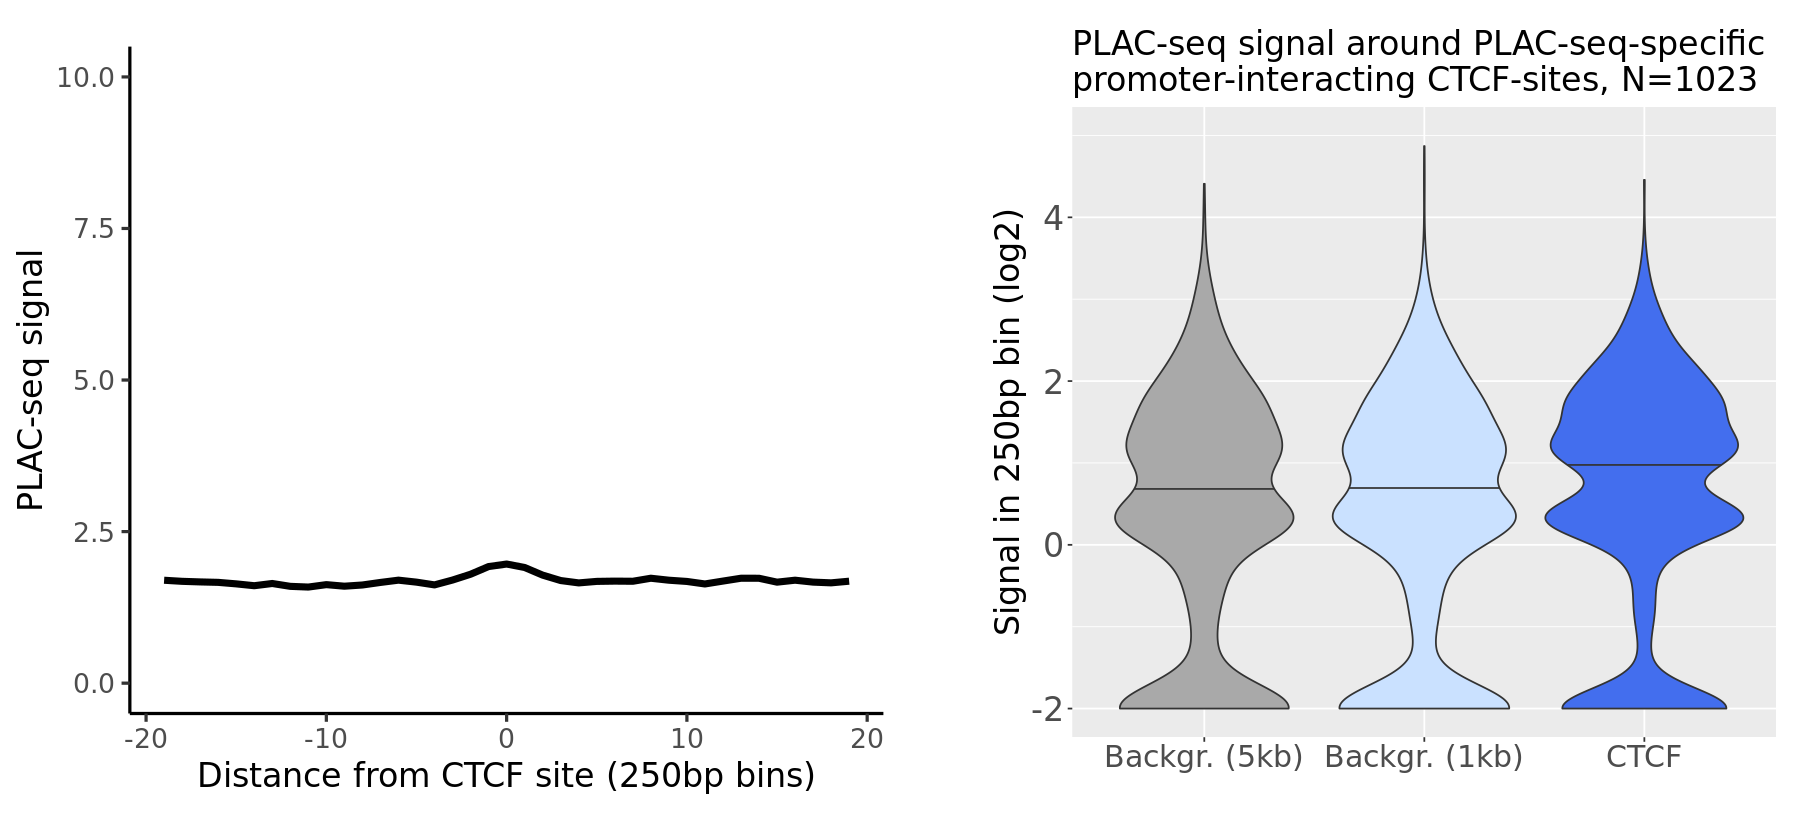

In [33]:
options(repr.plot.width=15, repr.plot.height=7)
grid.arrange(CTCF_PLACseq_profile, 
             CTCF_PLACseq_violin+theme(plot.margin=unit(c(0,0.5,0,2),"cm")),
             widths=c(0.5,0.5), heights=unit(6.5,"in"), ncol=2)

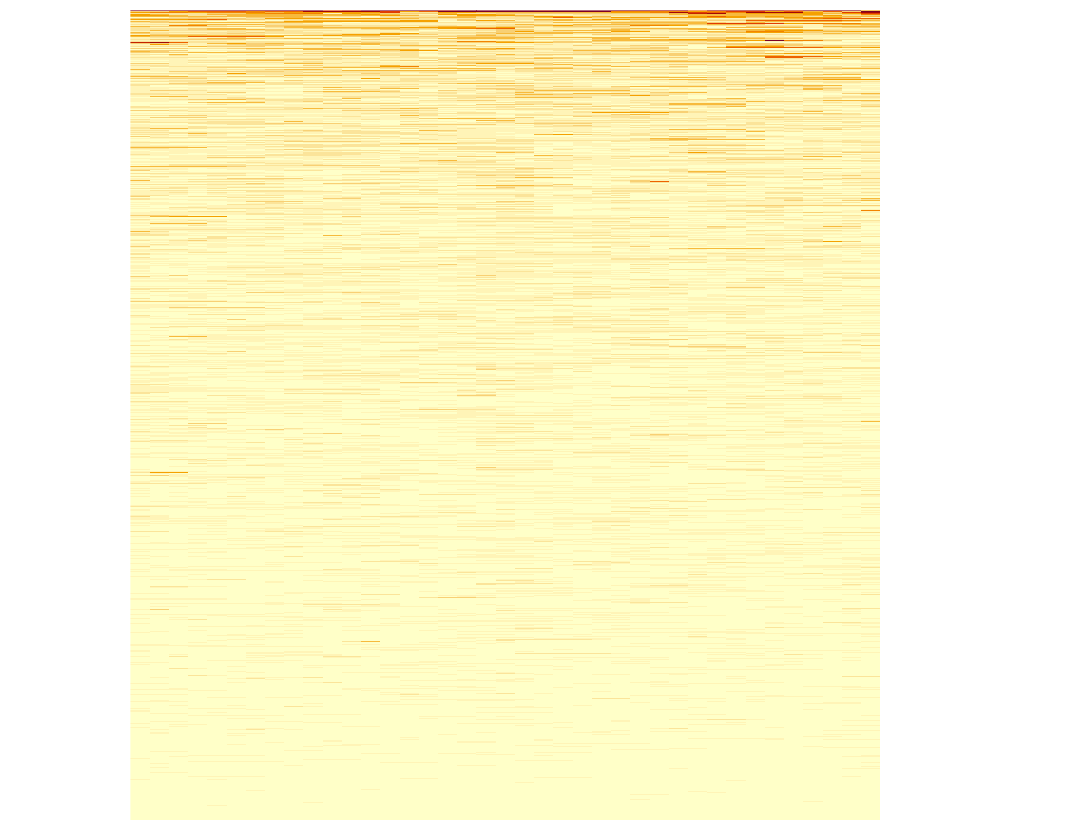

In [34]:
options(repr.plot.width=9, repr.plot.height=7)
heatmap(as.matrix(CTCF_heatmap_PLACseq), Colv=NA, Rowv=NA, scale="none", labRow=FALSE, labCol=FALSE, margins = c(1, 4))

In [35]:
# saving plots
pdf("Figures/Fig.S3/S3c_PLACseq_sp_CTCF_MChIPC.pdf", width=15, height=7)
grid.arrange(CTCF_MChIPC_PLACseq_profile, 
             CTCF_MChIPC_PLACseq_violin+theme(plot.margin=unit(c(0,0.5,0,2),"cm")),
             widths=c(0.5,0.5), heights=unit(6.5,"in"), ncol=2)
dev.off()

pdf("Figures/Fig.S3/S3c_PLACseq_sp_CTCF_PLACseq.pdf", width=15, height=7)
grid.arrange(CTCF_PLACseq_profile, 
             CTCF_PLACseq_violin+theme(plot.margin=unit(c(0,0.5,0,2),"cm")),
             widths=c(0.5,0.5), heights=unit(6.5,"in"), ncol=2)
dev.off()

pdf("Figures/Fig.S3/S3c_PLACseq_sp_CTCF_MChIPC_heatmap.pdf", width=9, height=7)
heatmap(as.matrix(CTCF_heatmap_MChIPC_PLACseq), Colv=NA, Rowv=NA, scale="none", labRow=FALSE, labCol=FALSE, margins = c(1, 4))
dev.off()

pdf("Figures/Fig.S3/S3c_PLACseq_sp_CTCF_PLACseq_heatmap.pdf", width=9, height=7)
heatmap(as.matrix(CTCF_heatmap_PLACseq), Colv=NA, Rowv=NA, scale="none", labRow=FALSE, labCol=FALSE, margins = c(1, 4))
dev.off()

png 
  2

png 
  2

png 
  2

png 
  2

# P-DHS

In [36]:
rm(list=ls()[!((ls()%in%c("summary_CTCF","summary_DHS")) | grepl("_dist",ls()))])
DHS_PLACseq <- filter(summary_DHS,!(MChIPC)&PLACseq&!(MicroC))
DHS_vp_ranges <- GRanges(seqnames = DHS_PLACseq$vp_chr, 
                         ranges=IRanges(start=DHS_PLACseq$vp_start, end=DHS_PLACseq$vp_end))

# P-DHS in MChIP-C data
MChIPC_signal <- read.csv("MChIPC_output/MChIPC_interaction_data.txt", header = T, sep = "\t")
MChIPC_signal <- filter(MChIPC_signal, dist_rank!=0)
signal_ranges <- GRanges(seqnames = MChIPC_signal$vp_chr, 
                         ranges=IRanges(start=MChIPC_signal$vp_start, end=MChIPC_signal$vp_end))
MChIPC_signal <- MChIPC_signal[unique(as.data.frame(findOverlaps(signal_ranges, DHS_vp_ranges))$queryHits),]
MChIPC_signal <- filter(MChIPC_signal, dist_rank>19)
signal_ranges <- GRanges(seqnames = MChIPC_signal$vp_chr, 
                         ranges=IRanges(start=MChIPC_signal$vp_start, end=MChIPC_signal$vp_end))

DHS_heatmap <- tibble(dist_rank=seq(-19,19))
for (i in seq(nrow(DHS_PLACseq))){
  loop <- DHS_PLACseq[i,]
  loop_signal <- filter(MChIPC_signal, vp_chr==loop$vp_chr & vp_start==loop$vp_start & vp_end==loop$vp_end)
  loop_signal[loop_signal$vp_start > loop_signal$OE_start,]$dist_rank <- -1 * loop_signal[loop_signal$vp_start > 
                                                                                loop_signal$OE_start,]$dist_rank
  if (loop$vp_start > loop$DHS_start) {loop_signal <- filter(loop_signal, dist_rank >
                            floor(((loop$DHS_start+loop$DHS_end)/2 - vp_start)/250)-20 &
                            dist_rank<floor(((loop$DHS_start+loop$DHS_end)/2 - vp_start)/250)+20)}
      else {loop_signal <- filter(loop_signal, dist_rank>ceiling(((loop$DHS_start+
            loop$DHS_end)/2 - vp_end)/250)-20 & dist_rank<ceiling(((loop$DHS_start+
            loop$DHS_end)/2 - vp_end)/250)+20)}
  if (loop$vp_start > loop$DHS_start) {loop_signal$dist_rank <- loop_signal$dist_rank -
     floor(((loop$DHS_start+loop$DHS_end)/2 - loop_signal$vp_start)/250)} 
    else {loop_signal$dist_rank <- loop_signal$dist_rank - ceiling(((loop$DHS_start+
          loop$DHS_end)/2 - loop_signal$vp_end)/250)}
  loop_signal <- loop_signal[,c(21,28)]
  colnames(loop_signal)[2] <- paste0("loop_",i)
  suppressMessages({DHS_heatmap <- left_join(DHS_heatmap, loop_signal)})}
DHS_heatmap[is.na(DHS_heatmap)] <- 0
DHS_heatmap <- as.data.frame(t(DHS_heatmap)[2:ncol(DHS_heatmap),])
DHS_heatmap_MChIP <- arrange(DHS_heatmap, rowMeans(DHS_heatmap))
DHS_heatmap_MChIPC_PLACseq <- arrange(DHS_heatmap, rowMeans(DHS_heatmap))
DHS_heatmap_MChIPC_PLACseq[DHS_heatmap_MChIPC_PLACseq>20] <- 20

DHS_MChIPC_PLACseq_profile <- ggplot()+geom_line(aes(x=seq(-19,19,1),y=colMeans(DHS_heatmap_MChIP)),size=2)+
theme_classic(base_size = 20)+xlim(-19,19) + ylim(0,5) + 
xlab("Distance from DHS (250 bp bins)")+ylab("MChIP-C signal")

violin_data_DHS <- data.frame(MChIPC_DHS_5kb=c(unlist(DHS_heatmap[,c(1,39)])),
                          MChIPC_DHS_1kb=c(unlist(DHS_heatmap[,c(16,24)])),
                          MChIPC_DHS=c(unlist(DHS_heatmap[,c(20,20)])))
DHS_MChIPC_PLACseq_violin <- ggplot(melt(violin_data_DHS)) + 
geom_violin(aes(variable, log2(value+0.25), fill=variable), draw_quantiles=0.5)+ ylim(-2,5) +
scale_x_discrete(labels=c("Backgr. (5kb)","Backgr. (1kb)","DHS")) + 
theme(axis.text.x = element_text(size = 18), axis.text.y = element_text(size = 20),text=element_text(size=20),
     plot.title=element_text(size=20)) +
labs(y="Signal in 250bp bin (log2)",x="") + 
scale_fill_manual(values=c("darkgrey","tan","darkorange3"))+
ggtitle(paste0("MChIP-C signal around PLAC-seq-specific\npromoter-interacting DHSs, N=",nrow(DHS_PLACseq)))+
guides(fill=FALSE)

# P-DHS in PLAC-seq data
PLACseq_signal <- read.csv("PLACseq_output/PLACseq.signal.df.txt", header = F, sep = "\t")
PLACseq_signal$V7 <- as.numeric(gsub(",",".",PLACseq_signal$V7))
colnames(PLACseq_signal) <- c("vp_chr","vp_start","vp_end","OE_chr","OE_start","OE_end","N_sum")
signal_ranges <- GRanges(seqnames = PLACseq_signal$vp_chr, 
                         ranges=IRanges(start=PLACseq_signal$vp_start, end=PLACseq_signal$vp_end))
PLACseq_signal <- PLACseq_signal[unique(as.data.frame(findOverlaps(signal_ranges, DHS_vp_ranges))$queryHits),]
PLACseq_signal$dist_rank <- 0
PLACseq_signal$dist_rank[PLACseq_signal$vp_start>PLACseq_signal$OE_start]<-(PLACseq_signal$vp_start[PLACseq_signal$vp_start>PLACseq_signal$OE_start]- 
                                                            PLACseq_signal$OE_start[PLACseq_signal$vp_start>PLACseq_signal$OE_start])/250
PLACseq_signal$dist_rank[PLACseq_signal$vp_end<PLACseq_signal$OE_start]<-(PLACseq_signal$OE_end[PLACseq_signal$vp_end<PLACseq_signal$OE_start]- 
                                                            PLACseq_signal$vp_end[PLACseq_signal$vp_end<PLACseq_signal$OE_start])/250
PLACseq_signal <- filter(PLACseq_signal, dist_rank>19)
signal_ranges <- GRanges(seqnames = PLACseq_signal$vp_chr, 
                         ranges=IRanges(start=PLACseq_signal$vp_start, end=PLACseq_signal$vp_end))

DHS_heatmap <- tibble(dist_rank=seq(-19,19))
for (i in seq(nrow(DHS_PLACseq))){
  loop <- DHS_PLACseq[i,]
  loop_signal <- filter(PLACseq_signal, vp_chr==loop$vp_chr & vp_start==loop$vp_start & vp_end==loop$vp_end)
  loop_signal[loop_signal$vp_start > loop_signal$OE_start,]$dist_rank <- -1 * loop_signal[loop_signal$vp_start > 
                                                                                loop_signal$OE_start,]$dist_rank
  if (loop$vp_start > loop$DHS_start) {loop_signal <- filter(loop_signal, dist_rank >
                            floor(((loop$DHS_start+loop$DHS_end)/2 - vp_start)/250)-20 &
                            dist_rank<floor(((loop$DHS_start+loop$DHS_end)/2 - vp_start)/250)+20)}
      else {loop_signal <- filter(loop_signal, dist_rank>ceiling(((loop$DHS_start+
            loop$DHS_end)/2 - vp_end)/250)-20 & dist_rank<ceiling(((loop$DHS_start+
            loop$DHS_end)/2 - vp_end)/250)+20)}
  if (loop$vp_start > loop$DHS_start) {loop_signal$dist_rank <- loop_signal$dist_rank -
     floor(((loop$DHS_start+loop$DHS_end)/2 - loop_signal$vp_start)/250)} 
    else {loop_signal$dist_rank <- loop_signal$dist_rank - ceiling(((loop$DHS_start+
          loop$DHS_end)/2 - loop_signal$vp_end)/250)}
  loop_signal <- loop_signal[,c(8,7)]
  colnames(loop_signal)[2] <- paste0("loop_",i)
  suppressMessages({DHS_heatmap <- left_join(DHS_heatmap, loop_signal)})}
DHS_heatmap[is.na(DHS_heatmap)] <- 0
DHS_heatmap <- as.data.frame(t(DHS_heatmap)[2:ncol(DHS_heatmap),])
DHS_heatmap_PLAC <- arrange(DHS_heatmap, rowMeans(DHS_heatmap))
DHS_heatmap_PLACseq <- arrange(DHS_heatmap, rowMeans(DHS_heatmap))
DHS_heatmap_PLACseq[DHS_heatmap_PLACseq>20] <- 20

DHS_PLACseq_profile <- ggplot()+geom_line(aes(x=seq(-19,19,1),y=colMeans(DHS_heatmap_PLAC)),size=2)+
theme_classic(base_size = 20)+xlim(-19,19) + ylim(0,5)+
xlab("Distance from DHS (250bp bins)")+ylab("PLAC-seq signal")

violin_data_DHS <- violin_data_DHS %>% mutate(PLACseq_DHS_5kb=c(unlist(DHS_heatmap[,c(1,39)])),
                          PLACseq_DHS_1kb=c(unlist(DHS_heatmap[,c(16,24)])),
                          PLACseq_DHS=c(unlist(DHS_heatmap[,c(20,20)])))
DHS_PLACseq_violin <- ggplot(melt(violin_data_DHS[,4:6])) + 
geom_violin(aes(variable, log2(value+0.25), fill=variable), draw_quantiles=0.5)+ ylim(-2,5) +
scale_x_discrete(labels=c("Backgr. (5kb)","Backgr. (1kb)","DHS")) + 
theme(axis.text.x = element_text(size = 18), axis.text.y = element_text(size = 20),text=element_text(size=20),
     plot.title=element_text(size=20)) +
labs(y="Signal in 250bp bin (log2)",x="") + 
scale_fill_manual(values=c("darkgrey","tan","darkorange3"))+
ggtitle(paste0("PLAC-seq signal around PLAC-seq-specific\npromoter-interacting DHSs, N=",nrow(DHS_PLACseq)))+ guides(fill=FALSE)

No id variables; using all as measure variables

No id variables; using all as measure variables



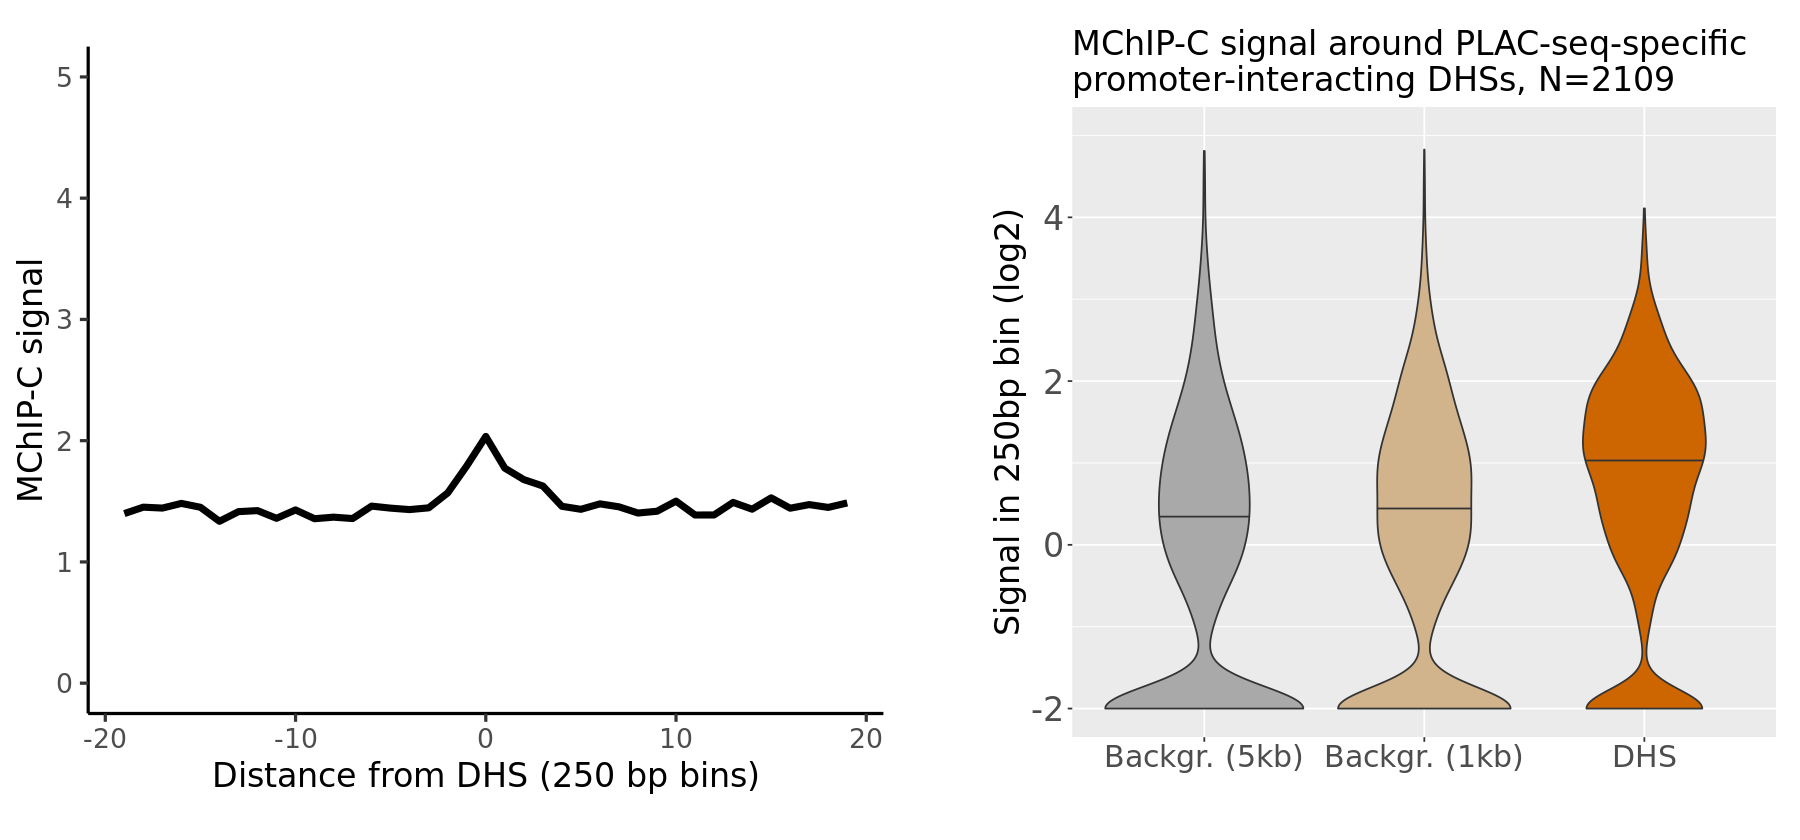

In [37]:
options(repr.plot.width=15, repr.plot.height=7)
grid.arrange(DHS_MChIPC_PLACseq_profile, 
             DHS_MChIPC_PLACseq_violin+theme(plot.margin=unit(c(0,0.5,0,2),"cm")),
             widths=c(0.5,0.5), heights=unit(6.5,"in"), ncol=2)

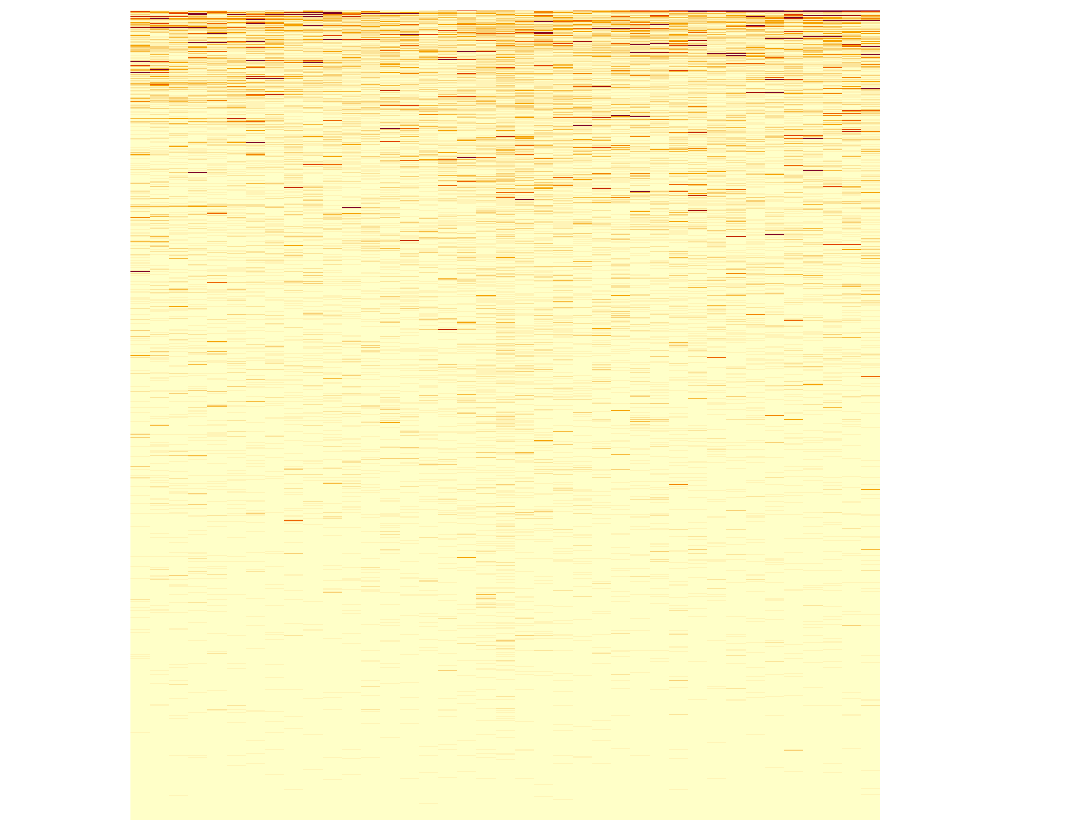

In [38]:
options(repr.plot.width=9, repr.plot.height=7)
heatmap(as.matrix(DHS_heatmap_MChIPC_PLACseq), Colv=NA, Rowv=NA, scale="none", labRow=FALSE, labCol=FALSE, margins = c(1, 4))

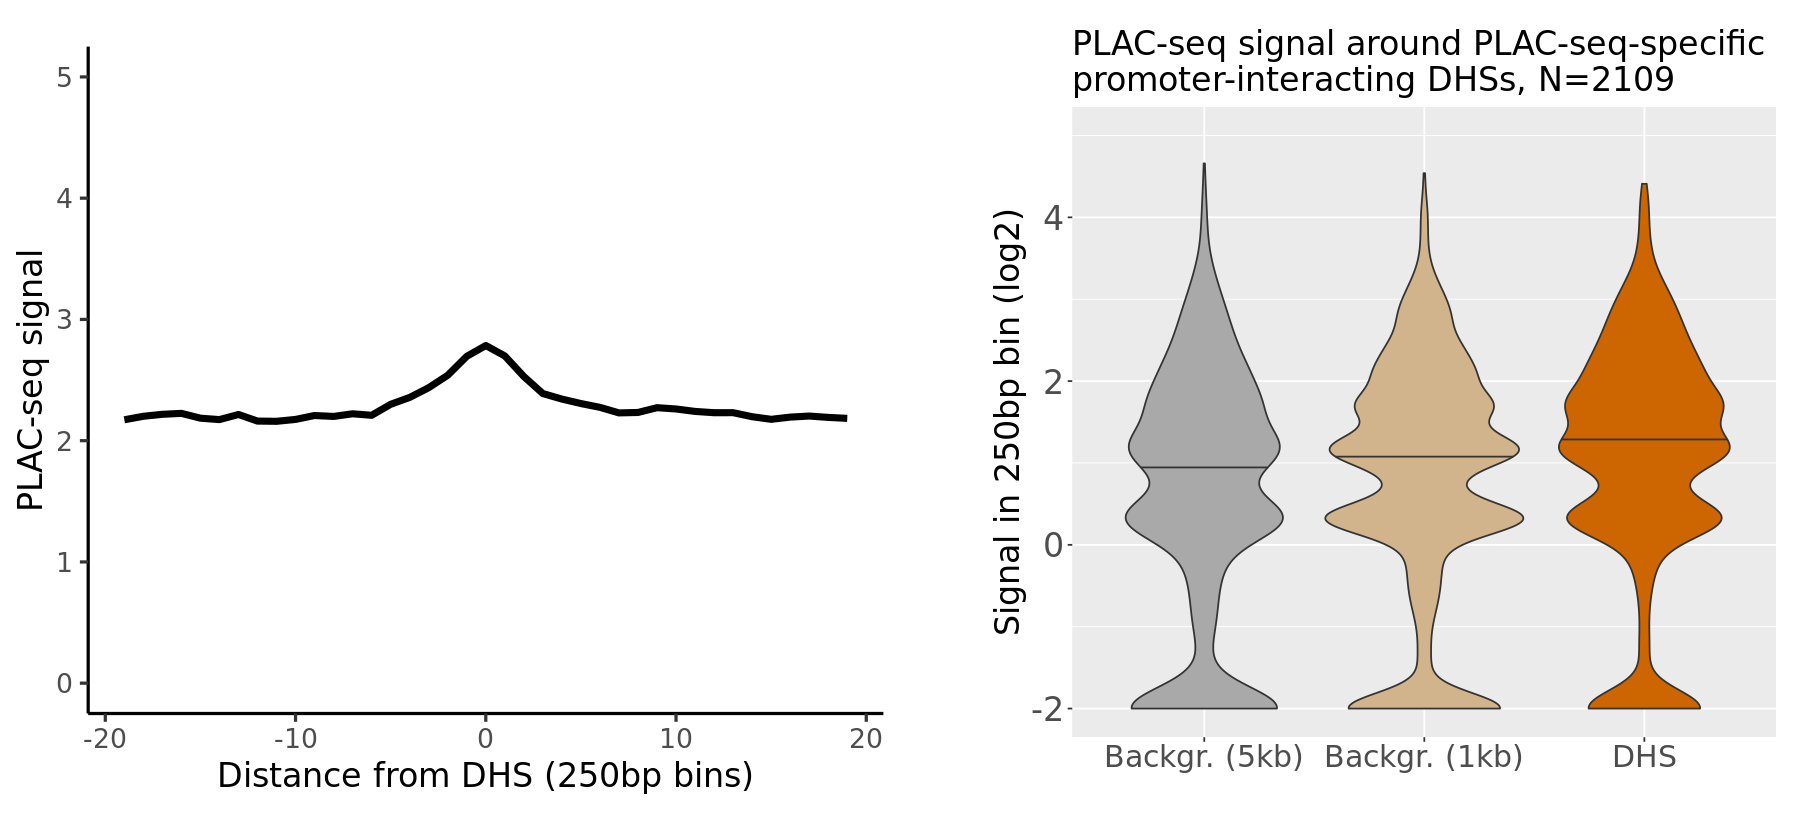

In [39]:
options(repr.plot.width=15, repr.plot.height=7)
grid.arrange(DHS_PLACseq_profile, 
             DHS_PLACseq_violin+theme(plot.margin=unit(c(0,0.5,0,2),"cm")),
             widths=c(0.5,0.5), heights=unit(6.5,"in"), ncol=2)

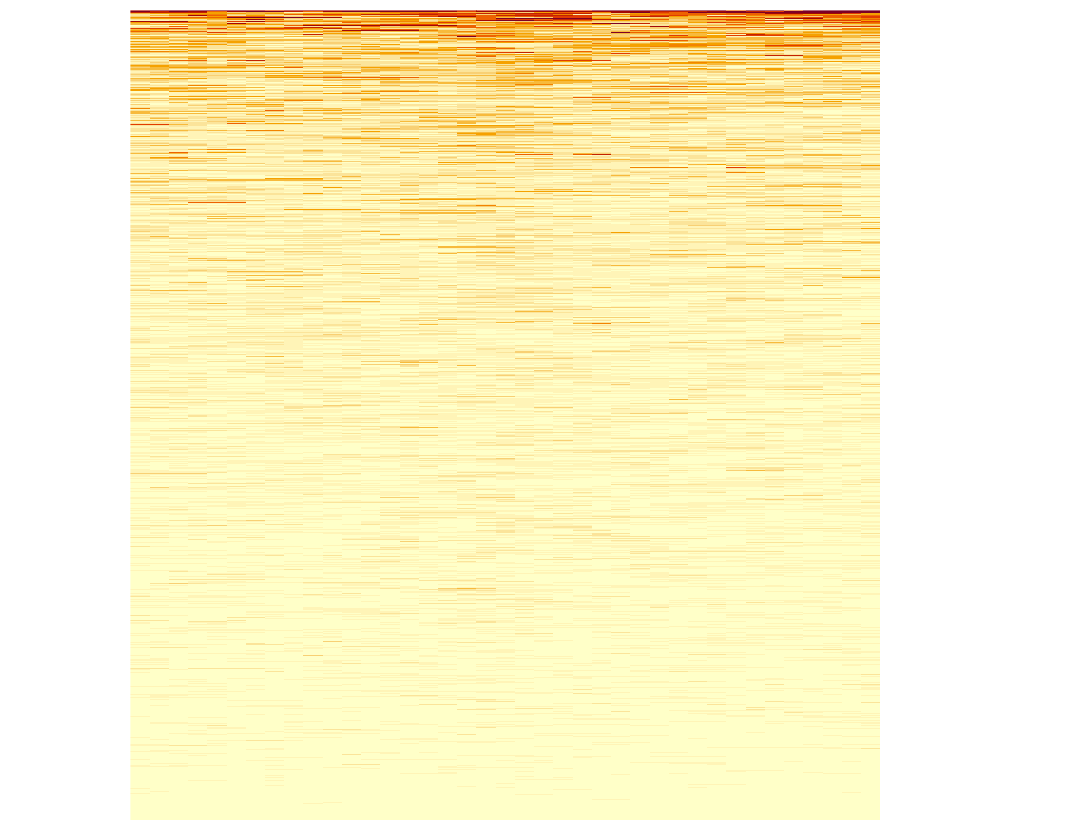

In [40]:
options(repr.plot.width=9, repr.plot.height=7)
heatmap(as.matrix(DHS_heatmap_PLACseq), Colv=NA, Rowv=NA, scale="none", labRow=FALSE, labCol=FALSE, margins = c(1, 4))

In [41]:
# saving plots
pdf("Figures/Fig.S3/S3c_PLACseq_sp_DHS_MChIPC.pdf", width=15, height=7)
grid.arrange(DHS_MChIPC_PLACseq_profile, 
             DHS_MChIPC_PLACseq_violin+theme(plot.margin=unit(c(0,0.5,0,2),"cm")),
             widths=c(0.5,0.5), heights=unit(6.5,"in"), ncol=2)
dev.off()

pdf("Figures/Fig.S3/S3c_PLACseq_sp_DHS_PLACseq.pdf", width=15, height=7)
grid.arrange(DHS_PLACseq_profile, 
             DHS_PLACseq_violin+theme(plot.margin=unit(c(0,0.5,0,2),"cm")),
             widths=c(0.5,0.5), heights=unit(6.5,"in"), ncol=2)
dev.off()

pdf("Figures/Fig.S3/S3c_PLACseq_sp_DHS_MChIPC_heatmap.pdf", width=9, height=7)
heatmap(as.matrix(DHS_heatmap_MChIPC_PLACseq), Colv=NA, Rowv=NA, scale="none", labRow=FALSE, labCol=FALSE, margins = c(1, 4))
dev.off()

pdf("Figures/Fig.S3/S3c_PLACseq_sp_DHS_PLACseq_heatmap.pdf", width=9, height=7)
heatmap(as.matrix(DHS_heatmap_PLACseq), Colv=NA, Rowv=NA, scale="none", labRow=FALSE, labCol=FALSE, margins = c(1, 4))
dev.off()

png 
  2

png 
  2

png 
  2

png 
  2

# Analysis and plotting of Micro-C-specific P-CTCF / P-DHS interactions

# P-CTCF

In [21]:
rm(list=ls()[!((ls()%in%c("summary_CTCF","summary_DHS")) | grepl("_dist",ls()))])
CTCF_MicroC <- filter(summary_CTCF, !(MChIPC)&!(PLACseq)&MicroC)
CTCF_vp_ranges <- GRanges(seqnames = CTCF_MicroC$vp_chr, 
                         ranges=IRanges(start=CTCF_MicroC$vp_start, end=CTCF_MicroC$vp_end))

# P-CTCF in MChIP-C data
MChIPC_signal <- read.csv("MChIPC_output/MChIPC_interaction_data.txt", header = T, sep = "\t")
MChIPC_signal <- filter(MChIPC_signal, dist_rank!=0)
signal_ranges <- GRanges(seqnames = MChIPC_signal$vp_chr, 
                         ranges=IRanges(start=MChIPC_signal$vp_start, end=MChIPC_signal$vp_end))
MChIPC_signal <- MChIPC_signal[unique(as.data.frame(findOverlaps(signal_ranges, CTCF_vp_ranges))$queryHits),]
MChIPC_signal <- filter(MChIPC_signal, dist_rank>19)
signal_ranges <- GRanges(seqnames = MChIPC_signal$vp_chr, 
                         ranges=IRanges(start=MChIPC_signal$vp_start, end=MChIPC_signal$vp_end))
CTCF_heatmap <- tibble(dist_rank=seq(-19,19))
for (i in seq(nrow(CTCF_MicroC))){
  loop <- CTCF_MicroC[i,]
  loop_signal <- filter(MChIPC_signal, vp_chr==loop$vp_chr & vp_start==loop$vp_start & vp_end==loop$vp_end)
  loop_signal[loop_signal$vp_start > loop_signal$OE_start,]$dist_rank <- -1 * loop_signal[loop_signal$vp_start > 
                                                                                loop_signal$OE_start,]$dist_rank
  if (loop$vp_start > loop$CTCF_start) {loop_signal <- filter(loop_signal, dist_rank >
                            floor(((loop$CTCF_start+loop$CTCF_end)/2 - vp_start)/250)-20 &
                            dist_rank<floor(((loop$CTCF_start+loop$CTCF_end)/2 - vp_start)/250)+20)}
      else {loop_signal <- filter(loop_signal, dist_rank>ceiling(((loop$CTCF_start+
            loop$CTCF_end)/2 - vp_end)/250)-20 & dist_rank<ceiling(((loop$CTCF_start+
            loop$CTCF_end)/2 - vp_end)/250)+20)}
  if (loop$vp_start > loop$CTCF_start) {loop_signal$dist_rank <- loop_signal$dist_rank -
     floor(((loop$CTCF_start+loop$CTCF_end)/2 - loop_signal$vp_start)/250)} 
    else {loop_signal$dist_rank <- loop_signal$dist_rank - ceiling(((loop$CTCF_start+
          loop$CTCF_end)/2 - loop_signal$vp_end)/250)}
  loop_signal <- loop_signal[,c(21,28)]
  colnames(loop_signal)[2] <- paste0("loop_",i)
  suppressMessages({CTCF_heatmap <- left_join(CTCF_heatmap, loop_signal)})}
CTCF_heatmap[is.na(CTCF_heatmap)] <- 0
CTCF_heatmap <- as.data.frame(t(CTCF_heatmap)[2:ncol(CTCF_heatmap),])
CTCF_heatmap_MChIP <- arrange(CTCF_heatmap, rowMeans(CTCF_heatmap))
CTCF_heatmap_MChIPC_MicroC <- arrange(CTCF_heatmap, rowMeans(CTCF_heatmap))
CTCF_heatmap_MChIPC_MicroC[CTCF_heatmap_MChIPC_MicroC>20] <- 20

CTCF_MChIPC_MicroC_profile <- ggplot()+geom_line(aes(x=seq(-19,19,1),y=colMeans(CTCF_heatmap_MChIP)),size=2)+
theme_classic(base_size = 20)+xlim(-19,19) + ylim(0,10) + 
xlab("Distance from CTCF site (250 bp bins)")+ylab("MChIP-C signal")

violin_data_CTCF <- data.frame(MChIPC_CTCF_5kb=c(unlist(CTCF_heatmap[,c(1,39)])),
                          MChIPC_CTCF_1kb=c(unlist(CTCF_heatmap[,c(16,24)])),
                          MChIPC_CTCF=c(unlist(CTCF_heatmap[,c(20,20)])))
CTCF_MChIPC_MicroC_violin <- ggplot(melt(violin_data_CTCF)) + 
geom_violin(aes(variable, log2(value+0.25), fill=variable), draw_quantiles=0.5)+ ylim(-2,5) +
scale_x_discrete(labels=c("Backgr. (5kb)","Backgr. (1kb)","CTCF")) + 
theme(axis.text.x = element_text(size = 18), axis.text.y = element_text(size = 20),text=element_text(size=20),
     plot.title=element_text(size=20)) +
labs(y="Signal in 250bp bin (log2)",x="") + 
scale_fill_manual(values=c("darkgrey","lightsteelblue1","royalblue2"))+
ggtitle(paste0("MChIP-C signal around Micro-C-specific\npromoter-interacting CTCF-sites, N=",nrow(CTCF_MicroC)))+
guides(fill=FALSE)

# P-CTCF in Micro-C data
MicroC_signal <- read.csv("MicroC_output/MicroC.signal.df.txt", header = F, sep = "\t") %>% filter(V1!="")
colnames(MicroC_signal) <- c("vp_chr","vp_start","vp_end","OE_chr","OE_start","OE_end","N_sum", "N_sum_ICE")
signal_ranges <- GRanges(seqnames = MicroC_signal$vp_chr, 
                         ranges=IRanges(start=MicroC_signal$vp_start, end=MicroC_signal$vp_end))
MicroC_signal <- distinct(MicroC_signal[unique(as.data.frame(findOverlaps(signal_ranges, CTCF_vp_ranges))$queryHits),])
MicroC_signal$dist_rank <- 0
MicroC_signal$dist_rank[MicroC_signal$vp_start>MicroC_signal$OE_start]<-(MicroC_signal$vp_start[MicroC_signal$vp_start>MicroC_signal$OE_start]- 
                                                            MicroC_signal$OE_start[MicroC_signal$vp_start>MicroC_signal$OE_start])/250
MicroC_signal$dist_rank[MicroC_signal$vp_end<MicroC_signal$OE_start]<-(MicroC_signal$OE_end[MicroC_signal$vp_end<MicroC_signal$OE_start]- 
                                                            MicroC_signal$vp_end[MicroC_signal$vp_end<MicroC_signal$OE_start])/250
MicroC_signal <- filter(MicroC_signal, dist_rank>19)
signal_ranges <- GRanges(seqnames = MicroC_signal$vp_chr, 
                         ranges=IRanges(start=MicroC_signal$vp_start, end=MicroC_signal$vp_end))
CTCF_heatmap <- tibble(dist_rank=seq(-19,19))
CTCF_heatmap_ICE <- tibble(dist_rank=seq(-19,19))
for (i in seq(nrow(CTCF_MicroC))){
  loop <- CTCF_MicroC[i,]
  loop_signal <- filter(MicroC_signal, vp_chr==loop$vp_chr & vp_start==loop$vp_start & vp_end==loop$vp_end)
  loop_signal[loop_signal$vp_start > loop_signal$OE_start,]$dist_rank <- -1 * loop_signal[loop_signal$vp_start > 
                                                                                loop_signal$OE_start,]$dist_rank
  if (loop$vp_start > loop$CTCF_start) {loop_signal <- filter(loop_signal, dist_rank >
                            floor(((loop$CTCF_start+loop$CTCF_end)/2 - vp_start)/250)-20 &
                            dist_rank<floor(((loop$CTCF_start+loop$CTCF_end)/2 - vp_start)/250)+20)}
      else {loop_signal <- filter(loop_signal, dist_rank>ceiling(((loop$CTCF_start+
            loop$CTCF_end)/2 - vp_end)/250)-20 & dist_rank<ceiling(((loop$CTCF_start+
            loop$CTCF_end)/2 - vp_end)/250)+20)}
  if (loop$vp_start > loop$CTCF_start) {loop_signal$dist_rank <- loop_signal$dist_rank -
     floor(((loop$CTCF_start+loop$CTCF_end)/2 - loop_signal$vp_start)/250)} 
    else {loop_signal$dist_rank <- loop_signal$dist_rank - ceiling(((loop$CTCF_start+
          loop$CTCF_end)/2 - loop_signal$vp_end)/250)}
  loop_signal_n <- loop_signal[,c(9,7)]
  loop_signal_ICE <- loop_signal[,c(9,8)]
  colnames(loop_signal_n)[2] <- paste0("loop_",i)
  colnames(loop_signal_ICE)[2] <- paste0("loop_",i)
  suppressMessages({CTCF_heatmap <- left_join(CTCF_heatmap, loop_signal_n)})
  suppressMessages({CTCF_heatmap_ICE <- left_join(CTCF_heatmap_ICE, loop_signal_ICE)})}
CTCF_heatmap[is.na(CTCF_heatmap)] <- 0
CTCF_heatmap_ICE[is.na(CTCF_heatmap_ICE)] <- 0
CTCF_heatmap <- as.data.frame(t(CTCF_heatmap)[2:ncol(CTCF_heatmap),])
CTCF_heatmap_ICE <- 1000*as.data.frame(t(CTCF_heatmap_ICE)[2:ncol(CTCF_heatmap_ICE),])
CTCF_heatmap_ICEM <- arrange(CTCF_heatmap_ICE, rowMeans(CTCF_heatmap_ICE))
CTCF_heatmap_MicroC <- arrange(CTCF_heatmap, rowMeans(CTCF_heatmap))
CTCF_heatmap_ICEM[CTCF_heatmap_ICEM>20] <- 20
CTCF_heatmap_MicroC[CTCF_heatmap_MicroC>20] <- 20

CTCF_MicroC_profile <- ggplot()+geom_line(aes(x=seq(-19,19,1),y=colMeans(CTCF_heatmap)),size=2)+
geom_line(aes(x=seq(-19,19,1),y=colMeans(CTCF_heatmap_ICE)),size=4, color="grey")+
theme_classic(base_size = 20)+
xlim(-19,19) + ylim(0,10) + xlab("Distance from CTCF site (250 bp bins)")+ylab("Micro-C signal")

violin_data_CTCF <- violin_data_CTCF %>% mutate(MicroC_CTCF_5kb=c(unlist(CTCF_heatmap[,c(1,39)])),
                          MicroC_CTCF_1kb=c(unlist(CTCF_heatmap[,c(16,24)])),
                          MicroC_CTCF=c(unlist(CTCF_heatmap[,c(20,20)])))
CTCF_MicroC_violin <- ggplot(melt(violin_data_CTCF[,4:6])) + 
geom_violin(aes(variable, log2(value+0.25), fill=variable), draw_quantiles=0.5)+ ylim(-2,5) +
scale_x_discrete(labels=c("Backgr. (5kb)","Backgr. (1kb)","CTCF")) + 
theme(axis.text.x = element_text(size = 18), axis.text.y = element_text(size = 20),text=element_text(size=20),
     plot.title=element_text(size=20)) +
labs(y="Signal in 250bp bin (log2)",x="") + 
scale_fill_manual(values=c("darkgrey","lightsteelblue1","royalblue2"))+
ggtitle(paste0("Micro-C signal around Micro-C-specific\npromoter-interacting CTCF-sites, N=",nrow(CTCF_MicroC)))+ guides(fill=FALSE)

violin_data_CTCF <- violin_data_CTCF %>% mutate(MicroC_CTCF_ICE_5kb=c(unlist(CTCF_heatmap_ICE[,c(1,39)])),
                          MicroC_CTCF_ICE_1kb=c(unlist(CTCF_heatmap_ICE[,c(16,24)])),
                          MicroC_CTCF_ICE=c(unlist(CTCF_heatmap_ICE[,c(20,20)])))
CTCF_MicroC_ICE_violin <- ggplot(melt(violin_data_CTCF[,7:9])) + 
geom_violin(aes(variable, log2(value+0.25), fill=variable), draw_quantiles=0.5)+ ylim(-2,5) +
scale_x_discrete(labels=c("Backgr. (5kb)","Backgr. (1kb)","CTCF")) + 
theme(axis.text.x = element_text(size = 18), axis.text.y = element_text(size = 20),text=element_text(size=20),
     plot.title=element_text(size=20)) +
labs(y="Signal in 250bp bin (log2)",x="") + 
scale_fill_manual(values=c("darkgrey","lightsteelblue1","royalblue2"))+
ggtitle(paste0("Micro-C (ICE) signal around Micro-C-specific\npromoter-interacting CTCF-sites, N=",nrow(CTCF_MicroC)))+ guides(fill=FALSE)

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables



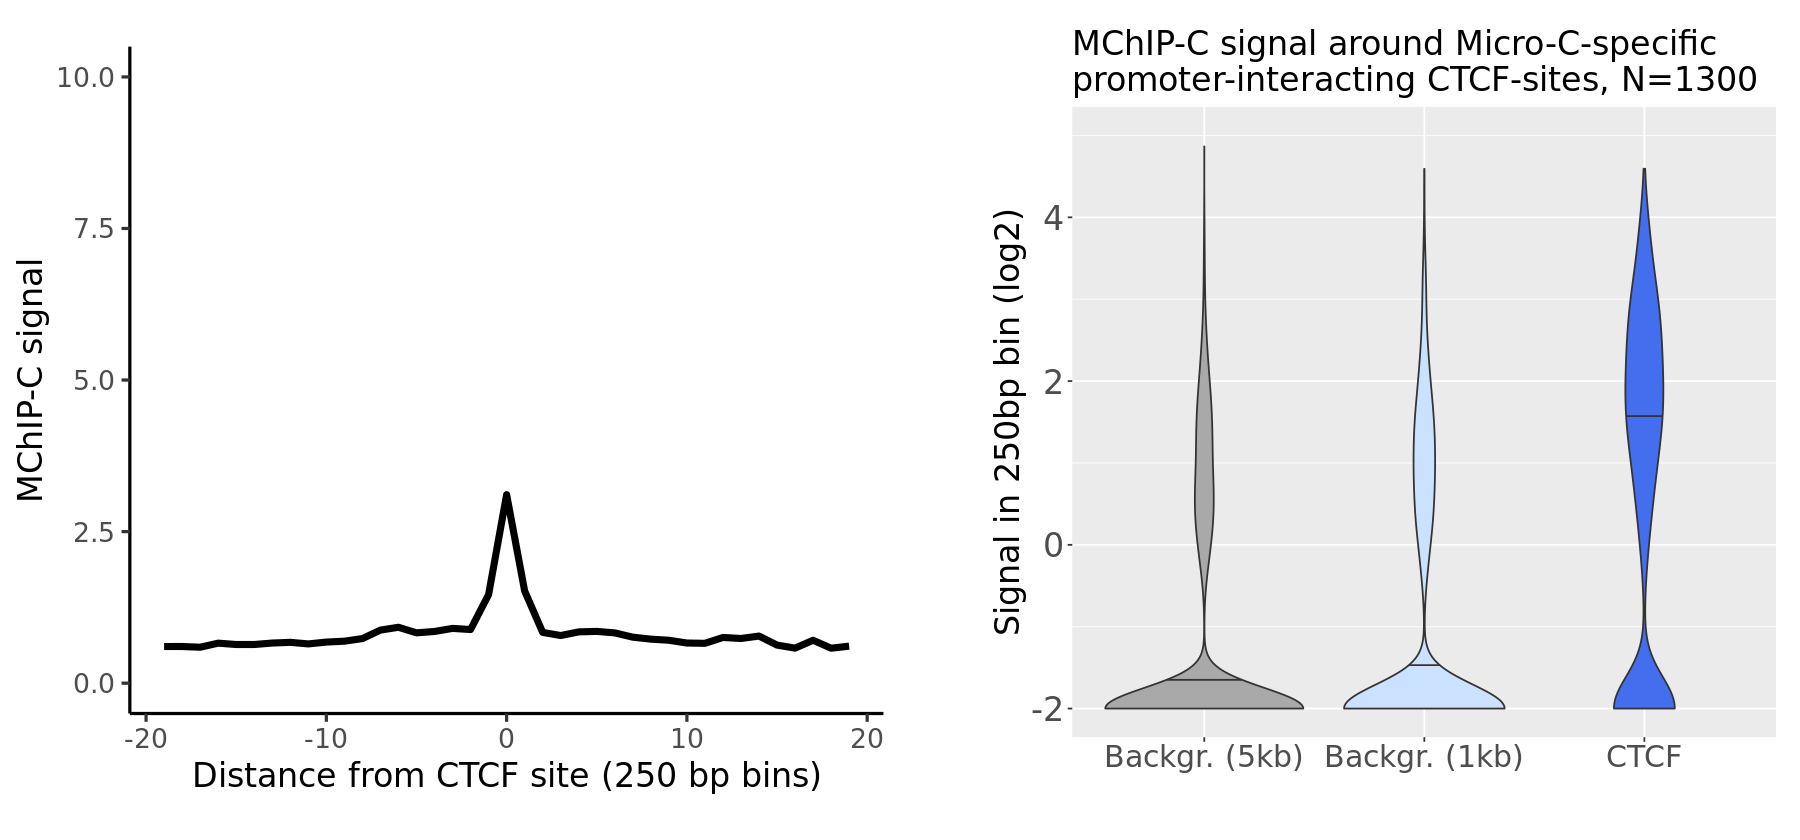

In [22]:
options(repr.plot.width=15, repr.plot.height=7)
grid.arrange(CTCF_MChIPC_MicroC_profile, 
             CTCF_MChIPC_MicroC_violin+theme(plot.margin=unit(c(0,0.5,0,2),"cm")),
             widths=c(0.5,0.5), heights=unit(6.5,"in"), ncol=2)

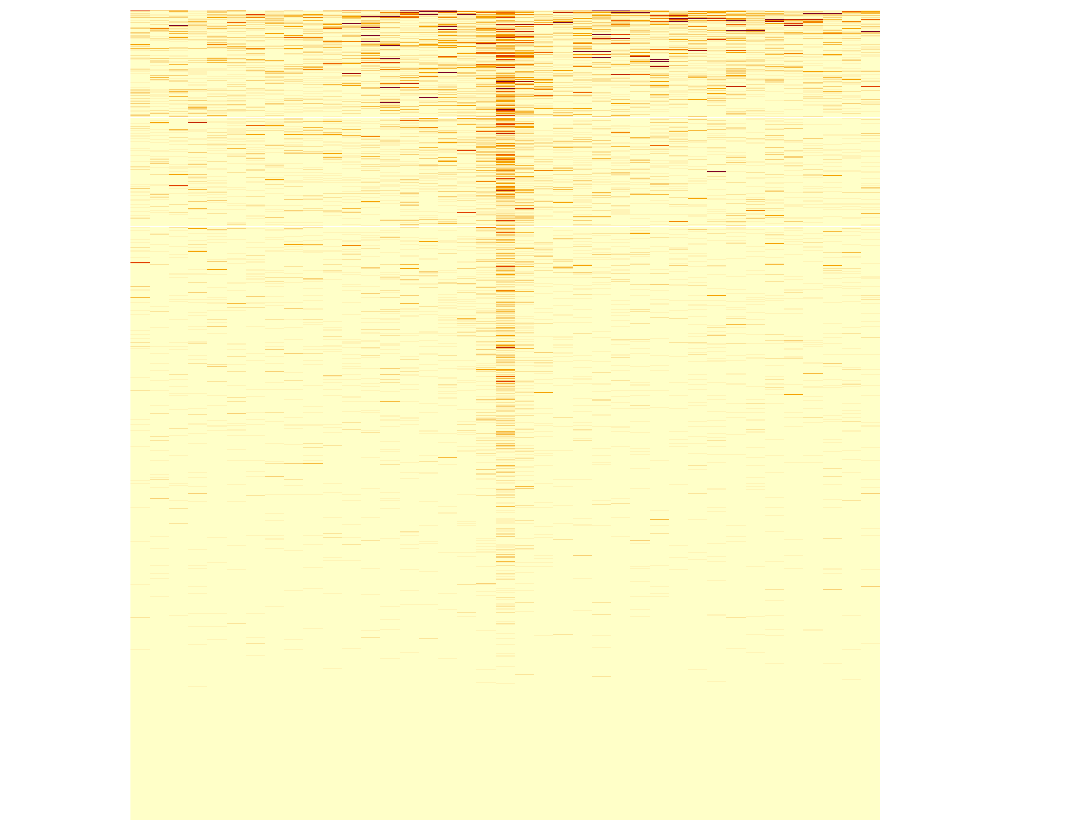

In [23]:
options(repr.plot.width=9, repr.plot.height=7)
heatmap(as.matrix(CTCF_heatmap_MChIPC_MicroC), Colv=NA, Rowv=NA, scale="none", labRow=FALSE, labCol=FALSE, margins = c(1, 4))

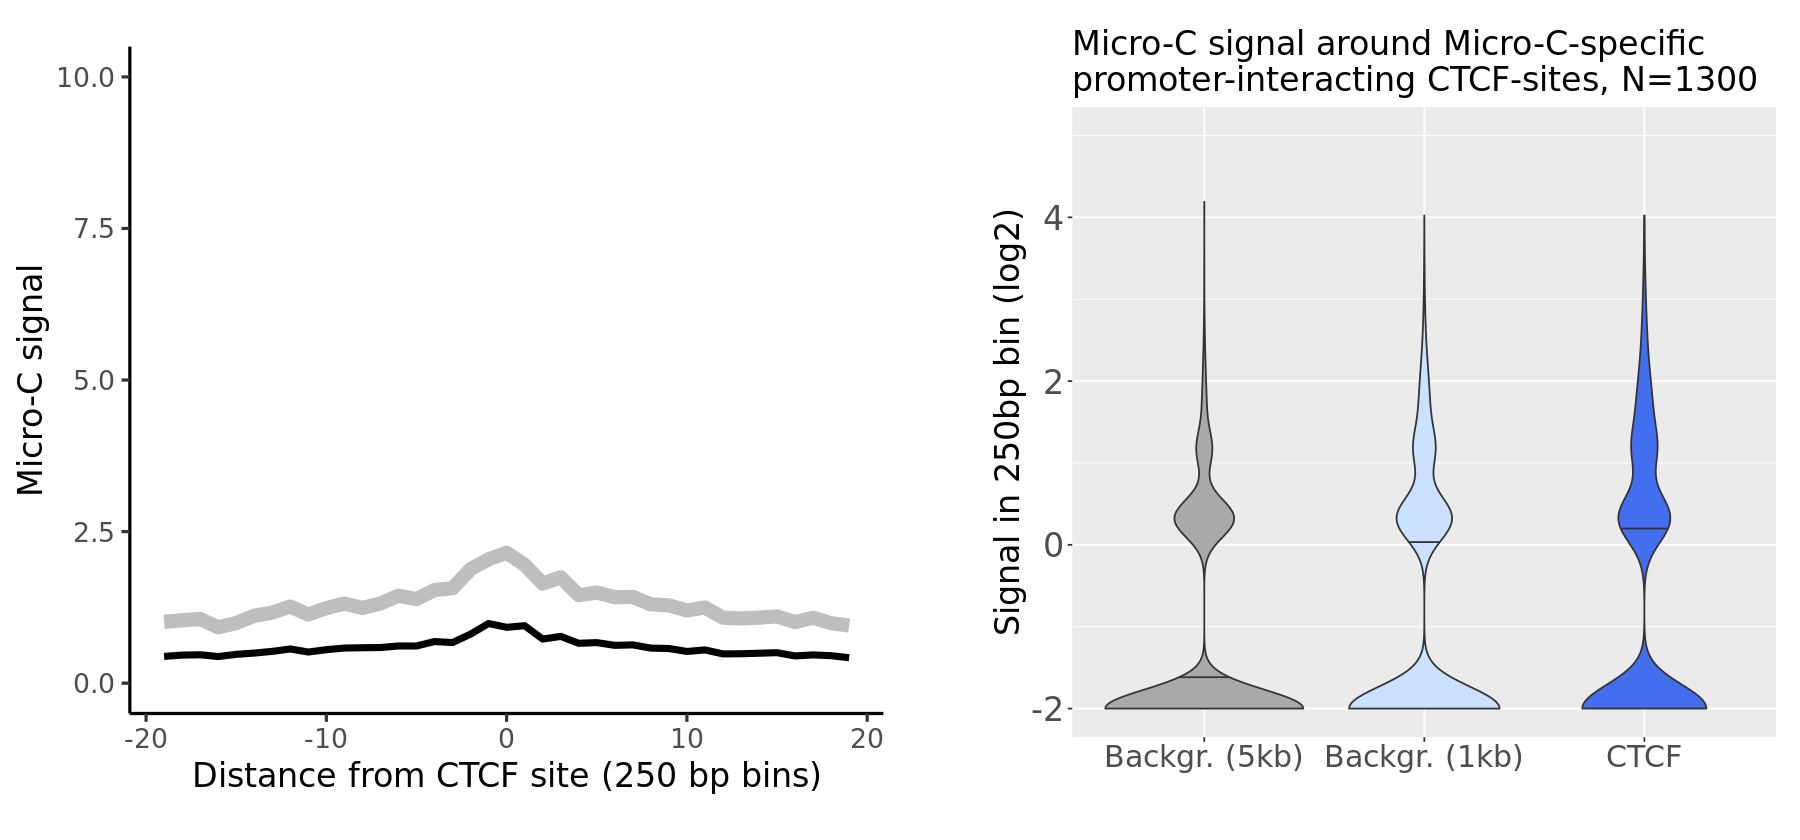

In [24]:
options(repr.plot.width=15, repr.plot.height=7)
grid.arrange(CTCF_MicroC_profile, 
             CTCF_MicroC_violin+theme(plot.margin=unit(c(0,0.5,0,2),"cm")),
             widths=c(0.5,0.5), heights=unit(6.5,"in"), ncol=2)

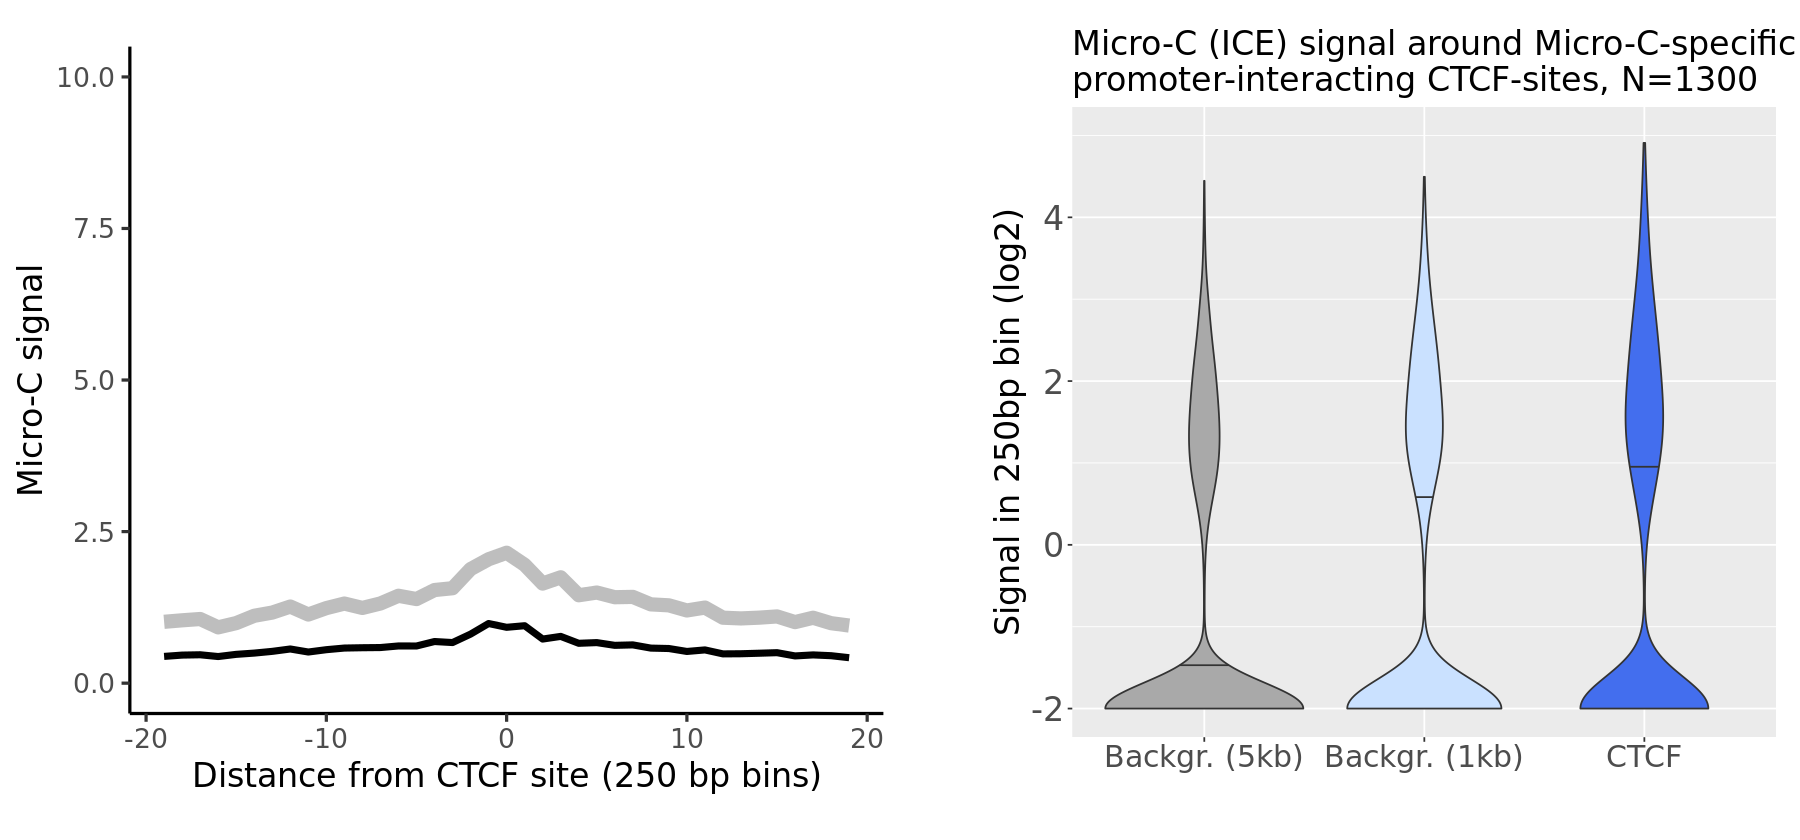

In [25]:
grid.arrange(CTCF_MicroC_profile, 
             CTCF_MicroC_ICE_violin+theme(plot.margin=unit(c(0,0.5,0,2),"cm")),
             widths=c(0.5,0.5), heights=unit(6.5,"in"), ncol=2)

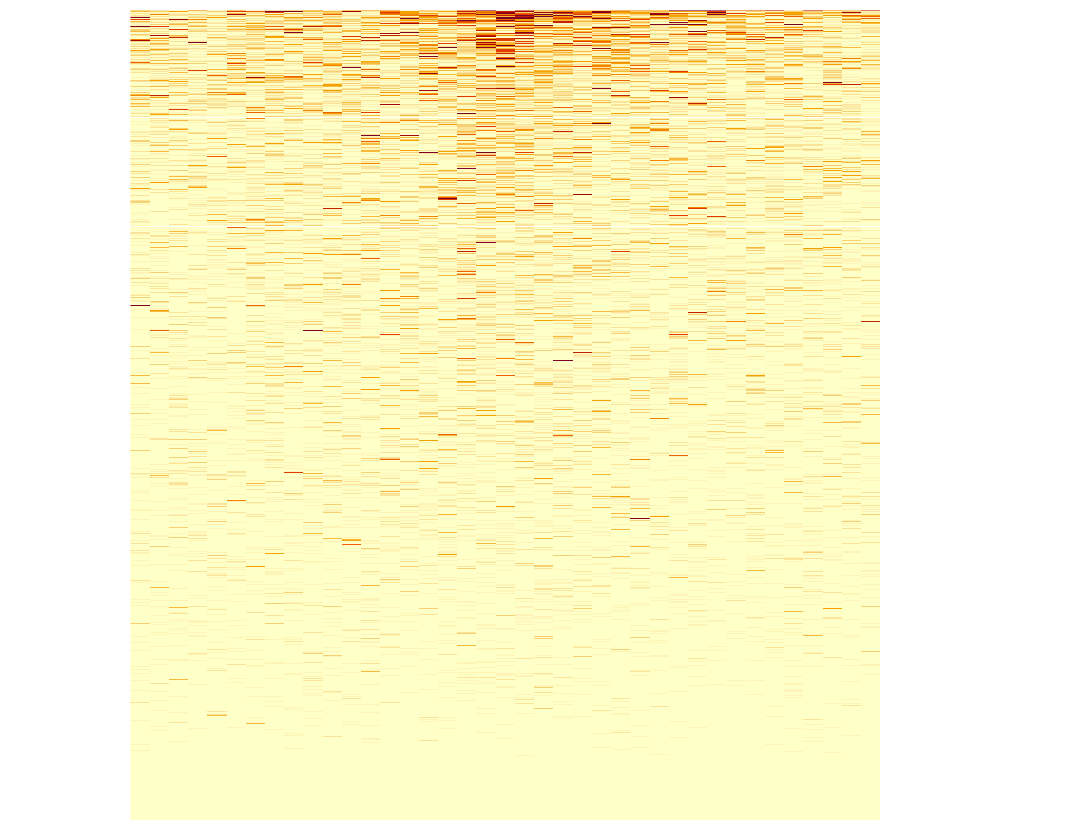

In [26]:
options(repr.plot.width=9, repr.plot.height=7)
heatmap(as.matrix(CTCF_heatmap_ICEM), Colv=NA, Rowv=NA, scale="none", labRow=FALSE, labCol=FALSE, margins = c(1, 4))

In [28]:
# saving plots
pdf("Figures/Fig.S3/S3d_MicroC_sp_CTCF_MChIPC.pdf", width=15, height=7)
grid.arrange(CTCF_MChIPC_MicroC_profile, 
             CTCF_MChIPC_MicroC_violin+theme(plot.margin=unit(c(0,0.5,0,2),"cm")),
             widths=c(0.5,0.5), heights=unit(6.5,"in"), ncol=2)
dev.off()

pdf("Figures/Fig.S3/S3d_MicroC_sp_CTCF_MicroC.pdf", width=15, height=7)
grid.arrange(CTCF_MicroC_profile, 
             CTCF_MicroC_violin+theme(plot.margin=unit(c(0,0.5,0,2),"cm")),
             widths=c(0.5,0.5), heights=unit(6.5,"in"), ncol=2)
dev.off()

pdf("Figures/Fig.S3/S3d_MicroC_sp_CTCF_MicroC_ICE.pdf", width=15, height=7)
grid.arrange(CTCF_MicroC_profile, 
             CTCF_MicroC_ICE_violin+theme(plot.margin=unit(c(0,0.5,0,2),"cm")),
             widths=c(0.5,0.5), heights=unit(6.5,"in"), ncol=2)
dev.off()

pdf("Figures/Fig.S3/S3d_MicroC_sp_CTCF_MChIPC_heatmap.pdf", width=9, height=7)
heatmap(as.matrix(CTCF_heatmap_MChIPC_MicroC), Colv=NA, Rowv=NA, scale="none", labRow=FALSE, labCol=FALSE, margins = c(1, 4))
dev.off()

pdf("Figures/Fig.S3/S3d_MicroC_sp_CTCF_MicroC_heatmap.pdf", width=9, height=7)
heatmap(as.matrix(CTCF_heatmap_ICEM), Colv=NA, Rowv=NA, scale="none", labRow=FALSE, labCol=FALSE, margins = c(1, 4))
dev.off()

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

# P-DHS

In [13]:
rm(list=ls()[!((ls()%in%c("summary_CTCF","summary_DHS")) | grepl("_dist",ls()))])
DHS_MicroC <- filter(summary_DHS, !(MChIPC)&!(PLACseq)&MicroC)
DHS_vp_ranges <- GRanges(seqnames = DHS_MicroC$vp_chr, 
                         ranges=IRanges(start=DHS_MicroC$vp_start, end=DHS_MicroC$vp_end))

# P-DHS in MChIP-C data
MChIPC_signal <- read.csv("MChIPC_output/MChIPC_interaction_data.txt", header = T, sep = "\t")
MChIPC_signal <- filter(MChIPC_signal, dist_rank!=0)
signal_ranges <- GRanges(seqnames = MChIPC_signal$vp_chr, 
                         ranges=IRanges(start=MChIPC_signal$vp_start, end=MChIPC_signal$vp_end))
MChIPC_signal <- MChIPC_signal[unique(as.data.frame(findOverlaps(signal_ranges, DHS_vp_ranges))$queryHits),]
MChIPC_signal <- filter(MChIPC_signal, dist_rank>19)
signal_ranges <- GRanges(seqnames = MChIPC_signal$vp_chr, 
                         ranges=IRanges(start=MChIPC_signal$vp_start, end=MChIPC_signal$vp_end))
DHS_heatmap <- tibble(dist_rank=seq(-19,19))
for (i in seq(nrow(DHS_MicroC))){
  loop <- DHS_MicroC[i,]
  loop_signal <- filter(MChIPC_signal, vp_chr==loop$vp_chr & vp_start==loop$vp_start & vp_end==loop$vp_end)
  loop_signal[loop_signal$vp_start > loop_signal$OE_start,]$dist_rank <- -1 * loop_signal[loop_signal$vp_start > 
                                                                                loop_signal$OE_start,]$dist_rank
  if (loop$vp_start > loop$DHS_start) {loop_signal <- filter(loop_signal, dist_rank >
                            floor(((loop$DHS_start+loop$DHS_end)/2 - vp_start)/250)-20 &
                            dist_rank<floor(((loop$DHS_start+loop$DHS_end)/2 - vp_start)/250)+20)}
      else {loop_signal <- filter(loop_signal, dist_rank>ceiling(((loop$DHS_start+
            loop$DHS_end)/2 - vp_end)/250)-20 & dist_rank<ceiling(((loop$DHS_start+
            loop$DHS_end)/2 - vp_end)/250)+20)}
  if (loop$vp_start > loop$DHS_start) {loop_signal$dist_rank <- loop_signal$dist_rank -
     floor(((loop$DHS_start+loop$DHS_end)/2 - loop_signal$vp_start)/250)} 
    else {loop_signal$dist_rank <- loop_signal$dist_rank - ceiling(((loop$DHS_start+
          loop$DHS_end)/2 - loop_signal$vp_end)/250)}
  loop_signal <- loop_signal[,c(21,28)]
  colnames(loop_signal)[2] <- paste0("loop_",i)
  suppressMessages({DHS_heatmap <- left_join(DHS_heatmap, loop_signal)})}
DHS_heatmap[is.na(DHS_heatmap)] <- 0
DHS_heatmap <- as.data.frame(t(DHS_heatmap)[2:ncol(DHS_heatmap),])
DHS_heatmap_MChIP <- arrange(DHS_heatmap, rowMeans(DHS_heatmap))
DHS_heatmap_MChIPC_MicroC <- arrange(DHS_heatmap, rowMeans(DHS_heatmap))
DHS_heatmap_MChIPC_MicroC[DHS_heatmap_MChIPC_MicroC>20] <- 20

DHS_MChIPC_MicroC_profile <- ggplot()+geom_line(aes(x=seq(-19,19,1),y=colMeans(DHS_heatmap_MChIP)),size=2)+
theme_classic(base_size = 20)+xlim(-19,19) + ylim(0,5) + 
xlab("Distance from DHS (250 bp bins)")+ylab("MChIP-C signal")

violin_data_DHS <- data.frame(MChIPC_DHS_5kb=c(unlist(DHS_heatmap[,c(1,39)])),
                          MChIPC_DHS_1kb=c(unlist(DHS_heatmap[,c(16,24)])),
                          MChIPC_DHS=c(unlist(DHS_heatmap[,c(20,20)])))
DHS_MChIPC_MicroC_violin <- ggplot(melt(violin_data_DHS)) + 
geom_violin(aes(variable, log2(value+0.25), fill=variable), draw_quantiles=0.5)+ ylim(-2,5) +
scale_x_discrete(labels=c("Backgr. (5kb)","Backgr. (1kb)","DHS")) + 
theme(axis.text.x = element_text(size = 18), axis.text.y = element_text(size = 20),text=element_text(size=20),
     plot.title=element_text(size=20)) +
labs(y="Signal in 250bp bin (log2)",x="") + 
scale_fill_manual(values=c("darkgrey","tan","darkorange3"))+
ggtitle(paste0("MChIP-C signal around Micro-C-specific\npromoter-interacting DHS-sites, N=",nrow(DHS_MicroC)))+
guides(fill=FALSE)

# P-DHS in Micro-C data
MicroC_signal <- read.csv("MicroC_output/MicroC.signal.df.txt", header = F, sep = "\t") %>% filter(V1!="")
colnames(MicroC_signal) <- c("vp_chr","vp_start","vp_end","OE_chr","OE_start","OE_end","N_sum", "N_sum_ICE")
signal_ranges <- GRanges(seqnames = MicroC_signal$vp_chr, 
                         ranges=IRanges(start=MicroC_signal$vp_start, end=MicroC_signal$vp_end))
MicroC_signal <- distinct(MicroC_signal[unique(as.data.frame(findOverlaps(signal_ranges, DHS_vp_ranges))$queryHits),])
MicroC_signal$dist_rank <- 0
MicroC_signal$dist_rank[MicroC_signal$vp_start>MicroC_signal$OE_start]<-(MicroC_signal$vp_start[MicroC_signal$vp_start>MicroC_signal$OE_start]- 
                                                            MicroC_signal$OE_start[MicroC_signal$vp_start>MicroC_signal$OE_start])/250
MicroC_signal$dist_rank[MicroC_signal$vp_end<MicroC_signal$OE_start]<-(MicroC_signal$OE_end[MicroC_signal$vp_end<MicroC_signal$OE_start]- 
                                                            MicroC_signal$vp_end[MicroC_signal$vp_end<MicroC_signal$OE_start])/250
MicroC_signal <- filter(MicroC_signal, dist_rank>19)
signal_ranges <- GRanges(seqnames = MicroC_signal$vp_chr, 
                         ranges=IRanges(start=MicroC_signal$vp_start, end=MicroC_signal$vp_end))
DHS_heatmap <- tibble(dist_rank=seq(-19,19))
DHS_heatmap_ICE <- tibble(dist_rank=seq(-19,19))
for (i in seq(nrow(DHS_MicroC))){
  loop <- DHS_MicroC[i,]
  loop_signal <- filter(MicroC_signal, vp_chr==loop$vp_chr & vp_start==loop$vp_start & vp_end==loop$vp_end)
  loop_signal[loop_signal$vp_start > loop_signal$OE_start,]$dist_rank <- -1 * loop_signal[loop_signal$vp_start > 
                                                                                loop_signal$OE_start,]$dist_rank
  if (loop$vp_start > loop$DHS_start) {loop_signal <- filter(loop_signal, dist_rank >
                            floor(((loop$DHS_start+loop$DHS_end)/2 - vp_start)/250)-20 &
                            dist_rank<floor(((loop$DHS_start+loop$DHS_end)/2 - vp_start)/250)+20)}
      else {loop_signal <- filter(loop_signal, dist_rank>ceiling(((loop$DHS_start+
            loop$DHS_end)/2 - vp_end)/250)-20 & dist_rank<ceiling(((loop$DHS_start+
            loop$DHS_end)/2 - vp_end)/250)+20)}
  if (loop$vp_start > loop$DHS_start) {loop_signal$dist_rank <- loop_signal$dist_rank -
     floor(((loop$DHS_start+loop$DHS_end)/2 - loop_signal$vp_start)/250)} 
    else {loop_signal$dist_rank <- loop_signal$dist_rank - ceiling(((loop$DHS_start+
          loop$DHS_end)/2 - loop_signal$vp_end)/250)}
  loop_signal_n <- loop_signal[,c(9,7)]
  loop_signal_ICE <- loop_signal[,c(9,8)]
  colnames(loop_signal_n)[2] <- paste0("loop_",i)
  colnames(loop_signal_ICE)[2] <- paste0("loop_",i)
  suppressMessages({DHS_heatmap <- left_join(DHS_heatmap, loop_signal_n)})
  suppressMessages({DHS_heatmap_ICE <- left_join(DHS_heatmap_ICE, loop_signal_ICE)})}
DHS_heatmap[is.na(DHS_heatmap)] <- 0
DHS_heatmap_ICE[is.na(DHS_heatmap_ICE)] <- 0
DHS_heatmap <- as.data.frame(t(DHS_heatmap)[2:ncol(DHS_heatmap),])
DHS_heatmap_ICE <- 1000*as.data.frame(t(DHS_heatmap_ICE)[2:ncol(DHS_heatmap_ICE),])
DHS_heatmap_ICEM <- arrange(DHS_heatmap_ICE, rowMeans(DHS_heatmap_ICE))
DHS_heatmap_ICEM[DHS_heatmap_ICEM>20] <- 20
DHS_heatmap_MicroC <- arrange(DHS_heatmap, rowMeans(DHS_heatmap))
DHS_heatmap_MicroC[DHS_heatmap_MicroC>20] <- 20

DHS_MicroC_profile <- ggplot()+geom_line(aes(x=seq(-19,19,1),y=colMeans(DHS_heatmap)),size=2)+
geom_line(aes(x=seq(-19,19,1),y=colMeans(DHS_heatmap_ICE)),size=4, color="grey")+
theme_classic(base_size = 20)+
xlim(-19,19) + ylim(0,5) + xlab("Distance from DHS (250 bp bins)")+ylab("Micro-C signal")

violin_data_DHS <- violin_data_DHS %>% mutate(MicroC_DHS_5kb=c(unlist(DHS_heatmap[,c(1,39)])),
                          MicroC_DHS_1kb=c(unlist(DHS_heatmap[,c(16,24)])),
                          MicroC_DHS=c(unlist(DHS_heatmap[,c(20,20)])))
DHS_MicroC_violin <- ggplot(melt(violin_data_DHS[,4:6])) + 
geom_violin(aes(variable, log2(value+0.25), fill=variable), draw_quantiles=0.5)+ ylim(-2,5) +
scale_x_discrete(labels=c("Backgr. (5kb)","Backgr. (1kb)","DHS")) + 
theme(axis.text.x = element_text(size = 18), axis.text.y = element_text(size = 20),text=element_text(size=20),
     plot.title=element_text(size=20)) +
labs(y="Signal in 250bp bin (log2)",x="") + 
scale_fill_manual(values=c("darkgrey","tan","darkorange3"))+
ggtitle(paste0("Micro-C signal around Micro-C-specific\npromoter-interacting DHS-sites, N=",nrow(DHS_MicroC)))+ guides(fill=FALSE)

violin_data_DHS <- violin_data_DHS %>% mutate(MicroC_DHS_ICE_5kb=c(unlist(DHS_heatmap_ICE[,c(1,39)])),
                          MicroC_DHS_ICE_1kb=c(unlist(DHS_heatmap_ICE[,c(16,24)])),
                          MicroC_DHS_ICE=c(unlist(DHS_heatmap_ICE[,c(20,20)])))
DHS_MicroC_ICE_violin <- ggplot(melt(violin_data_DHS[,7:9])) + 
geom_violin(aes(variable, log2(value+0.25), fill=variable), draw_quantiles=0.5)+ ylim(-2,5) +
scale_x_discrete(labels=c("Backgr. (5kb)","Backgr. (1kb)","DHS")) + 
theme(axis.text.x = element_text(size = 18), axis.text.y = element_text(size = 20),text=element_text(size=20),
     plot.title=element_text(size=20)) +
labs(y="Signal in 250bp bin (log2)",x="") + 
scale_fill_manual(values=c("darkgrey","tan","darkorange3"))+
ggtitle(paste0("Micro-C (ICE) signal around Micro-C specific\npromoter-interacting DHS-sites, N=",nrow(DHS_MicroC)))+ guides(fill=FALSE)

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables



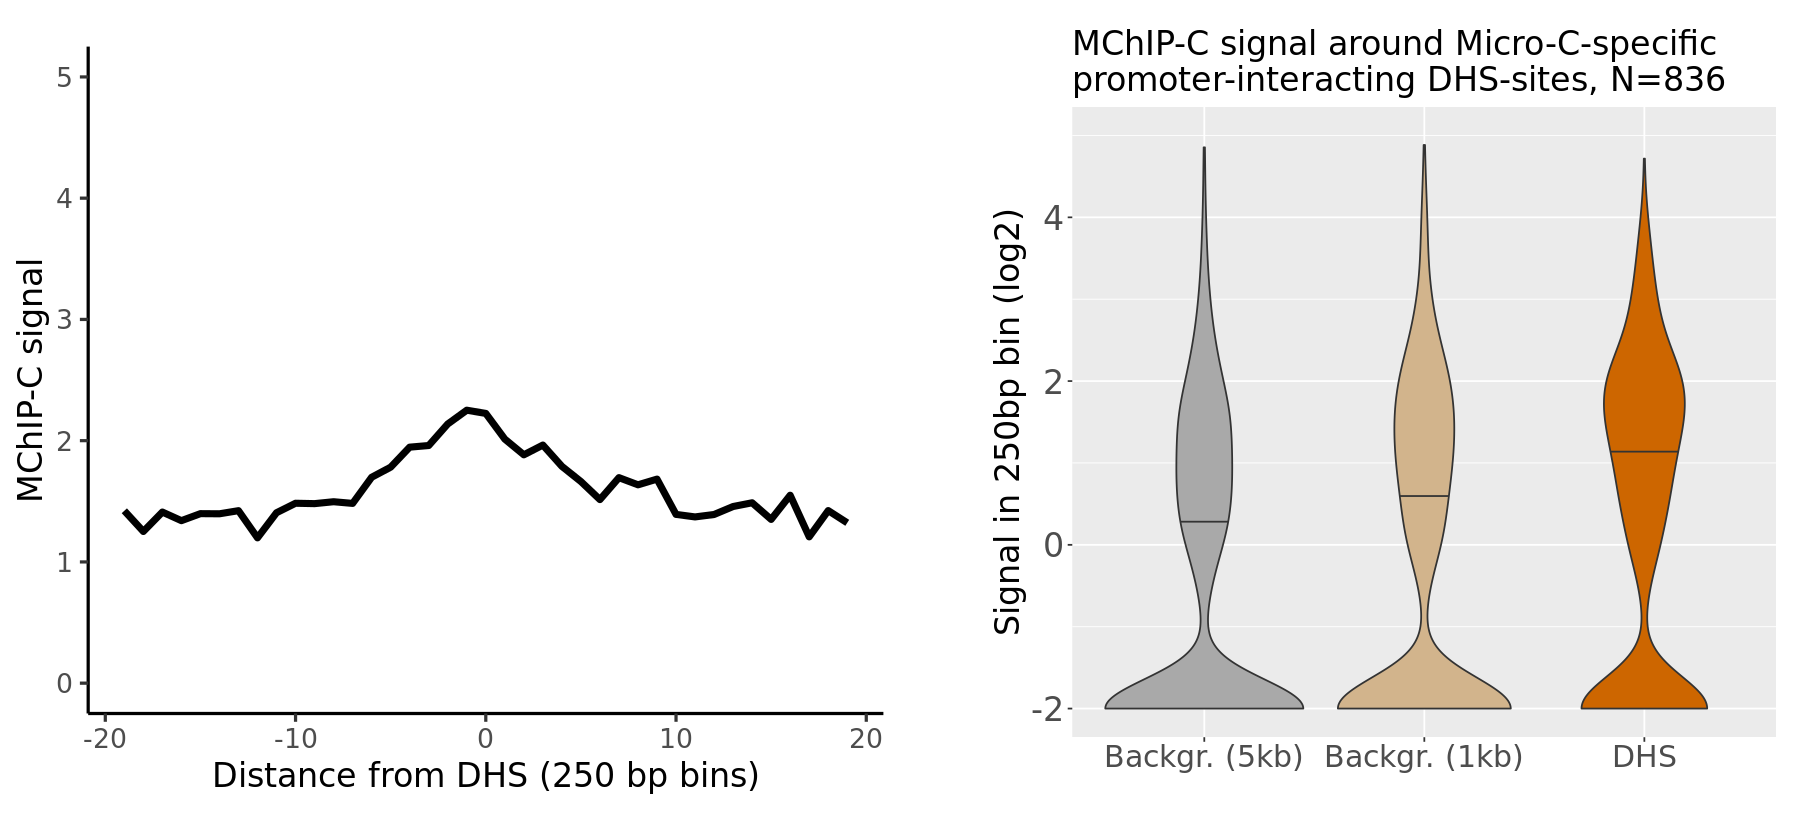

In [14]:
options(repr.plot.width=15, repr.plot.height=7)
grid.arrange(DHS_MChIPC_MicroC_profile, 
             DHS_MChIPC_MicroC_violin+theme(plot.margin=unit(c(0,0.5,0,2),"cm")),
             widths=c(0.5,0.5), heights=unit(6.5,"in"), ncol=2)

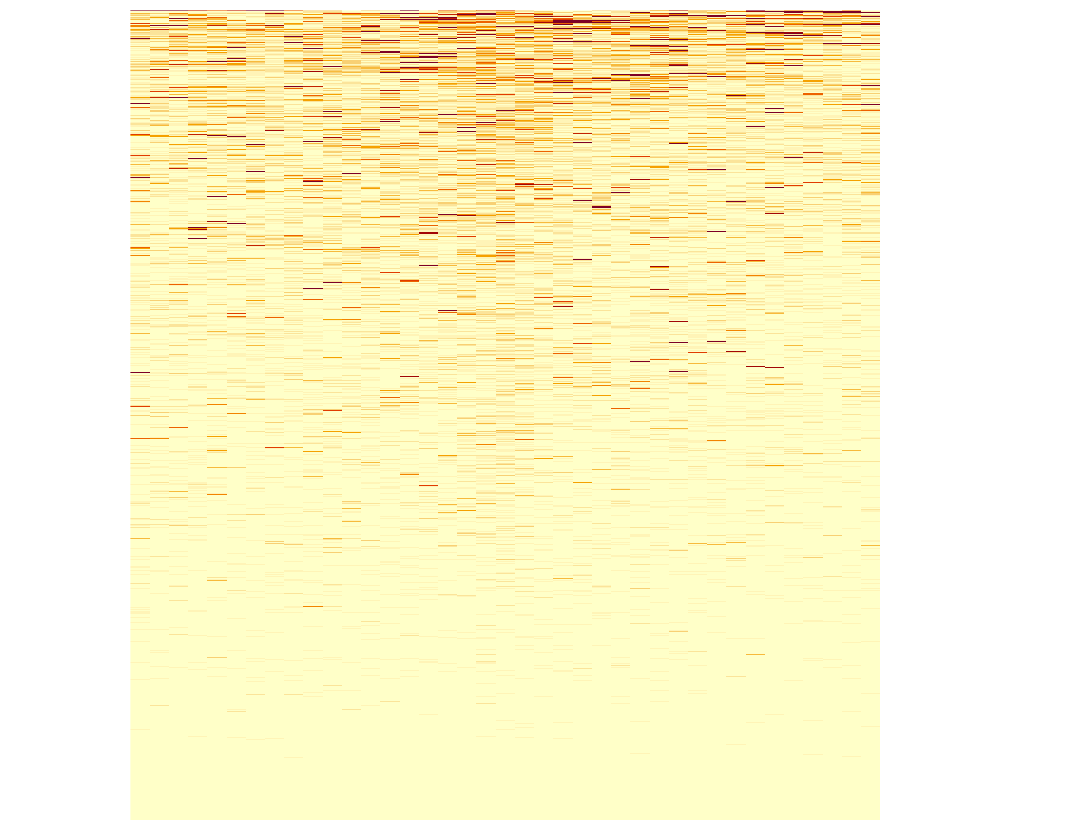

In [15]:
options(repr.plot.width=9, repr.plot.height=7)
heatmap(as.matrix(DHS_heatmap_MChIPC_MicroC), Colv=NA, Rowv=NA, scale="none", labRow=FALSE, labCol=FALSE, margins = c(1, 4))

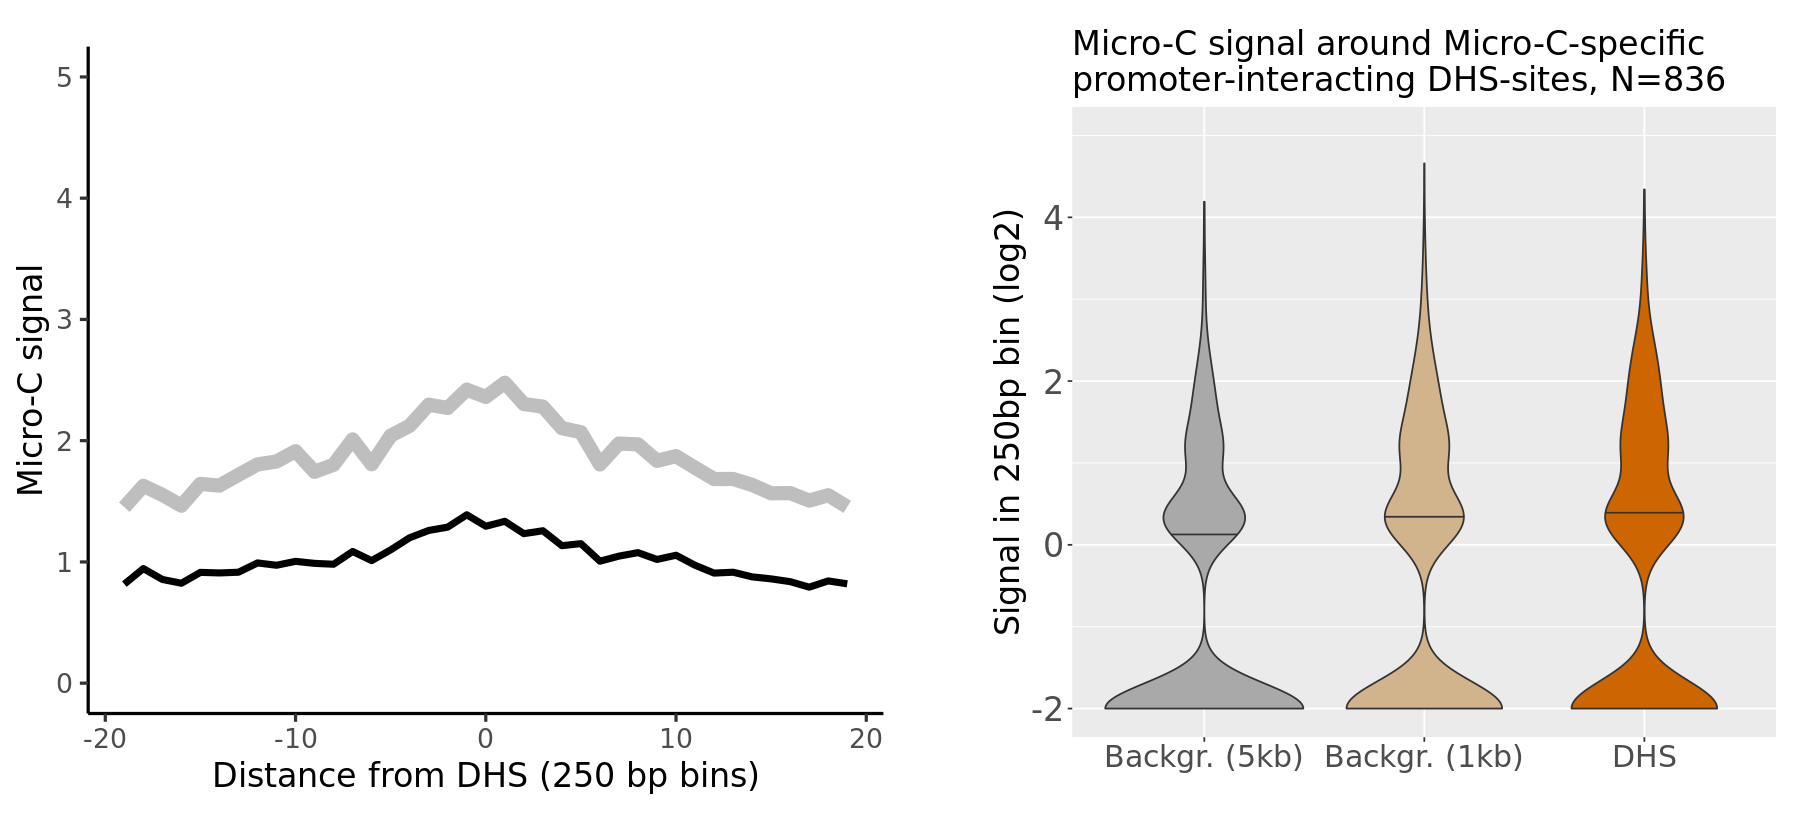

In [16]:
options(repr.plot.width=15, repr.plot.height=7)
grid.arrange(DHS_MicroC_profile, 
             DHS_MicroC_violin+theme(plot.margin=unit(c(0,0.5,0,2),"cm")),
             widths=c(0.5,0.5), heights=unit(6.5,"in"), ncol=2)

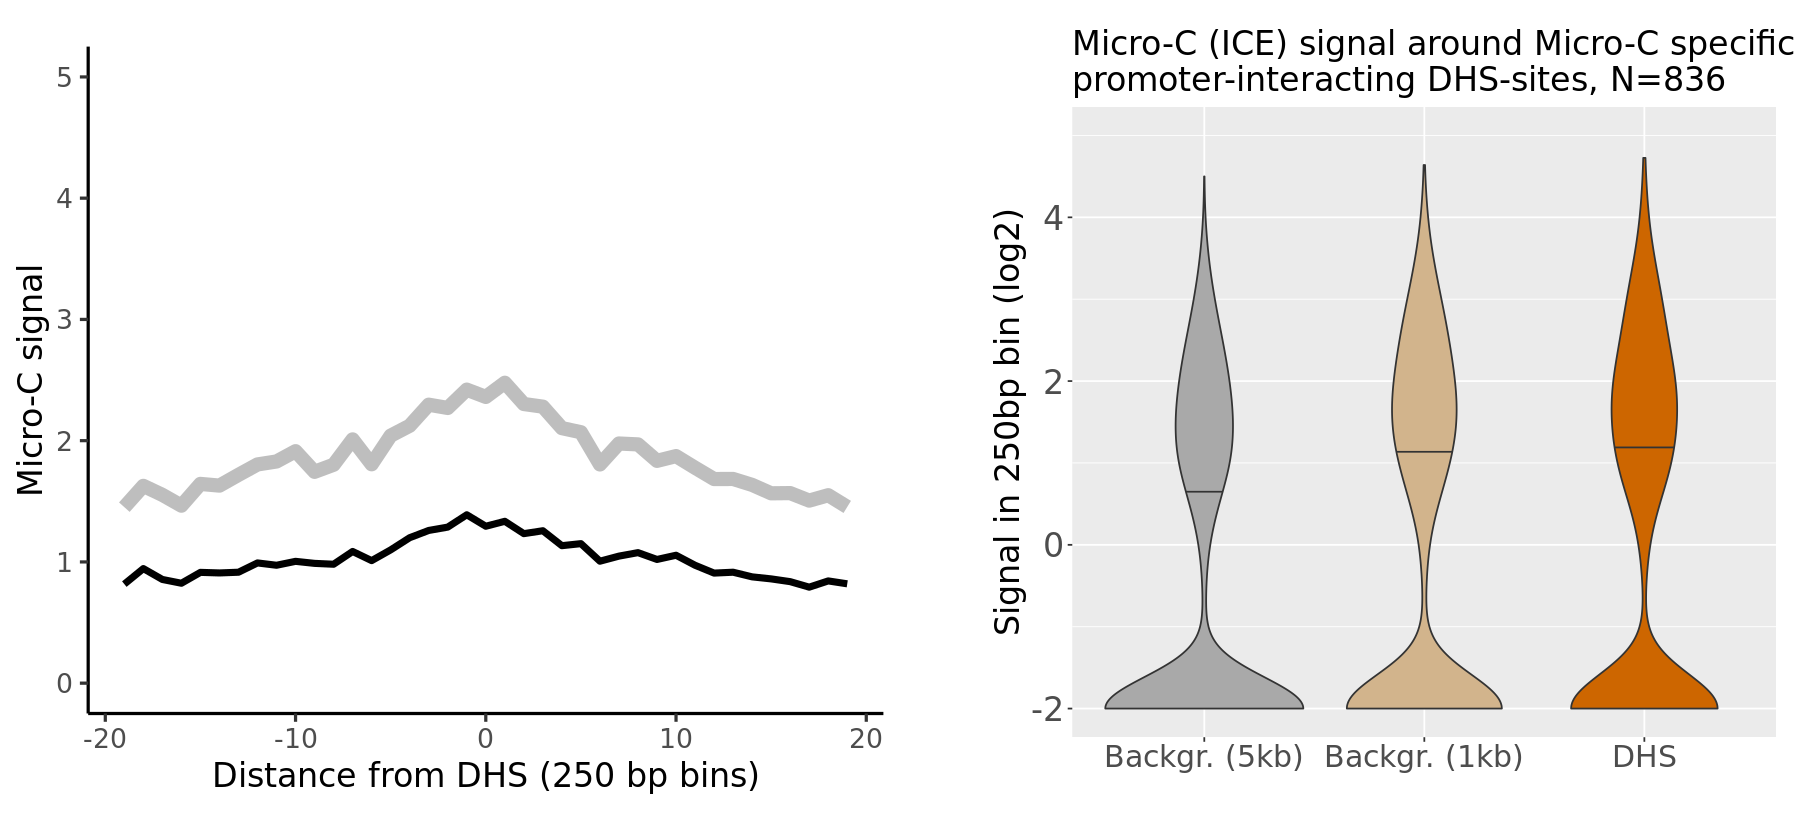

In [17]:
grid.arrange(DHS_MicroC_profile, 
             DHS_MicroC_ICE_violin+theme(plot.margin=unit(c(0,0.5,0,2),"cm")),
             widths=c(0.5,0.5), heights=unit(6.5,"in"), ncol=2)

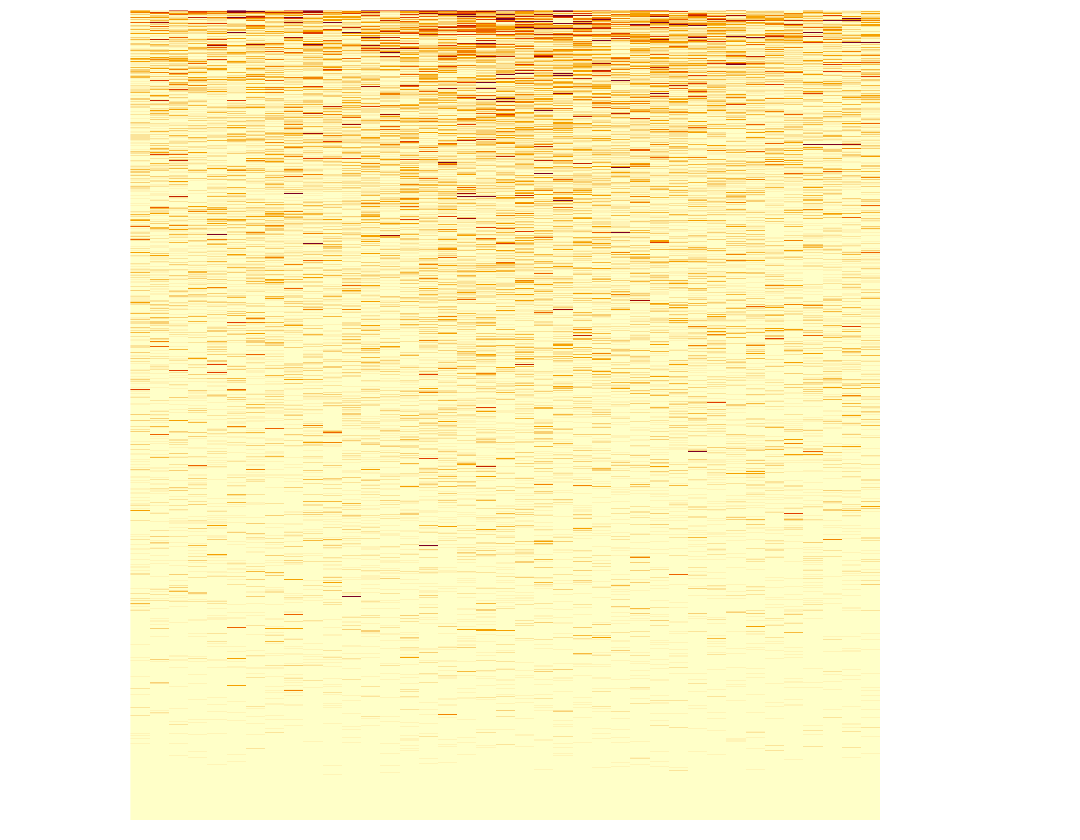

In [18]:
options(repr.plot.width=9, repr.plot.height=7)
heatmap(as.matrix(DHS_heatmap_ICEM), Colv=NA, Rowv=NA, scale="none", labRow=FALSE, labCol=FALSE, margins = c(1, 4))

In [20]:
# saving plots
pdf("Figures/Fig.S3/S3d_MicroC_sp_DHS_MChIPC.pdf", width=15, height=7)
grid.arrange(DHS_MChIPC_MicroC_profile, 
             DHS_MChIPC_MicroC_violin+theme(plot.margin=unit(c(0,0.5,0,2),"cm")),
             widths=c(0.5,0.5), heights=unit(6.5,"in"), ncol=2)
dev.off()

pdf("Figures/Fig.S3/S3d_MicroC_sp_DHS_MicroC.pdf", width=15, height=7)
grid.arrange(DHS_MicroC_profile, 
             DHS_MicroC_violin+theme(plot.margin=unit(c(0,0.5,0,2),"cm")),
             widths=c(0.5,0.5), heights=unit(6.5,"in"), ncol=2)
dev.off()

pdf("Figures/Fig.S3/S3d_MicroC_sp_DHS_MicroC_ICE.pdf", width=15, height=7)
grid.arrange(DHS_MicroC_profile, 
             DHS_MicroC_ICE_violin+theme(plot.margin=unit(c(0,0.5,0,2),"cm")),
             widths=c(0.5,0.5), heights=unit(6.5,"in"), ncol=2)
dev.off()

pdf("Figures/Fig.S3/S3d_MicroC_sp_DHS_MChIPC_heatmap.pdf", width=9, height=7)
heatmap(as.matrix(DHS_heatmap_MChIPC_MicroC), Colv=NA, Rowv=NA, scale="none", labRow=FALSE, labCol=FALSE, margins = c(1, 4))
dev.off()

pdf("Figures/Fig.S3/S3d_MicroC_sp_DHS_MicroC_heatmap.pdf", width=9, height=7)
heatmap(as.matrix(DHS_heatmap_ICEM), Colv=NA, Rowv=NA, scale="none", labRow=FALSE, labCol=FALSE, margins = c(1, 4))
dev.off()

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2